# Testing the functions in torchgp.parameterizations.sqrtvar

In [1]:
%matplotlib inline

import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR
from torchgp.symbolic import *
from torchgp.transforms import *
from torchgp.reparameterization import *
from torchgp.test_tools import *
from torchgp.kernels import *
from torchgp.parameterizations.sqrtvar import *
from torchgp.natural_gradient.variational import ConstrainedLowerTriangular
import math
import networkx as nx
from matplotlib.pyplot import *

## Example 1a:

1. Fully observed
2. Gaussian likelihood
3. Analytic evaluation of likelihood, aka no reparameterization gradients
4. 1D signal

In [2]:
#generate the data
x, yc, y = make_fake_herfd_fully_observed(100, 100)

Text(0.5, 1.0, 'The data being considered')

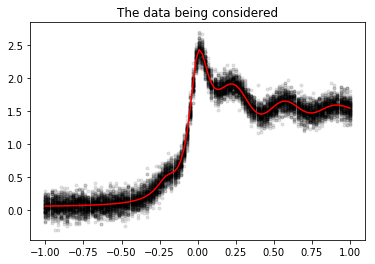

In [3]:
figure()
plot(x,yc,'k.',alpha=0.1)
plot(x[:100],y,'r')
title('The data being considered')

In [4]:
class VFE_1D(torch.nn.Module):
    def __init__(self, U, Ntotal, std_lik_init = 0.5, lenscale_init = 0.15, dtype=torch.get_default_dtype()):
        super().__init__()
        self.dtype = dtype
        #define the input parameters
        #posterior mean vector
        m0 = MeanSymbol('m0')
        m = Vector('m')
        #posterior variance vector parameter
        L = Matrix('L')
        #axes that kernels are evaluated on
        u = Vector('u')
        f = Vector('f')
        #Kernels
        #these are the symbols that go into the graph
        K = Kernel('K')
        #observations, arranged Nx1
        y = Vector('y')
        Ntotal = Constant(Ntotal)
        #and finally the standard deviation of the likelihood
        std_lik = Scalar('std_lik')
        jitter = Scalar('jitter')
        #generally there are parameters which require positivity. I use this transform for them:
        self._makepos = SoftplusTransform()
        
        ### KL loss graph ###
        kl_loss = kl(K, u, m0, L, m, jitter)
        self._kl_loss_expr = kl_loss
        graph = expr2graph(Label(String("kl_loss"), kl_loss))
        self._kl_loss_fun = graph2ast(graph, compiled=True, debug=False)
        
        ### Predict to f-space ###
        mf = mean(K, u, f, m0, m, jitter)
        graph = expr2graph(Label(String("mean_pred"), mf))
        self._mean_pred = graph2ast(graph, compiled=True, debug=False)
        varf = var_fullspace_diag(K, f) - var_subspace_diag(K, u, f, jitter) + var_posterior_diag(K, u, f, L, jitter)
        graph = expr2graph(Label(String("var_pred"), varf))
        self._var_pred = graph2ast(graph, compiled=True, debug=False)
        
        
        ### Gaussian Likelihood in f-space ###
        ve_loss = analytic_gaussian_likelihood(y, mf, varf, std_lik, Ntotal)
        self._ve_loss_expr = ve_loss
        graph = expr2graph(Label(String("ve_loss"), ve_loss))
        self._ve_loss_fun = graph2ast(graph, compiled=True, debug=False)
        
        #form the total loss
        loss = -ve_loss + kl_loss
        graph = expr2graph(Label(String("loss"), loss))
        self._loss_fun = graph2ast(graph, compiled=True, debug=False)
        
        
        
        #the actual storage tensors go here:
        with torch.no_grad():
            self.variational_params = torch.nn.ParameterDict({
                'm': torch.nn.Parameter(torch.randn((U,1),dtype=self.dtype)/U),
            })
            self.hyper_params = torch.nn.ParameterDict({
                'std_lik': torch.nn.Parameter(self._makepos.inv(torch.tensor([[std_lik_init]],dtype=self.dtype))),
                'u': torch.nn.Parameter(torch.linspace(-1,1,U,dtype=self.dtype).unsqueeze(1)),
                #fixed parameters go here:
                'jitter': torch.nn.Parameter(torch.tensor(1e-4,dtype=self.dtype), requires_grad=False)
            })

            #modules containing parameters go here:
            self.stored_modules = torch.nn.ModuleDict({
                'K': ARDRBFKernel(lengthscale=torch.tensor([[lenscale_init]])),
                'm0': ConstantMean(torch.tensor(0.)),
                })
        priorL = (self.stored_modules['K'](self.hyper_params['u'],self.hyper_params['u']) + 
                  torch.eye(U)*1e-4).cholesky()
        self.L = ConstrainedLowerTriangular(U)
        self.L.custom_initialization(priorL)
    def kl_loss(self):
        leaves = {
            **self.variational_params,
            **self.hyper_params,
            **self.stored_modules,
            'L': self.L()
        }
        result = self._kl_loss_fun(**leaves)
        return result.kl_loss
    def ve_loss(self, y, x):
        leaves = {
            'y': y,
            'f': x,
            **self.variational_params,
            **self.hyper_params,
            **self.stored_modules,
            'std_lik': self._makepos(self.hyper_params['std_lik']),
            'L': self.L()
        }
        result = self._ve_loss_fun(**leaves)
        return result.ve_loss
    def loss(self, y, x):
        leaves = {
            'y': y,
            'f': x,
            **self.variational_params,
            **self.hyper_params,
            **self.stored_modules,
            'std_lik': self._makepos(self.hyper_params['std_lik']),
            'L': self.L()
        }
        result = self._loss_fun(**leaves)
        return result.loss
    def predict_mean(self, x):
        leaves = {
            'f': x,
            **self.variational_params,
            **self.hyper_params,
            **self.stored_modules,
            'std_lik': self._makepos(self.hyper_params['std_lik']),
            'L': self.L()
        }
        result = self._mean_pred(**leaves)
        return result.mean_pred
    def predict_var(self, x):
        leaves = {
            'f': x,
            **self.variational_params,
            **self.hyper_params,
            **self.stored_modules,
            'std_lik': self._makepos(self.hyper_params['std_lik']),
            'L': self.L()
        }
        result = self._var_pred(**leaves)
        return result.var_pred

## First, test the KL loss

In [5]:
minit = VFE_1D(30,100*100)
m = VFE_1D(30,100*100)

Module path:  /home/fdfuller/work/torchgp/notebooks/reparam/.compiled/90aa7d00bb838b54.py
Module path:  /home/fdfuller/work/torchgp/notebooks/reparam/.compiled/078818802d755c5c.py
Module path:  /home/fdfuller/work/torchgp/notebooks/reparam/.compiled/f31ae3cd60b738d7.py
Module path:  /home/fdfuller/work/torchgp/notebooks/reparam/.compiled/9764414d5e858f04.py
Module path:  /home/fdfuller/work/torchgp/notebooks/reparam/.compiled/e4fc5f1d3c2c4253.py
Module path:  /home/fdfuller/work/torchgp/notebooks/reparam/.compiled/90aa7d00bb838b54.py
Module path:  /home/fdfuller/work/torchgp/notebooks/reparam/.compiled/078818802d755c5c.py
Module path:  /home/fdfuller/work/torchgp/notebooks/reparam/.compiled/f31ae3cd60b738d7.py
Module path:  /home/fdfuller/work/torchgp/notebooks/reparam/.compiled/9764414d5e858f04.py
Module path:  /home/fdfuller/work/torchgp/notebooks/reparam/.compiled/e4fc5f1d3c2c4253.py


In [6]:
m.hyper_params['u'].requires_grad = False
m.stored_modules['K']._lengthscale_storage.requires_grad = False
m.stored_modules['K']._amplitude_storage.requires_grad = False
m.stored_modules['m0'].value.requires_grad = False
# m.cuda()
optimizer = torch.optim.Adam(m.parameters(),lr=1e-2)

n_iter = 1000
scheduler = StepLR(optimizer,50,gamma=0.93)

for i in range(n_iter):
    optimizer.zero_grad()
    loss = m.kl_loss()
    loss.backward()
    optimizer.step()
    scheduler.step()
    if i % 10 == 0:
        report = f"iter={i},loss={loss.item()}"
        print(report)

iter=0,loss=37.67388153076172
iter=10,loss=7.851402282714844
iter=20,loss=2.6387557983398438
iter=30,loss=0.6067771911621094
iter=40,loss=0.25441741943359375
iter=50,loss=0.14677047729492188
iter=60,loss=0.07583999633789062
iter=70,loss=0.040203094482421875
iter=80,loss=0.026363372802734375
iter=90,loss=0.02129364013671875
iter=100,loss=0.016963958740234375
iter=110,loss=0.014324188232421875
iter=120,loss=0.01239013671875
iter=130,loss=0.010776519775390625
iter=140,loss=0.0095062255859375
iter=150,loss=0.008453369140625
iter=160,loss=0.007656097412109375
iter=170,loss=0.00699615478515625
iter=180,loss=0.00643157958984375
iter=190,loss=0.00595855712890625
iter=200,loss=0.0055694580078125
iter=210,loss=0.005268096923828125
iter=220,loss=0.0050048828125
iter=230,loss=0.007740020751953125
iter=240,loss=0.0047760009765625
iter=250,loss=0.005645751953125
iter=260,loss=0.00460052490234375
iter=270,loss=0.0042724609375
iter=280,loss=0.004108428955078125
iter=290,loss=0.003955841064453125
iter=

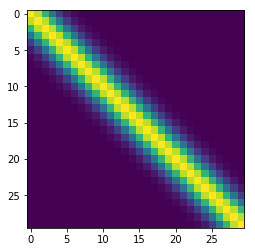

In [7]:
figure()
L = m.L().detach().numpy()
imshow(L @ L.T)

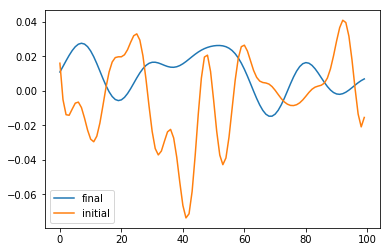

In [8]:
figure()
plot(m.predict_mean(torch.linspace(-1,1,100).unsqueeze(1)).detach().numpy(),label='final')
plot(minit.predict_mean(torch.linspace(-1,1,100).unsqueeze(1)).detach().numpy(),label='initial')
legend()

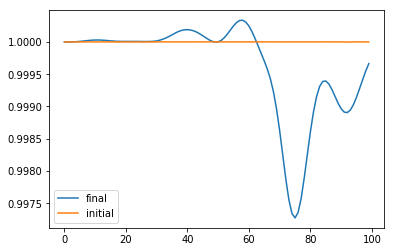

In [9]:
figure()
plot(m.predict_var(torch.linspace(-1,1,100).unsqueeze(1)).detach().numpy(),label='final')
plot(minit.predict_var(torch.linspace(-1,1,100).unsqueeze(1)).detach().numpy(),label='initial')
legend()

In [10]:
m = VFE_1D(50,100*100);
# m.cuda()
optimizer = torch.optim.Adam(m.parameters(),lr=1e-2)
epochs = 2000
scheduler = StepLR(optimizer,50,gamma=0.95)

data = TensorDataset(torch.from_numpy(x.astype('float32')), torch.from_numpy(yc.astype('float32')))
Logger = ScalarLogger(m, {'hyper_params.std_lik': m._makepos,
                          'stored_modules.K._lengthscale_storage': m._makepos,
                          'stored_modules.K._amplitude_storage': m._makepos},
                     extra_keys={'loss': lambda x: x,
                                'step_size': lambda x: x})

for i in range(epochs):
    d = DataLoader(dataset=data, shuffle=True, batch_size=5000)
    for (xb,yb) in d:
#         xbc, ybc = xb.cuda(), yb.cuda()
        optimizer.zero_grad()
        loss = m.loss(yb, xb)
        loss.backward()
        optimizer.step()
        Logger(extra_vals=[float(loss), float(optimizer.param_groups[0]['lr'])])
    scheduler.step()
    print(Logger.report("epoch {:d}: ".format(i)))
        

Module path:  /Users/fdfuller/SLAC National Accelerator Laboratory/Fuller Group - Documents/Code/Frank/torchgp/notebooks/reparam/.compiled/90aa7d00bb838b54.py
Module path:  /Users/fdfuller/SLAC National Accelerator Laboratory/Fuller Group - Documents/Code/Frank/torchgp/notebooks/reparam/.compiled/078818802d755c5c.py
Module path:  /Users/fdfuller/SLAC National Accelerator Laboratory/Fuller Group - Documents/Code/Frank/torchgp/notebooks/reparam/.compiled/f31ae3cd60b738d7.py
Module path:  /Users/fdfuller/SLAC National Accelerator Laboratory/Fuller Group - Documents/Code/Frank/torchgp/notebooks/reparam/.compiled/9764414d5e858f04.py
Module path:  /Users/fdfuller/SLAC National Accelerator Laboratory/Fuller Group - Documents/Code/Frank/torchgp/notebooks/reparam/.compiled/e4fc5f1d3c2c4253.py
epoch 0: hyper_params.std_lik: 0.507907, stored_modules.K._lengthscale_storage: 0.137467, stored_modules.K._amplitude_storage: 0.701999, loss: 52397.8, step_size: 0.01, 
epoch 1: hyper_params.std_lik: 0.51

epoch 44: hyper_params.std_lik: 0.637347, stored_modules.K._lengthscale_storage: 0.0965517, stored_modules.K._amplitude_storage: 0.830301, loss: 8014.93, step_size: 0.01, 
epoch 45: hyper_params.std_lik: 0.636396, stored_modules.K._lengthscale_storage: 0.0966653, stored_modules.K._amplitude_storage: 0.828171, loss: 8020.26, step_size: 0.01, 
epoch 46: hyper_params.std_lik: 0.635408, stored_modules.K._lengthscale_storage: 0.0968166, stored_modules.K._amplitude_storage: 0.825908, loss: 7902.29, step_size: 0.01, 
epoch 47: hyper_params.std_lik: 0.634386, stored_modules.K._lengthscale_storage: 0.0969363, stored_modules.K._amplitude_storage: 0.824294, loss: 7836.48, step_size: 0.01, 
epoch 48: hyper_params.std_lik: 0.633328, stored_modules.K._lengthscale_storage: 0.0970545, stored_modules.K._amplitude_storage: 0.822803, loss: 7824.11, step_size: 0.01, 
epoch 49: hyper_params.std_lik: 0.632238, stored_modules.K._lengthscale_storage: 0.097192, stored_modules.K._amplitude_storage: 0.821488, lo

epoch 92: hyper_params.std_lik: 0.568921, stored_modules.K._lengthscale_storage: 0.0998154, stored_modules.K._amplitude_storage: 0.815274, loss: 6176.11, step_size: 0.0095, 
epoch 93: hyper_params.std_lik: 0.567096, stored_modules.K._lengthscale_storage: 0.0999324, stored_modules.K._amplitude_storage: 0.815037, loss: 6179.41, step_size: 0.0095, 
epoch 94: hyper_params.std_lik: 0.565257, stored_modules.K._lengthscale_storage: 0.100025, stored_modules.K._amplitude_storage: 0.814971, loss: 6137.59, step_size: 0.0095, 
epoch 95: hyper_params.std_lik: 0.563401, stored_modules.K._lengthscale_storage: 0.100138, stored_modules.K._amplitude_storage: 0.814943, loss: 6153.81, step_size: 0.0095, 
epoch 96: hyper_params.std_lik: 0.561531, stored_modules.K._lengthscale_storage: 0.100262, stored_modules.K._amplitude_storage: 0.814619, loss: 6105.78, step_size: 0.0095, 
epoch 97: hyper_params.std_lik: 0.559649, stored_modules.K._lengthscale_storage: 0.100369, stored_modules.K._amplitude_storage: 0.814

epoch 139: hyper_params.std_lik: 0.472554, stored_modules.K._lengthscale_storage: 0.106463, stored_modules.K._amplitude_storage: 0.811243, loss: 3942.89, step_size: 0.009025, 
epoch 140: hyper_params.std_lik: 0.47023, stored_modules.K._lengthscale_storage: 0.106608, stored_modules.K._amplitude_storage: 0.811254, loss: 3833.78, step_size: 0.009025, 
epoch 141: hyper_params.std_lik: 0.467895, stored_modules.K._lengthscale_storage: 0.10676, stored_modules.K._amplitude_storage: 0.81114, loss: 3776.03, step_size: 0.009025, 
epoch 142: hyper_params.std_lik: 0.46555, stored_modules.K._lengthscale_storage: 0.106902, stored_modules.K._amplitude_storage: 0.811278, loss: 3700.94, step_size: 0.009025, 
epoch 143: hyper_params.std_lik: 0.463196, stored_modules.K._lengthscale_storage: 0.107054, stored_modules.K._amplitude_storage: 0.811192, loss: 3570.05, step_size: 0.009025, 
epoch 144: hyper_params.std_lik: 0.460829, stored_modules.K._lengthscale_storage: 0.107174, stored_modules.K._amplitude_stor

epoch 186: hyper_params.std_lik: 0.358156, stored_modules.K._lengthscale_storage: 0.114699, stored_modules.K._amplitude_storage: 0.800796, loss: 520.376, step_size: 0.00857375, 
epoch 187: hyper_params.std_lik: 0.355588, stored_modules.K._lengthscale_storage: 0.114888, stored_modules.K._amplitude_storage: 0.800393, loss: 424.644, step_size: 0.00857375, 
epoch 188: hyper_params.std_lik: 0.353015, stored_modules.K._lengthscale_storage: 0.115121, stored_modules.K._amplitude_storage: 0.799642, loss: 365.628, step_size: 0.00857375, 
epoch 189: hyper_params.std_lik: 0.350439, stored_modules.K._lengthscale_storage: 0.115304, stored_modules.K._amplitude_storage: 0.799273, loss: 307.104, step_size: 0.00857375, 
epoch 190: hyper_params.std_lik: 0.347861, stored_modules.K._lengthscale_storage: 0.115532, stored_modules.K._amplitude_storage: 0.798646, loss: 217.506, step_size: 0.00857375, 
epoch 191: hyper_params.std_lik: 0.345282, stored_modules.K._lengthscale_storage: 0.115809, stored_modules.K._

epoch 232: hyper_params.std_lik: 0.245641, stored_modules.K._lengthscale_storage: 0.120428, stored_modules.K._amplitude_storage: 0.781777, loss: -3539.43, step_size: 0.00814506, 
epoch 233: hyper_params.std_lik: 0.243397, stored_modules.K._lengthscale_storage: 0.120316, stored_modules.K._amplitude_storage: 0.782054, loss: -3623.34, step_size: 0.00814506, 
epoch 234: hyper_params.std_lik: 0.241166, stored_modules.K._lengthscale_storage: 0.120205, stored_modules.K._amplitude_storage: 0.782241, loss: -3698.96, step_size: 0.00814506, 
epoch 235: hyper_params.std_lik: 0.238951, stored_modules.K._lengthscale_storage: 0.120041, stored_modules.K._amplitude_storage: 0.782641, loss: -3797.18, step_size: 0.00814506, 
epoch 236: hyper_params.std_lik: 0.236749, stored_modules.K._lengthscale_storage: 0.119892, stored_modules.K._amplitude_storage: 0.782952, loss: -3875.14, step_size: 0.00814506, 
epoch 237: hyper_params.std_lik: 0.234563, stored_modules.K._lengthscale_storage: 0.119752, stored_module

epoch 278: hyper_params.std_lik: 0.163163, stored_modules.K._lengthscale_storage: 0.1079, stored_modules.K._amplitude_storage: 0.815079, loss: -6725.52, step_size: 0.00773781, 
epoch 279: hyper_params.std_lik: 0.161849, stored_modules.K._lengthscale_storage: 0.107831, stored_modules.K._amplitude_storage: 0.815189, loss: -6798.26, step_size: 0.00773781, 
epoch 280: hyper_params.std_lik: 0.160556, stored_modules.K._lengthscale_storage: 0.107654, stored_modules.K._amplitude_storage: 0.815831, loss: -6836.24, step_size: 0.00773781, 
epoch 281: hyper_params.std_lik: 0.159281, stored_modules.K._lengthscale_storage: 0.107434, stored_modules.K._amplitude_storage: 0.816819, loss: -6796.97, step_size: 0.00773781, 
epoch 282: hyper_params.std_lik: 0.158027, stored_modules.K._lengthscale_storage: 0.107357, stored_modules.K._amplitude_storage: 0.817032, loss: -6979.2, step_size: 0.00773781, 
epoch 283: hyper_params.std_lik: 0.15679, stored_modules.K._lengthscale_storage: 0.107106, stored_modules.K.

epoch 324: hyper_params.std_lik: 0.121697, stored_modules.K._lengthscale_storage: 0.100039, stored_modules.K._amplitude_storage: 0.841898, loss: -8237.52, step_size: 0.00735092, 
epoch 325: hyper_params.std_lik: 0.121153, stored_modules.K._lengthscale_storage: 0.099903, stored_modules.K._amplitude_storage: 0.842117, loss: -8257.88, step_size: 0.00735092, 
epoch 326: hyper_params.std_lik: 0.12062, stored_modules.K._lengthscale_storage: 0.099805, stored_modules.K._amplitude_storage: 0.842135, loss: -8201.32, step_size: 0.00735092, 
epoch 327: hyper_params.std_lik: 0.120099, stored_modules.K._lengthscale_storage: 0.0995924, stored_modules.K._amplitude_storage: 0.84282, loss: -8147.82, step_size: 0.00735092, 
epoch 328: hyper_params.std_lik: 0.119592, stored_modules.K._lengthscale_storage: 0.0995872, stored_modules.K._amplitude_storage: 0.842515, loss: -8259.27, step_size: 0.00735092, 
epoch 329: hyper_params.std_lik: 0.119098, stored_modules.K._lengthscale_storage: 0.0993669, stored_modul

epoch 370: hyper_params.std_lik: 0.10673, stored_modules.K._lengthscale_storage: 0.0963874, stored_modules.K._amplitude_storage: 0.838806, loss: -8513.69, step_size: 0.00698337, 
epoch 371: hyper_params.std_lik: 0.106569, stored_modules.K._lengthscale_storage: 0.0962534, stored_modules.K._amplitude_storage: 0.839116, loss: -8437.05, step_size: 0.00698337, 
epoch 372: hyper_params.std_lik: 0.106414, stored_modules.K._lengthscale_storage: 0.0961908, stored_modules.K._amplitude_storage: 0.839157, loss: -8430.45, step_size: 0.00698337, 
epoch 373: hyper_params.std_lik: 0.106263, stored_modules.K._lengthscale_storage: 0.0960804, stored_modules.K._amplitude_storage: 0.839457, loss: -8517.48, step_size: 0.00698337, 
epoch 374: hyper_params.std_lik: 0.106117, stored_modules.K._lengthscale_storage: 0.0960304, stored_modules.K._amplitude_storage: 0.839433, loss: -8574.75, step_size: 0.00698337, 
epoch 375: hyper_params.std_lik: 0.105974, stored_modules.K._lengthscale_storage: 0.0959157, stored_m

epoch 416: hyper_params.std_lik: 0.102721, stored_modules.K._lengthscale_storage: 0.0928293, stored_modules.K._amplitude_storage: 0.831719, loss: -8520.4, step_size: 0.0066342, 
epoch 417: hyper_params.std_lik: 0.102684, stored_modules.K._lengthscale_storage: 0.0927543, stored_modules.K._amplitude_storage: 0.831294, loss: -8549.82, step_size: 0.0066342, 
epoch 418: hyper_params.std_lik: 0.102647, stored_modules.K._lengthscale_storage: 0.0926491, stored_modules.K._amplitude_storage: 0.830993, loss: -8473.81, step_size: 0.0066342, 
epoch 419: hyper_params.std_lik: 0.102614, stored_modules.K._lengthscale_storage: 0.0926402, stored_modules.K._amplitude_storage: 0.830366, loss: -8607.33, step_size: 0.0066342, 
epoch 420: hyper_params.std_lik: 0.102582, stored_modules.K._lengthscale_storage: 0.0925268, stored_modules.K._amplitude_storage: 0.830247, loss: -8606.02, step_size: 0.0066342, 
epoch 421: hyper_params.std_lik: 0.102549, stored_modules.K._lengthscale_storage: 0.0924957, stored_module

epoch 462: hyper_params.std_lik: 0.101755, stored_modules.K._lengthscale_storage: 0.0902065, stored_modules.K._amplitude_storage: 0.812087, loss: -8639.47, step_size: 0.00630249, 
epoch 463: hyper_params.std_lik: 0.101743, stored_modules.K._lengthscale_storage: 0.0901676, stored_modules.K._amplitude_storage: 0.811572, loss: -8589.33, step_size: 0.00630249, 
epoch 464: hyper_params.std_lik: 0.101731, stored_modules.K._lengthscale_storage: 0.090107, stored_modules.K._amplitude_storage: 0.811213, loss: -8572.92, step_size: 0.00630249, 
epoch 465: hyper_params.std_lik: 0.101718, stored_modules.K._lengthscale_storage: 0.0900556, stored_modules.K._amplitude_storage: 0.810648, loss: -8537.56, step_size: 0.00630249, 
epoch 466: hyper_params.std_lik: 0.101707, stored_modules.K._lengthscale_storage: 0.090015, stored_modules.K._amplitude_storage: 0.810124, loss: -8628.11, step_size: 0.00630249, 
epoch 467: hyper_params.std_lik: 0.101695, stored_modules.K._lengthscale_storage: 0.0899686, stored_mo

epoch 508: hyper_params.std_lik: 0.101522, stored_modules.K._lengthscale_storage: 0.0892111, stored_modules.K._amplitude_storage: 0.784334, loss: -8597, step_size: 0.00598737, 
epoch 509: hyper_params.std_lik: 0.101515, stored_modules.K._lengthscale_storage: 0.0891584, stored_modules.K._amplitude_storage: 0.78409, loss: -8561.51, step_size: 0.00598737, 
epoch 510: hyper_params.std_lik: 0.101507, stored_modules.K._lengthscale_storage: 0.0891166, stored_modules.K._amplitude_storage: 0.783772, loss: -8491.86, step_size: 0.00598737, 
epoch 511: hyper_params.std_lik: 0.1015, stored_modules.K._lengthscale_storage: 0.0890542, stored_modules.K._amplitude_storage: 0.783551, loss: -8530.76, step_size: 0.00598737, 
epoch 512: hyper_params.std_lik: 0.101492, stored_modules.K._lengthscale_storage: 0.0890112, stored_modules.K._amplitude_storage: 0.783178, loss: -8497.33, step_size: 0.00598737, 
epoch 513: hyper_params.std_lik: 0.101485, stored_modules.K._lengthscale_storage: 0.0889668, stored_module

epoch 554: hyper_params.std_lik: 0.101311, stored_modules.K._lengthscale_storage: 0.0873132, stored_modules.K._amplitude_storage: 0.761141, loss: -8740.04, step_size: 0.005688, 
epoch 555: hyper_params.std_lik: 0.101309, stored_modules.K._lengthscale_storage: 0.0872494, stored_modules.K._amplitude_storage: 0.760854, loss: -8637.65, step_size: 0.005688, 
epoch 556: hyper_params.std_lik: 0.101303, stored_modules.K._lengthscale_storage: 0.0872251, stored_modules.K._amplitude_storage: 0.760317, loss: -8455.58, step_size: 0.005688, 
epoch 557: hyper_params.std_lik: 0.101301, stored_modules.K._lengthscale_storage: 0.0871629, stored_modules.K._amplitude_storage: 0.759922, loss: -8652.14, step_size: 0.005688, 
epoch 558: hyper_params.std_lik: 0.101298, stored_modules.K._lengthscale_storage: 0.0871162, stored_modules.K._amplitude_storage: 0.75956, loss: -8641.45, step_size: 0.005688, 
epoch 559: hyper_params.std_lik: 0.101295, stored_modules.K._lengthscale_storage: 0.0870864, stored_modules.K._

epoch 601: hyper_params.std_lik: 0.101181, stored_modules.K._lengthscale_storage: 0.0850658, stored_modules.K._amplitude_storage: 0.738811, loss: -8579.11, step_size: 0.0054036, 
epoch 602: hyper_params.std_lik: 0.101178, stored_modules.K._lengthscale_storage: 0.0850233, stored_modules.K._amplitude_storage: 0.738529, loss: -8621.15, step_size: 0.0054036, 
epoch 603: hyper_params.std_lik: 0.101176, stored_modules.K._lengthscale_storage: 0.0849662, stored_modules.K._amplitude_storage: 0.738361, loss: -8617.96, step_size: 0.0054036, 
epoch 604: hyper_params.std_lik: 0.101172, stored_modules.K._lengthscale_storage: 0.0849287, stored_modules.K._amplitude_storage: 0.738065, loss: -8568.84, step_size: 0.0054036, 
epoch 605: hyper_params.std_lik: 0.101169, stored_modules.K._lengthscale_storage: 0.0848809, stored_modules.K._amplitude_storage: 0.737766, loss: -8595.54, step_size: 0.0054036, 
epoch 606: hyper_params.std_lik: 0.101166, stored_modules.K._lengthscale_storage: 0.0848404, stored_modul

epoch 647: hyper_params.std_lik: 0.10108, stored_modules.K._lengthscale_storage: 0.0829082, stored_modules.K._amplitude_storage: 0.711651, loss: -8726.74, step_size: 0.0054036, 
epoch 648: hyper_params.std_lik: 0.101078, stored_modules.K._lengthscale_storage: 0.0828589, stored_modules.K._amplitude_storage: 0.71087, loss: -8649.36, step_size: 0.0054036, 
epoch 649: hyper_params.std_lik: 0.101073, stored_modules.K._lengthscale_storage: 0.0828, stored_modules.K._amplitude_storage: 0.710138, loss: -8547.9, step_size: 0.0054036, 
epoch 650: hyper_params.std_lik: 0.101069, stored_modules.K._lengthscale_storage: 0.0827506, stored_modules.K._amplitude_storage: 0.709412, loss: -8501.83, step_size: 0.00513342, 
epoch 651: hyper_params.std_lik: 0.101065, stored_modules.K._lengthscale_storage: 0.0827033, stored_modules.K._amplitude_storage: 0.708578, loss: -8551.93, step_size: 0.00513342, 
epoch 652: hyper_params.std_lik: 0.101064, stored_modules.K._lengthscale_storage: 0.0826458, stored_modules.K

KeyboardInterrupt: 

In [11]:
m.cpu()

VFE_1D(
  (variational_params): ParameterDict(  (m): Parameter containing: [torch.FloatTensor of size 50x1])
  (hyper_params): ParameterDict(
      (jitter): Parameter containing: [torch.FloatTensor of size ]
      (std_lik): Parameter containing: [torch.FloatTensor of size 1x1]
      (u): Parameter containing: [torch.FloatTensor of size 50x1]
  )
  (stored_modules): ModuleDict(
    (K): ARDRBFKernel(lengthscale=tensor([[0.0857]]), amplitude=1.0168507099151611)
    (m0): ConstantMean(value=0.8667179346084595)
  )
  (L): ConstrainedLowerTriangular()
)

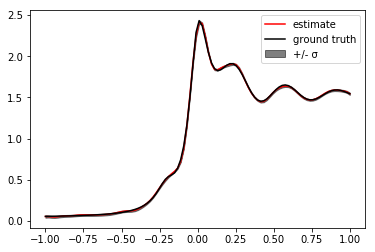

In [12]:
figure()
μ = m.predict_mean(torch.linspace(-1,1,100).unsqueeze(1)).detach().numpy().squeeze()
σ = np.sqrt(m.predict_var(torch.linspace(-1,1,100).unsqueeze(1)).detach().numpy().squeeze())
plot(torch.linspace(-1,1,100).numpy(), μ, color='r',label='estimate')
fill_between(torch.linspace(-1,1,100).numpy(), μ + σ, μ - σ,color='k',alpha=0.5,label='+/- σ')
plot(x[:100],y,color='k',label='ground truth')
legend()

In [13]:
m.stored_modules['m0'].value

Parameter containing:
tensor([0.8667], requires_grad=True)

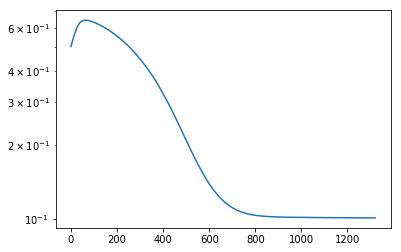

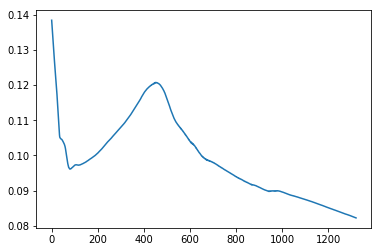

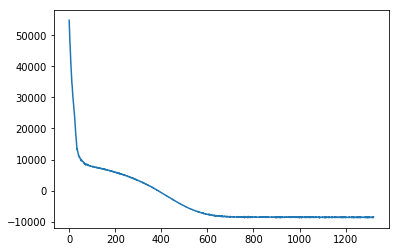

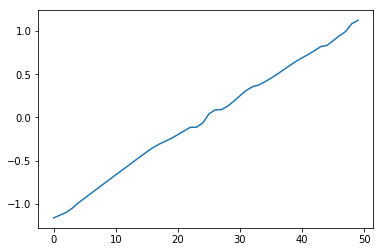

In [14]:
figure()
semilogy(Logger.val_dict['hyper_params.std_lik'])
figure()
plot(Logger.val_dict['stored_modules.K._lengthscale_storage'])
figure()
plot(Logger.val_dict['loss'])
figure()
plot(np.sort(m.hyper_params['u'].detach().numpy().squeeze()))

## Example 1b:

1. Fully observed
2. Gaussian likelihood
3. MC evaluation of variational expectation (Reparameterization gradients)
4. 1D signal

In [15]:
class VFE_1D_Reparam(torch.nn.Module):
    def __init__(self, U, Ntotal, Nmc = 10, std_lik_init = 0.5, lenscale_init = 0.15, dtype=torch.get_default_dtype()):
        super().__init__()
        self.dtype = dtype
        #define the input parameters
        #posterior mean vector
        m0 = MeanSymbol('m0')
        m = Vector('m')
        #posterior variance vector parameter
        L = Matrix('L')
        #axes that kernels are evaluated on
        u = Vector('u')
        f = Vector('f')
        #Kernels
        #these are the symbols that go into the graph
        K = Kernel('K')
        #observations, arranged Nx1
        y = Vector('y')
        Ntotal = Constant(Ntotal)
        #and finally the standard deviation of the likelihood
        std_lik = Scalar('std_lik')
        jitter = Scalar('jitter')
        Nmc = Constant(Nmc)
        #generally there are parameters which require positivity. I use this transform for them:
        self._makepos = SoftplusTransform()
        
        ### KL loss graph ###
        kl_loss = kl(K, u, m0, L, m, jitter)
        self._kl_loss_expr = kl_loss
        graph = expr2graph(Label(String("kl_loss"), kl_loss))
        self._kl_loss_fun = graph2ast(graph, compiled=True, debug=False)
        
        ### Predict to f-space ###
        mf = mean(K, u, f, m0, m, jitter)
        graph = expr2graph(Label(String("mean_pred"), mf))
        self._mean_pred = graph2ast(graph, compiled=True, debug=False)
        varf = var_fullspace_diag(K, f) - var_subspace_diag(K, u, f, jitter) + var_posterior_diag(K, u, f, L, jitter)
        graph = expr2graph(Label(String("var_pred"), varf))
        self._var_pred = graph2ast(graph, compiled=True, debug=False)
        
        
        ### Gaussian Likelihood in f-space ###
        ϵ = StdNormalSample(mf,Nmc)
        z = Sqrt(varf)*ϵ + mf
        ve_loss = gaussian_likelihood(y, z, std_lik, Ntotal)
        self._ve_loss_expr = ve_loss
        graph = expr2graph(Label(String("ve_loss"), ve_loss))
        self._ve_loss_fun = graph2ast(graph, compiled=True, debug=False)
        
        #form the total loss
        loss = -ve_loss + kl_loss
        graph = expr2graph(Label(String("loss"), loss))
        self._loss_fun = graph2ast(graph, compiled=True, debug=False)
        
        
        
        #the actual storage tensors go here:
        with torch.no_grad():
            self.variational_params = torch.nn.ParameterDict({
                'm': torch.nn.Parameter(torch.randn((U,1),dtype=self.dtype)/U),
            })
            self.hyper_params = torch.nn.ParameterDict({
                'std_lik': torch.nn.Parameter(self._makepos.inv(torch.tensor([[std_lik_init]],dtype=self.dtype))),
                'u': torch.nn.Parameter(torch.linspace(-1,1,U,dtype=self.dtype).unsqueeze(1)),
                #fixed parameters go here:
                'jitter': torch.nn.Parameter(torch.tensor(1e-4,dtype=self.dtype), requires_grad=False)
            })

            #modules containing parameters go here:
            self.stored_modules = torch.nn.ModuleDict({
                'K': ARDRBFKernel(lengthscale=torch.tensor([[lenscale_init]])),
                'm0': ConstantMean(torch.tensor(0.)),
                })
        priorL = (self.stored_modules['K'](self.hyper_params['u'],self.hyper_params['u']) + 
                  torch.eye(U)*1e-4).cholesky()
        self.L = ConstrainedLowerTriangular(U)
        self.L.custom_initialization(priorL)
    def kl_loss(self):
        leaves = {
            **self.variational_params,
            **self.hyper_params,
            **self.stored_modules,
            'L': self.L()
        }
        result = self._kl_loss_fun(**leaves)
        return result.kl_loss
    def ve_loss(self, y, x):
        leaves = {
            'y': y,
            'f': x,
            **self.variational_params,
            **self.hyper_params,
            **self.stored_modules,
            'std_lik': self._makepos(self.hyper_params['std_lik']),
            'L': self.L()
        }
        result = self._ve_loss_fun(**leaves)
        return result.ve_loss
    def loss(self, y, x):
        leaves = {
            'y': y,
            'f': x,
            **self.variational_params,
            **self.hyper_params,
            **self.stored_modules,
            'std_lik': self._makepos(self.hyper_params['std_lik']),
            'L': self.L()
        }
        result = self._loss_fun(**leaves)
        return result.loss
    def predict_mean(self, x):
        leaves = {
            'f': x,
            **self.variational_params,
            **self.hyper_params,
            **self.stored_modules,
            'std_lik': self._makepos(self.hyper_params['std_lik']),
            'L': self.L()
        }
        result = self._mean_pred(**leaves)
        return result.mean_pred
    def predict_var(self, x):
        leaves = {
            'f': x,
            **self.variational_params,
            **self.hyper_params,
            **self.stored_modules,
            'std_lik': self._makepos(self.hyper_params['std_lik']),
            'L': self.L()
        }
        result = self._var_pred(**leaves)
        return result.var_pred


In [16]:
m = VFE_1D_Reparam(50,100*100,Nmc=10)
# m.cuda()
optimizer = torch.optim.Adam(m.parameters(),lr=1e-2)
epochs = 2000
scheduler = StepLR(optimizer,50,gamma=0.95)

data = TensorDataset(torch.from_numpy(x.astype('float32')), torch.from_numpy(yc.astype('float32')))
Logger = ScalarLogger(m, {'hyper_params.std_lik': m._makepos,
                          'stored_modules.K._lengthscale_storage': m._makepos,
                          'stored_modules.K._amplitude_storage': m._makepos},
                     extra_keys={'loss': lambda x: x,
                                'step_size': lambda x: x})

for i in range(epochs):
    d = DataLoader(dataset=data, shuffle=True, batch_size=5000)
    for (xb,yb) in d:
#         xbc, ybc = xb.cuda(), yb.cuda()
        optimizer.zero_grad()
        loss = m.loss(yb, xb)
        loss.backward()
        optimizer.step()
        Logger(extra_vals=[float(loss), float(optimizer.param_groups[0]['lr'])])
    scheduler.step()
    print(Logger.report("epoch {:d}: ".format(i)))
        

Module path:  /Users/fdfuller/SLAC National Accelerator Laboratory/Fuller Group - Documents/Code/Frank/torchgp/notebooks/reparam/.compiled/90aa7d00bb838b54.py
Module path:  /Users/fdfuller/SLAC National Accelerator Laboratory/Fuller Group - Documents/Code/Frank/torchgp/notebooks/reparam/.compiled/078818802d755c5c.py
Module path:  /Users/fdfuller/SLAC National Accelerator Laboratory/Fuller Group - Documents/Code/Frank/torchgp/notebooks/reparam/.compiled/f31ae3cd60b738d7.py
Module path:  /Users/fdfuller/SLAC National Accelerator Laboratory/Fuller Group - Documents/Code/Frank/torchgp/notebooks/reparam/.compiled/8e4e75735229e234.py
Module path:  /Users/fdfuller/SLAC National Accelerator Laboratory/Fuller Group - Documents/Code/Frank/torchgp/notebooks/reparam/.compiled/7ec679bd674da7b3.py
epoch 0: hyper_params.std_lik: 0.507911, stored_modules.K._lengthscale_storage: 0.137494, stored_modules.K._amplitude_storage: 0.691479, loss: 52992, step_size: 0.01, 
epoch 1: hyper_params.std_lik: 0.5158

epoch 44: hyper_params.std_lik: 0.645931, stored_modules.K._lengthscale_storage: 0.112235, stored_modules.K._amplitude_storage: 0.720032, loss: 8304.31, step_size: 0.01, 
epoch 45: hyper_params.std_lik: 0.64515, stored_modules.K._lengthscale_storage: 0.112476, stored_modules.K._amplitude_storage: 0.717348, loss: 8259.52, step_size: 0.01, 
epoch 46: hyper_params.std_lik: 0.644324, stored_modules.K._lengthscale_storage: 0.112712, stored_modules.K._amplitude_storage: 0.714853, loss: 8175.26, step_size: 0.01, 
epoch 47: hyper_params.std_lik: 0.643452, stored_modules.K._lengthscale_storage: 0.112946, stored_modules.K._amplitude_storage: 0.712611, loss: 8152.9, step_size: 0.01, 
epoch 48: hyper_params.std_lik: 0.642538, stored_modules.K._lengthscale_storage: 0.113155, stored_modules.K._amplitude_storage: 0.710476, loss: 8188.41, step_size: 0.01, 
epoch 49: hyper_params.std_lik: 0.641589, stored_modules.K._lengthscale_storage: 0.113357, stored_modules.K._amplitude_storage: 0.708563, loss: 796

epoch 92: hyper_params.std_lik: 0.581366, stored_modules.K._lengthscale_storage: 0.1165, stored_modules.K._amplitude_storage: 0.689987, loss: 6546.23, step_size: 0.0095, 
epoch 93: hyper_params.std_lik: 0.579597, stored_modules.K._lengthscale_storage: 0.116533, stored_modules.K._amplitude_storage: 0.689936, loss: 6519.16, step_size: 0.0095, 
epoch 94: hyper_params.std_lik: 0.577813, stored_modules.K._lengthscale_storage: 0.11654, stored_modules.K._amplitude_storage: 0.69007, loss: 6490.02, step_size: 0.0095, 
epoch 95: hyper_params.std_lik: 0.576018, stored_modules.K._lengthscale_storage: 0.116555, stored_modules.K._amplitude_storage: 0.690108, loss: 6394.49, step_size: 0.0095, 
epoch 96: hyper_params.std_lik: 0.574206, stored_modules.K._lengthscale_storage: 0.116578, stored_modules.K._amplitude_storage: 0.69011, loss: 6449.03, step_size: 0.0095, 
epoch 97: hyper_params.std_lik: 0.572382, stored_modules.K._lengthscale_storage: 0.116576, stored_modules.K._amplitude_storage: 0.690249, lo

epoch 140: hyper_params.std_lik: 0.487308, stored_modules.K._lengthscale_storage: 0.11608, stored_modules.K._amplitude_storage: 0.687305, loss: 4455.37, step_size: 0.009025, 
epoch 141: hyper_params.std_lik: 0.485112, stored_modules.K._lengthscale_storage: 0.116049, stored_modules.K._amplitude_storage: 0.687074, loss: 4396.91, step_size: 0.009025, 
epoch 142: hyper_params.std_lik: 0.482906, stored_modules.K._lengthscale_storage: 0.116032, stored_modules.K._amplitude_storage: 0.68673, loss: 4368.42, step_size: 0.009025, 
epoch 143: hyper_params.std_lik: 0.480696, stored_modules.K._lengthscale_storage: 0.116009, stored_modules.K._amplitude_storage: 0.686431, loss: 4218.49, step_size: 0.009025, 
epoch 144: hyper_params.std_lik: 0.478475, stored_modules.K._lengthscale_storage: 0.115987, stored_modules.K._amplitude_storage: 0.686123, loss: 4274.04, step_size: 0.009025, 
epoch 145: hyper_params.std_lik: 0.476247, stored_modules.K._lengthscale_storage: 0.115991, stored_modules.K._amplitude_st

epoch 187: hyper_params.std_lik: 0.380829, stored_modules.K._lengthscale_storage: 0.117665, stored_modules.K._amplitude_storage: 0.668508, loss: 1631.91, step_size: 0.00857375, 
epoch 188: hyper_params.std_lik: 0.378467, stored_modules.K._lengthscale_storage: 0.117749, stored_modules.K._amplitude_storage: 0.667918, loss: 1535, step_size: 0.00857375, 
epoch 189: hyper_params.std_lik: 0.376099, stored_modules.K._lengthscale_storage: 0.117831, stored_modules.K._amplitude_storage: 0.667357, loss: 1462.76, step_size: 0.00857375, 
epoch 190: hyper_params.std_lik: 0.373729, stored_modules.K._lengthscale_storage: 0.117944, stored_modules.K._amplitude_storage: 0.666704, loss: 1317.46, step_size: 0.00857375, 
epoch 191: hyper_params.std_lik: 0.371352, stored_modules.K._lengthscale_storage: 0.118022, stored_modules.K._amplitude_storage: 0.666223, loss: 1270.47, step_size: 0.00857375, 
epoch 192: hyper_params.std_lik: 0.368971, stored_modules.K._lengthscale_storage: 0.118098, stored_modules.K._amp

epoch 233: hyper_params.std_lik: 0.274295, stored_modules.K._lengthscale_storage: 0.118872, stored_modules.K._amplitude_storage: 0.659046, loss: -2181.69, step_size: 0.00814506, 
epoch 234: hyper_params.std_lik: 0.272026, stored_modules.K._lengthscale_storage: 0.118753, stored_modules.K._amplitude_storage: 0.659687, loss: -2219.82, step_size: 0.00814506, 
epoch 235: hyper_params.std_lik: 0.269765, stored_modules.K._lengthscale_storage: 0.118602, stored_modules.K._amplitude_storage: 0.660496, loss: -2366.55, step_size: 0.00814506, 
epoch 236: hyper_params.std_lik: 0.267505, stored_modules.K._lengthscale_storage: 0.118516, stored_modules.K._amplitude_storage: 0.66104, loss: -2328.05, step_size: 0.00814506, 
epoch 237: hyper_params.std_lik: 0.265255, stored_modules.K._lengthscale_storage: 0.118386, stored_modules.K._amplitude_storage: 0.661746, loss: -2457.8, step_size: 0.00814506, 
epoch 238: hyper_params.std_lik: 0.263014, stored_modules.K._lengthscale_storage: 0.118369, stored_modules.

epoch 279: hyper_params.std_lik: 0.183899, stored_modules.K._lengthscale_storage: 0.117647, stored_modules.K._amplitude_storage: 0.670036, loss: -5786.11, step_size: 0.00773781, 
epoch 280: hyper_params.std_lik: 0.182309, stored_modules.K._lengthscale_storage: 0.117545, stored_modules.K._amplitude_storage: 0.670533, loss: -5864.97, step_size: 0.00773781, 
epoch 281: hyper_params.std_lik: 0.180737, stored_modules.K._lengthscale_storage: 0.11733, stored_modules.K._amplitude_storage: 0.671536, loss: -5976.28, step_size: 0.00773781, 
epoch 282: hyper_params.std_lik: 0.179181, stored_modules.K._lengthscale_storage: 0.117204, stored_modules.K._amplitude_storage: 0.67218, loss: -5983.37, step_size: 0.00773781, 
epoch 283: hyper_params.std_lik: 0.177645, stored_modules.K._lengthscale_storage: 0.116989, stored_modules.K._amplitude_storage: 0.673185, loss: -6072.21, step_size: 0.00773781, 
epoch 284: hyper_params.std_lik: 0.176125, stored_modules.K._lengthscale_storage: 0.116855, stored_modules.

epoch 325: hyper_params.std_lik: 0.130652, stored_modules.K._lengthscale_storage: 0.108745, stored_modules.K._amplitude_storage: 0.712915, loss: -7836.14, step_size: 0.00735092, 
epoch 326: hyper_params.std_lik: 0.129909, stored_modules.K._lengthscale_storage: 0.108545, stored_modules.K._amplitude_storage: 0.713773, loss: -7923.26, step_size: 0.00735092, 
epoch 327: hyper_params.std_lik: 0.129182, stored_modules.K._lengthscale_storage: 0.108513, stored_modules.K._amplitude_storage: 0.713924, loss: -7974.66, step_size: 0.00735092, 
epoch 328: hyper_params.std_lik: 0.128468, stored_modules.K._lengthscale_storage: 0.108395, stored_modules.K._amplitude_storage: 0.714495, loss: -7938.85, step_size: 0.00735092, 
epoch 329: hyper_params.std_lik: 0.127767, stored_modules.K._lengthscale_storage: 0.108215, stored_modules.K._amplitude_storage: 0.715383, loss: -7890.33, step_size: 0.00735092, 
epoch 330: hyper_params.std_lik: 0.127081, stored_modules.K._lengthscale_storage: 0.108153, stored_module

epoch 371: hyper_params.std_lik: 0.109313, stored_modules.K._lengthscale_storage: 0.100544, stored_modules.K._amplitude_storage: 0.743213, loss: -8458, step_size: 0.00698337, 
epoch 372: hyper_params.std_lik: 0.109058, stored_modules.K._lengthscale_storage: 0.100321, stored_modules.K._amplitude_storage: 0.743815, loss: -8459.48, step_size: 0.00698337, 
epoch 373: hyper_params.std_lik: 0.10881, stored_modules.K._lengthscale_storage: 0.100164, stored_modules.K._amplitude_storage: 0.744043, loss: -8462.47, step_size: 0.00698337, 
epoch 374: hyper_params.std_lik: 0.10857, stored_modules.K._lengthscale_storage: 0.100001, stored_modules.K._amplitude_storage: 0.744293, loss: -8592.65, step_size: 0.00698337, 
epoch 375: hyper_params.std_lik: 0.108335, stored_modules.K._lengthscale_storage: 0.099825, stored_modules.K._amplitude_storage: 0.74466, loss: -8451.97, step_size: 0.00698337, 
epoch 376: hyper_params.std_lik: 0.108105, stored_modules.K._lengthscale_storage: 0.0997457, stored_modules.K._

epoch 417: hyper_params.std_lik: 0.102692, stored_modules.K._lengthscale_storage: 0.0970697, stored_modules.K._amplitude_storage: 0.747189, loss: -8519.85, step_size: 0.0066342, 
epoch 418: hyper_params.std_lik: 0.102629, stored_modules.K._lengthscale_storage: 0.0970303, stored_modules.K._amplitude_storage: 0.746997, loss: -8656.84, step_size: 0.0066342, 
epoch 419: hyper_params.std_lik: 0.102565, stored_modules.K._lengthscale_storage: 0.0969388, stored_modules.K._amplitude_storage: 0.747076, loss: -8472.57, step_size: 0.0066342, 
epoch 420: hyper_params.std_lik: 0.102506, stored_modules.K._lengthscale_storage: 0.0969129, stored_modules.K._amplitude_storage: 0.746795, loss: -8647.51, step_size: 0.0066342, 
epoch 421: hyper_params.std_lik: 0.102448, stored_modules.K._lengthscale_storage: 0.0968416, stored_modules.K._amplitude_storage: 0.746702, loss: -8497.17, step_size: 0.0066342, 
epoch 422: hyper_params.std_lik: 0.102395, stored_modules.K._lengthscale_storage: 0.0967801, stored_modul

epoch 463: hyper_params.std_lik: 0.101112, stored_modules.K._lengthscale_storage: 0.0948861, stored_modules.K._amplitude_storage: 0.7383, loss: -8677.72, step_size: 0.00630249, 
epoch 464: hyper_params.std_lik: 0.101095, stored_modules.K._lengthscale_storage: 0.094885, stored_modules.K._amplitude_storage: 0.737974, loss: -8659.81, step_size: 0.00630249, 
epoch 465: hyper_params.std_lik: 0.10108, stored_modules.K._lengthscale_storage: 0.0948214, stored_modules.K._amplitude_storage: 0.737952, loss: -8654.39, step_size: 0.00630249, 
epoch 466: hyper_params.std_lik: 0.101064, stored_modules.K._lengthscale_storage: 0.0948244, stored_modules.K._amplitude_storage: 0.737619, loss: -8636.61, step_size: 0.00630249, 
epoch 467: hyper_params.std_lik: 0.10105, stored_modules.K._lengthscale_storage: 0.0947838, stored_modules.K._amplitude_storage: 0.737568, loss: -8620.88, step_size: 0.00630249, 
epoch 468: hyper_params.std_lik: 0.101034, stored_modules.K._lengthscale_storage: 0.094772, stored_module

epoch 509: hyper_params.std_lik: 0.100768, stored_modules.K._lengthscale_storage: 0.0942837, stored_modules.K._amplitude_storage: 0.730386, loss: -8667.56, step_size: 0.00598737, 
epoch 510: hyper_params.std_lik: 0.100764, stored_modules.K._lengthscale_storage: 0.0942445, stored_modules.K._amplitude_storage: 0.730383, loss: -8674.24, step_size: 0.00598737, 
epoch 511: hyper_params.std_lik: 0.100759, stored_modules.K._lengthscale_storage: 0.0942393, stored_modules.K._amplitude_storage: 0.73032, loss: -8690.21, step_size: 0.00598737, 
epoch 512: hyper_params.std_lik: 0.100752, stored_modules.K._lengthscale_storage: 0.0942035, stored_modules.K._amplitude_storage: 0.730344, loss: -8532.04, step_size: 0.00598737, 
epoch 513: hyper_params.std_lik: 0.100746, stored_modules.K._lengthscale_storage: 0.0941847, stored_modules.K._amplitude_storage: 0.730263, loss: -8638.61, step_size: 0.00598737, 
epoch 514: hyper_params.std_lik: 0.100739, stored_modules.K._lengthscale_storage: 0.0941731, stored_m

epoch 555: hyper_params.std_lik: 0.100558, stored_modules.K._lengthscale_storage: 0.0932573, stored_modules.K._amplitude_storage: 0.72262, loss: -8727.37, step_size: 0.005688, 
epoch 556: hyper_params.std_lik: 0.100553, stored_modules.K._lengthscale_storage: 0.093231, stored_modules.K._amplitude_storage: 0.722334, loss: -8580.79, step_size: 0.005688, 
epoch 557: hyper_params.std_lik: 0.100549, stored_modules.K._lengthscale_storage: 0.0932012, stored_modules.K._amplitude_storage: 0.722214, loss: -8668.79, step_size: 0.005688, 
epoch 558: hyper_params.std_lik: 0.100544, stored_modules.K._lengthscale_storage: 0.0931738, stored_modules.K._amplitude_storage: 0.72208, loss: -8601.4, step_size: 0.005688, 
epoch 559: hyper_params.std_lik: 0.100542, stored_modules.K._lengthscale_storage: 0.0931412, stored_modules.K._amplitude_storage: 0.722018, loss: -8689.71, step_size: 0.005688, 
epoch 560: hyper_params.std_lik: 0.100539, stored_modules.K._lengthscale_storage: 0.0931172, stored_modules.K._amp

epoch 602: hyper_params.std_lik: 0.1004, stored_modules.K._lengthscale_storage: 0.0913584, stored_modules.K._amplitude_storage: 0.712537, loss: -8545.34, step_size: 0.0054036, 
epoch 603: hyper_params.std_lik: 0.100395, stored_modules.K._lengthscale_storage: 0.0912938, stored_modules.K._amplitude_storage: 0.712285, loss: -8623.62, step_size: 0.0054036, 
epoch 604: hyper_params.std_lik: 0.100392, stored_modules.K._lengthscale_storage: 0.0912451, stored_modules.K._amplitude_storage: 0.711978, loss: -8679.43, step_size: 0.0054036, 
epoch 605: hyper_params.std_lik: 0.100389, stored_modules.K._lengthscale_storage: 0.0911774, stored_modules.K._amplitude_storage: 0.711771, loss: -8676.11, step_size: 0.0054036, 
epoch 606: hyper_params.std_lik: 0.100385, stored_modules.K._lengthscale_storage: 0.0911254, stored_modules.K._amplitude_storage: 0.711501, loss: -8684.35, step_size: 0.0054036, 
epoch 607: hyper_params.std_lik: 0.100382, stored_modules.K._lengthscale_storage: 0.0910743, stored_modules

epoch 648: hyper_params.std_lik: 0.100303, stored_modules.K._lengthscale_storage: 0.0894412, stored_modules.K._amplitude_storage: 0.699405, loss: -8721.98, step_size: 0.0054036, 
epoch 649: hyper_params.std_lik: 0.100302, stored_modules.K._lengthscale_storage: 0.0894215, stored_modules.K._amplitude_storage: 0.699052, loss: -8601.09, step_size: 0.0054036, 
epoch 650: hyper_params.std_lik: 0.100303, stored_modules.K._lengthscale_storage: 0.089429, stored_modules.K._amplitude_storage: 0.698599, loss: -8680.23, step_size: 0.00513342, 
epoch 651: hyper_params.std_lik: 0.100304, stored_modules.K._lengthscale_storage: 0.0893848, stored_modules.K._amplitude_storage: 0.698384, loss: -8727.79, step_size: 0.00513342, 
epoch 652: hyper_params.std_lik: 0.100304, stored_modules.K._lengthscale_storage: 0.0893907, stored_modules.K._amplitude_storage: 0.69786, loss: -8693.17, step_size: 0.00513342, 
epoch 653: hyper_params.std_lik: 0.100303, stored_modules.K._lengthscale_storage: 0.0893656, stored_modu

epoch 694: hyper_params.std_lik: 0.100261, stored_modules.K._lengthscale_storage: 0.0886299, stored_modules.K._amplitude_storage: 0.682473, loss: -8644.78, step_size: 0.00513342, 
epoch 695: hyper_params.std_lik: 0.100257, stored_modules.K._lengthscale_storage: 0.0886059, stored_modules.K._amplitude_storage: 0.682129, loss: -8641.36, step_size: 0.00513342, 
epoch 696: hyper_params.std_lik: 0.100254, stored_modules.K._lengthscale_storage: 0.0885618, stored_modules.K._amplitude_storage: 0.681901, loss: -8695.76, step_size: 0.00513342, 
epoch 697: hyper_params.std_lik: 0.100249, stored_modules.K._lengthscale_storage: 0.088543, stored_modules.K._amplitude_storage: 0.681521, loss: -8606.22, step_size: 0.00513342, 
epoch 698: hyper_params.std_lik: 0.100245, stored_modules.K._lengthscale_storage: 0.0885194, stored_modules.K._amplitude_storage: 0.68117, loss: -8666.96, step_size: 0.00513342, 
epoch 699: hyper_params.std_lik: 0.100244, stored_modules.K._lengthscale_storage: 0.0884812, stored_mo

epoch 740: hyper_params.std_lik: 0.100137, stored_modules.K._lengthscale_storage: 0.0874848, stored_modules.K._amplitude_storage: 0.670505, loss: -8673.03, step_size: 0.00487675, 
epoch 741: hyper_params.std_lik: 0.100135, stored_modules.K._lengthscale_storage: 0.0874637, stored_modules.K._amplitude_storage: 0.670348, loss: -8651.46, step_size: 0.00487675, 
epoch 742: hyper_params.std_lik: 0.100134, stored_modules.K._lengthscale_storage: 0.0874491, stored_modules.K._amplitude_storage: 0.67014, loss: -8720.07, step_size: 0.00487675, 
epoch 743: hyper_params.std_lik: 0.100132, stored_modules.K._lengthscale_storage: 0.0874265, stored_modules.K._amplitude_storage: 0.669954, loss: -8638.53, step_size: 0.00487675, 
epoch 744: hyper_params.std_lik: 0.100133, stored_modules.K._lengthscale_storage: 0.0873933, stored_modules.K._amplitude_storage: 0.669758, loss: -8783.54, step_size: 0.00487675, 
epoch 745: hyper_params.std_lik: 0.100131, stored_modules.K._lengthscale_storage: 0.0873802, stored_m

epoch 786: hyper_params.std_lik: 0.100079, stored_modules.K._lengthscale_storage: 0.0862277, stored_modules.K._amplitude_storage: 0.658727, loss: -8645.75, step_size: 0.00463291, 
epoch 787: hyper_params.std_lik: 0.100078, stored_modules.K._lengthscale_storage: 0.0861908, stored_modules.K._amplitude_storage: 0.658456, loss: -8663.25, step_size: 0.00463291, 
epoch 788: hyper_params.std_lik: 0.100079, stored_modules.K._lengthscale_storage: 0.0861611, stored_modules.K._amplitude_storage: 0.658117, loss: -8819.88, step_size: 0.00463291, 
epoch 789: hyper_params.std_lik: 0.100076, stored_modules.K._lengthscale_storage: 0.0861149, stored_modules.K._amplitude_storage: 0.657784, loss: -8598.16, step_size: 0.00463291, 
epoch 790: hyper_params.std_lik: 0.100074, stored_modules.K._lengthscale_storage: 0.0860716, stored_modules.K._amplitude_storage: 0.657434, loss: -8685.28, step_size: 0.00463291, 
epoch 791: hyper_params.std_lik: 0.100072, stored_modules.K._lengthscale_storage: 0.08604, stored_mo

epoch 832: hyper_params.std_lik: 0.0999935, stored_modules.K._lengthscale_storage: 0.084118, stored_modules.K._amplitude_storage: 0.646117, loss: -8651.83, step_size: 0.00440127, 
epoch 833: hyper_params.std_lik: 0.0999918, stored_modules.K._lengthscale_storage: 0.0840708, stored_modules.K._amplitude_storage: 0.645848, loss: -8667.7, step_size: 0.00440127, 
epoch 834: hyper_params.std_lik: 0.0999897, stored_modules.K._lengthscale_storage: 0.0840289, stored_modules.K._amplitude_storage: 0.645525, loss: -8636.06, step_size: 0.00440127, 
epoch 835: hyper_params.std_lik: 0.0999883, stored_modules.K._lengthscale_storage: 0.0839909, stored_modules.K._amplitude_storage: 0.64515, loss: -8689.06, step_size: 0.00440127, 
epoch 836: hyper_params.std_lik: 0.0999877, stored_modules.K._lengthscale_storage: 0.0839462, stored_modules.K._amplitude_storage: 0.644784, loss: -8771.41, step_size: 0.00440127, 
epoch 837: hyper_params.std_lik: 0.0999863, stored_modules.K._lengthscale_storage: 0.0838984, stor

epoch 878: hyper_params.std_lik: 0.0999169, stored_modules.K._lengthscale_storage: 0.0828346, stored_modules.K._amplitude_storage: 0.629111, loss: -8658.25, step_size: 0.0041812, 
epoch 879: hyper_params.std_lik: 0.0999134, stored_modules.K._lengthscale_storage: 0.082817, stored_modules.K._amplitude_storage: 0.628773, loss: -8623.17, step_size: 0.0041812, 
epoch 880: hyper_params.std_lik: 0.0999094, stored_modules.K._lengthscale_storage: 0.0828032, stored_modules.K._amplitude_storage: 0.628421, loss: -8554.38, step_size: 0.0041812, 
epoch 881: hyper_params.std_lik: 0.0999057, stored_modules.K._lengthscale_storage: 0.0827832, stored_modules.K._amplitude_storage: 0.628117, loss: -8549.35, step_size: 0.0041812, 
epoch 882: hyper_params.std_lik: 0.0999076, stored_modules.K._lengthscale_storage: 0.0827676, stored_modules.K._amplitude_storage: 0.627801, loss: -8838.23, step_size: 0.0041812, 
epoch 883: hyper_params.std_lik: 0.0999063, stored_modules.K._lengthscale_storage: 0.0827513, stored_

epoch 924: hyper_params.std_lik: 0.0998552, stored_modules.K._lengthscale_storage: 0.0821951, stored_modules.K._amplitude_storage: 0.613661, loss: -8808.48, step_size: 0.00397214, 
epoch 925: hyper_params.std_lik: 0.0998548, stored_modules.K._lengthscale_storage: 0.082182, stored_modules.K._amplitude_storage: 0.613283, loss: -8780.21, step_size: 0.00397214, 
epoch 926: hyper_params.std_lik: 0.0998522, stored_modules.K._lengthscale_storage: 0.0821663, stored_modules.K._amplitude_storage: 0.612907, loss: -8666.4, step_size: 0.00397214, 
epoch 927: hyper_params.std_lik: 0.0998513, stored_modules.K._lengthscale_storage: 0.0821499, stored_modules.K._amplitude_storage: 0.612551, loss: -8763.93, step_size: 0.00397214, 
epoch 928: hyper_params.std_lik: 0.0998454, stored_modules.K._lengthscale_storage: 0.0821339, stored_modules.K._amplitude_storage: 0.612168, loss: -8489.43, step_size: 0.00397214, 
epoch 929: hyper_params.std_lik: 0.0998444, stored_modules.K._lengthscale_storage: 0.0821173, sto

epoch 970: hyper_params.std_lik: 0.099796, stored_modules.K._lengthscale_storage: 0.081544, stored_modules.K._amplitude_storage: 0.598843, loss: -8653.23, step_size: 0.00377354, 
epoch 971: hyper_params.std_lik: 0.0997932, stored_modules.K._lengthscale_storage: 0.081528, stored_modules.K._amplitude_storage: 0.598528, loss: -8633.88, step_size: 0.00377354, 
epoch 972: hyper_params.std_lik: 0.0997936, stored_modules.K._lengthscale_storage: 0.0815115, stored_modules.K._amplitude_storage: 0.598193, loss: -8779.12, step_size: 0.00377354, 
epoch 973: hyper_params.std_lik: 0.0997933, stored_modules.K._lengthscale_storage: 0.0814943, stored_modules.K._amplitude_storage: 0.597865, loss: -8754.79, step_size: 0.00377354, 
epoch 974: hyper_params.std_lik: 0.0997936, stored_modules.K._lengthscale_storage: 0.0814781, stored_modules.K._amplitude_storage: 0.597521, loss: -8790.02, step_size: 0.00377354, 
epoch 975: hyper_params.std_lik: 0.0997916, stored_modules.K._lengthscale_storage: 0.0814636, stor

epoch 1016: hyper_params.std_lik: 0.0997734, stored_modules.K._lengthscale_storage: 0.0810129, stored_modules.K._amplitude_storage: 0.582392, loss: -8727.71, step_size: 0.00358486, 
epoch 1017: hyper_params.std_lik: 0.0997735, stored_modules.K._lengthscale_storage: 0.0810035, stored_modules.K._amplitude_storage: 0.582054, loss: -8723.03, step_size: 0.00358486, 
epoch 1018: hyper_params.std_lik: 0.0997725, stored_modules.K._lengthscale_storage: 0.0809926, stored_modules.K._amplitude_storage: 0.58172, loss: -8715.2, step_size: 0.00358486, 
epoch 1019: hyper_params.std_lik: 0.0997732, stored_modules.K._lengthscale_storage: 0.0809806, stored_modules.K._amplitude_storage: 0.58139, loss: -8814.85, step_size: 0.00358486, 
epoch 1020: hyper_params.std_lik: 0.0997713, stored_modules.K._lengthscale_storage: 0.0809676, stored_modules.K._amplitude_storage: 0.581049, loss: -8690.08, step_size: 0.00358486, 
epoch 1021: hyper_params.std_lik: 0.0997687, stored_modules.K._lengthscale_storage: 0.0809559

epoch 1062: hyper_params.std_lik: 0.0997546, stored_modules.K._lengthscale_storage: 0.0805431, stored_modules.K._amplitude_storage: 0.566096, loss: -8845.68, step_size: 0.00340562, 
epoch 1063: hyper_params.std_lik: 0.0997532, stored_modules.K._lengthscale_storage: 0.0805326, stored_modules.K._amplitude_storage: 0.565746, loss: -8705.71, step_size: 0.00340562, 
epoch 1064: hyper_params.std_lik: 0.0997525, stored_modules.K._lengthscale_storage: 0.0805232, stored_modules.K._amplitude_storage: 0.565392, loss: -8771.67, step_size: 0.00340562, 
epoch 1065: hyper_params.std_lik: 0.0997494, stored_modules.K._lengthscale_storage: 0.080513, stored_modules.K._amplitude_storage: 0.565032, loss: -8619.16, step_size: 0.00340562, 
epoch 1066: hyper_params.std_lik: 0.0997474, stored_modules.K._lengthscale_storage: 0.0805015, stored_modules.K._amplitude_storage: 0.564693, loss: -8678.75, step_size: 0.00340562, 
epoch 1067: hyper_params.std_lik: 0.0997443, stored_modules.K._lengthscale_storage: 0.08048

epoch 1108: hyper_params.std_lik: 0.0997314, stored_modules.K._lengthscale_storage: 0.0800401, stored_modules.K._amplitude_storage: 0.550303, loss: -8624.15, step_size: 0.00323534, 
epoch 1109: hyper_params.std_lik: 0.0997325, stored_modules.K._lengthscale_storage: 0.0800318, stored_modules.K._amplitude_storage: 0.549951, loss: -8740.43, step_size: 0.00323534, 
epoch 1110: hyper_params.std_lik: 0.099733, stored_modules.K._lengthscale_storage: 0.0800227, stored_modules.K._amplitude_storage: 0.549599, loss: -8738.69, step_size: 0.00323534, 
epoch 1111: hyper_params.std_lik: 0.0997342, stored_modules.K._lengthscale_storage: 0.0800125, stored_modules.K._amplitude_storage: 0.549248, loss: -8764.98, step_size: 0.00323534, 
epoch 1112: hyper_params.std_lik: 0.0997345, stored_modules.K._lengthscale_storage: 0.0800037, stored_modules.K._amplitude_storage: 0.548905, loss: -8710.29, step_size: 0.00323534, 
epoch 1113: hyper_params.std_lik: 0.0997357, stored_modules.K._lengthscale_storage: 0.07999

epoch 1154: hyper_params.std_lik: 0.0997292, stored_modules.K._lengthscale_storage: 0.0796069, stored_modules.K._amplitude_storage: 0.535494, loss: -8695.57, step_size: 0.00307357, 
epoch 1155: hyper_params.std_lik: 0.0997293, stored_modules.K._lengthscale_storage: 0.0795986, stored_modules.K._amplitude_storage: 0.535211, loss: -8679.65, step_size: 0.00307357, 
epoch 1156: hyper_params.std_lik: 0.0997299, stored_modules.K._lengthscale_storage: 0.0795914, stored_modules.K._amplitude_storage: 0.534924, loss: -8721.43, step_size: 0.00307357, 
epoch 1157: hyper_params.std_lik: 0.0997297, stored_modules.K._lengthscale_storage: 0.0795852, stored_modules.K._amplitude_storage: 0.53463, loss: -8725.66, step_size: 0.00307357, 
epoch 1158: hyper_params.std_lik: 0.0997307, stored_modules.K._lengthscale_storage: 0.0795766, stored_modules.K._amplitude_storage: 0.534353, loss: -8778.26, step_size: 0.00307357, 
epoch 1159: hyper_params.std_lik: 0.0997317, stored_modules.K._lengthscale_storage: 0.07956

epoch 1200: hyper_params.std_lik: 0.0997156, stored_modules.K._lengthscale_storage: 0.0791797, stored_modules.K._amplitude_storage: 0.521802, loss: -8713.66, step_size: 0.00291989, 
epoch 1201: hyper_params.std_lik: 0.0997167, stored_modules.K._lengthscale_storage: 0.0791685, stored_modules.K._amplitude_storage: 0.521525, loss: -8835.44, step_size: 0.00291989, 
epoch 1202: hyper_params.std_lik: 0.0997173, stored_modules.K._lengthscale_storage: 0.0791588, stored_modules.K._amplitude_storage: 0.521239, loss: -8829.03, step_size: 0.00291989, 
epoch 1203: hyper_params.std_lik: 0.0997147, stored_modules.K._lengthscale_storage: 0.0791485, stored_modules.K._amplitude_storage: 0.520951, loss: -8652.83, step_size: 0.00291989, 
epoch 1204: hyper_params.std_lik: 0.0997163, stored_modules.K._lengthscale_storage: 0.0791407, stored_modules.K._amplitude_storage: 0.520659, loss: -8851.45, step_size: 0.00291989, 
epoch 1205: hyper_params.std_lik: 0.0997157, stored_modules.K._lengthscale_storage: 0.0791

epoch 1246: hyper_params.std_lik: 0.0997053, stored_modules.K._lengthscale_storage: 0.0787907, stored_modules.K._amplitude_storage: 0.508536, loss: -8731.68, step_size: 0.00291989, 
epoch 1247: hyper_params.std_lik: 0.0997062, stored_modules.K._lengthscale_storage: 0.0787815, stored_modules.K._amplitude_storage: 0.508233, loss: -8781.32, step_size: 0.00291989, 
epoch 1248: hyper_params.std_lik: 0.0997059, stored_modules.K._lengthscale_storage: 0.0787721, stored_modules.K._amplitude_storage: 0.507937, loss: -8727.01, step_size: 0.00291989, 
epoch 1249: hyper_params.std_lik: 0.0997027, stored_modules.K._lengthscale_storage: 0.0787652, stored_modules.K._amplitude_storage: 0.507626, loss: -8550.76, step_size: 0.00291989, 
epoch 1250: hyper_params.std_lik: 0.0997025, stored_modules.K._lengthscale_storage: 0.0787569, stored_modules.K._amplitude_storage: 0.507336, loss: -8689.15, step_size: 0.0027739, 
epoch 1251: hyper_params.std_lik: 0.099703, stored_modules.K._lengthscale_storage: 0.078748

epoch 1292: hyper_params.std_lik: 0.0996892, stored_modules.K._lengthscale_storage: 0.0784493, stored_modules.K._amplitude_storage: 0.496136, loss: -8590.17, step_size: 0.0027739, 
epoch 1293: hyper_params.std_lik: 0.0996901, stored_modules.K._lengthscale_storage: 0.0784423, stored_modules.K._amplitude_storage: 0.495882, loss: -8734.68, step_size: 0.0027739, 
epoch 1294: hyper_params.std_lik: 0.0996923, stored_modules.K._lengthscale_storage: 0.0784344, stored_modules.K._amplitude_storage: 0.495624, loss: -8809.73, step_size: 0.0027739, 
epoch 1295: hyper_params.std_lik: 0.0996916, stored_modules.K._lengthscale_storage: 0.0784276, stored_modules.K._amplitude_storage: 0.495362, loss: -8681.01, step_size: 0.0027739, 
epoch 1296: hyper_params.std_lik: 0.0996909, stored_modules.K._lengthscale_storage: 0.0784204, stored_modules.K._amplitude_storage: 0.495097, loss: -8683.7, step_size: 0.0027739, 
epoch 1297: hyper_params.std_lik: 0.0996891, stored_modules.K._lengthscale_storage: 0.0784142, s

epoch 1338: hyper_params.std_lik: 0.0996839, stored_modules.K._lengthscale_storage: 0.0781596, stored_modules.K._amplitude_storage: 0.48469, loss: -8709.02, step_size: 0.0026352, 
epoch 1339: hyper_params.std_lik: 0.0996829, stored_modules.K._lengthscale_storage: 0.0781524, stored_modules.K._amplitude_storage: 0.48446, loss: -8708.41, step_size: 0.0026352, 
epoch 1340: hyper_params.std_lik: 0.0996834, stored_modules.K._lengthscale_storage: 0.0781474, stored_modules.K._amplitude_storage: 0.484213, loss: -8791.98, step_size: 0.0026352, 
epoch 1341: hyper_params.std_lik: 0.0996843, stored_modules.K._lengthscale_storage: 0.0781426, stored_modules.K._amplitude_storage: 0.48396, loss: -8813.86, step_size: 0.0026352, 
epoch 1342: hyper_params.std_lik: 0.0996859, stored_modules.K._lengthscale_storage: 0.0781346, stored_modules.K._amplitude_storage: 0.483729, loss: -8857.1, step_size: 0.0026352, 
epoch 1343: hyper_params.std_lik: 0.0996849, stored_modules.K._lengthscale_storage: 0.0781281, stor

epoch 1384: hyper_params.std_lik: 0.0996713, stored_modules.K._lengthscale_storage: 0.0779186, stored_modules.K._amplitude_storage: 0.474007, loss: -8780.11, step_size: 0.00250344, 
epoch 1385: hyper_params.std_lik: 0.0996703, stored_modules.K._lengthscale_storage: 0.0779136, stored_modules.K._amplitude_storage: 0.473794, loss: -8689.33, step_size: 0.00250344, 
epoch 1386: hyper_params.std_lik: 0.0996718, stored_modules.K._lengthscale_storage: 0.0779092, stored_modules.K._amplitude_storage: 0.473571, loss: -8801.79, step_size: 0.00250344, 
epoch 1387: hyper_params.std_lik: 0.0996702, stored_modules.K._lengthscale_storage: 0.0779015, stored_modules.K._amplitude_storage: 0.473353, loss: -8671.29, step_size: 0.00250344, 
epoch 1388: hyper_params.std_lik: 0.099671, stored_modules.K._lengthscale_storage: 0.0778962, stored_modules.K._amplitude_storage: 0.473127, loss: -8793.8, step_size: 0.00250344, 
epoch 1389: hyper_params.std_lik: 0.099669, stored_modules.K._lengthscale_storage: 0.0778916

epoch 1430: hyper_params.std_lik: 0.0996729, stored_modules.K._lengthscale_storage: 0.0777075, stored_modules.K._amplitude_storage: 0.463799, loss: -8697.99, step_size: 0.00237827, 
epoch 1431: hyper_params.std_lik: 0.0996712, stored_modules.K._lengthscale_storage: 0.0777054, stored_modules.K._amplitude_storage: 0.463575, loss: -8595.08, step_size: 0.00237827, 
epoch 1432: hyper_params.std_lik: 0.0996729, stored_modules.K._lengthscale_storage: 0.0777056, stored_modules.K._amplitude_storage: 0.463339, loss: -8761.97, step_size: 0.00237827, 
epoch 1433: hyper_params.std_lik: 0.0996737, stored_modules.K._lengthscale_storage: 0.077704, stored_modules.K._amplitude_storage: 0.463104, loss: -8744.38, step_size: 0.00237827, 
epoch 1434: hyper_params.std_lik: 0.0996729, stored_modules.K._lengthscale_storage: 0.0777002, stored_modules.K._amplitude_storage: 0.462874, loss: -8673.62, step_size: 0.00237827, 
epoch 1435: hyper_params.std_lik: 0.0996752, stored_modules.K._lengthscale_storage: 0.07769

epoch 1476: hyper_params.std_lik: 0.0996657, stored_modules.K._lengthscale_storage: 0.0775465, stored_modules.K._amplitude_storage: 0.454159, loss: -8787.72, step_size: 0.00225936, 
epoch 1477: hyper_params.std_lik: 0.0996655, stored_modules.K._lengthscale_storage: 0.0775428, stored_modules.K._amplitude_storage: 0.453955, loss: -8700.44, step_size: 0.00225936, 
epoch 1478: hyper_params.std_lik: 0.0996645, stored_modules.K._lengthscale_storage: 0.077539, stored_modules.K._amplitude_storage: 0.453753, loss: -8657.78, step_size: 0.00225936, 
epoch 1479: hyper_params.std_lik: 0.0996649, stored_modules.K._lengthscale_storage: 0.0775346, stored_modules.K._amplitude_storage: 0.453549, loss: -8741.58, step_size: 0.00225936, 
epoch 1480: hyper_params.std_lik: 0.0996662, stored_modules.K._lengthscale_storage: 0.0775329, stored_modules.K._amplitude_storage: 0.45334, loss: -8779.31, step_size: 0.00225936, 
epoch 1481: hyper_params.std_lik: 0.0996667, stored_modules.K._lengthscale_storage: 0.077529

epoch 1522: hyper_params.std_lik: 0.0996631, stored_modules.K._lengthscale_storage: 0.0773995, stored_modules.K._amplitude_storage: 0.445023, loss: -8772.15, step_size: 0.00214639, 
epoch 1523: hyper_params.std_lik: 0.0996606, stored_modules.K._lengthscale_storage: 0.077396, stored_modules.K._amplitude_storage: 0.444827, loss: -8601.87, step_size: 0.00214639, 
epoch 1524: hyper_params.std_lik: 0.0996614, stored_modules.K._lengthscale_storage: 0.0773929, stored_modules.K._amplitude_storage: 0.444627, loss: -8745.97, step_size: 0.00214639, 
epoch 1525: hyper_params.std_lik: 0.0996618, stored_modules.K._lengthscale_storage: 0.0773908, stored_modules.K._amplitude_storage: 0.444416, loss: -8721.72, step_size: 0.00214639, 
epoch 1526: hyper_params.std_lik: 0.0996636, stored_modules.K._lengthscale_storage: 0.0773857, stored_modules.K._amplitude_storage: 0.444212, loss: -8810.74, step_size: 0.00214639, 
epoch 1527: hyper_params.std_lik: 0.099664, stored_modules.K._lengthscale_storage: 0.077382

epoch 1568: hyper_params.std_lik: 0.0996488, stored_modules.K._lengthscale_storage: 0.0772472, stored_modules.K._amplitude_storage: 0.436359, loss: -8640.45, step_size: 0.00203907, 
epoch 1569: hyper_params.std_lik: 0.0996484, stored_modules.K._lengthscale_storage: 0.0772452, stored_modules.K._amplitude_storage: 0.436182, loss: -8674.89, step_size: 0.00203907, 
epoch 1570: hyper_params.std_lik: 0.0996493, stored_modules.K._lengthscale_storage: 0.0772421, stored_modules.K._amplitude_storage: 0.436006, loss: -8757.7, step_size: 0.00203907, 
epoch 1571: hyper_params.std_lik: 0.0996489, stored_modules.K._lengthscale_storage: 0.0772381, stored_modules.K._amplitude_storage: 0.43583, loss: -8683.75, step_size: 0.00203907, 
epoch 1572: hyper_params.std_lik: 0.0996483, stored_modules.K._lengthscale_storage: 0.077238, stored_modules.K._amplitude_storage: 0.435637, loss: -8650.68, step_size: 0.00203907, 
epoch 1573: hyper_params.std_lik: 0.0996465, stored_modules.K._lengthscale_storage: 0.0772362

epoch 1614: hyper_params.std_lik: 0.0996528, stored_modules.K._lengthscale_storage: 0.077123, stored_modules.K._amplitude_storage: 0.42815, loss: -8736.13, step_size: 0.00193711, 
epoch 1615: hyper_params.std_lik: 0.0996532, stored_modules.K._lengthscale_storage: 0.0771205, stored_modules.K._amplitude_storage: 0.427981, loss: -8761.45, step_size: 0.00193711, 
epoch 1616: hyper_params.std_lik: 0.0996545, stored_modules.K._lengthscale_storage: 0.0771159, stored_modules.K._amplitude_storage: 0.427817, loss: -8793.17, step_size: 0.00193711, 
epoch 1617: hyper_params.std_lik: 0.0996519, stored_modules.K._lengthscale_storage: 0.0771151, stored_modules.K._amplitude_storage: 0.427646, loss: -8616.39, step_size: 0.00193711, 
epoch 1618: hyper_params.std_lik: 0.0996525, stored_modules.K._lengthscale_storage: 0.0771149, stored_modules.K._amplitude_storage: 0.427472, loss: -8751.8, step_size: 0.00193711, 
epoch 1619: hyper_params.std_lik: 0.0996538, stored_modules.K._lengthscale_storage: 0.0771153

epoch 1660: hyper_params.std_lik: 0.0996508, stored_modules.K._lengthscale_storage: 0.0770118, stored_modules.K._amplitude_storage: 0.420464, loss: -8770.64, step_size: 0.00184026, 
epoch 1661: hyper_params.std_lik: 0.0996518, stored_modules.K._lengthscale_storage: 0.0770095, stored_modules.K._amplitude_storage: 0.420295, loss: -8763.32, step_size: 0.00184026, 
epoch 1662: hyper_params.std_lik: 0.0996522, stored_modules.K._lengthscale_storage: 0.0770091, stored_modules.K._amplitude_storage: 0.420122, loss: -8729.14, step_size: 0.00184026, 
epoch 1663: hyper_params.std_lik: 0.0996542, stored_modules.K._lengthscale_storage: 0.0770067, stored_modules.K._amplitude_storage: 0.419958, loss: -8816.39, step_size: 0.00184026, 
epoch 1664: hyper_params.std_lik: 0.0996576, stored_modules.K._lengthscale_storage: 0.0770019, stored_modules.K._amplitude_storage: 0.419801, loss: -8925.25, step_size: 0.00184026, 
epoch 1665: hyper_params.std_lik: 0.0996582, stored_modules.K._lengthscale_storage: 0.0770

epoch 1706: hyper_params.std_lik: 0.09965, stored_modules.K._lengthscale_storage: 0.0769032, stored_modules.K._amplitude_storage: 0.413315, loss: -8761.52, step_size: 0.00174825, 
epoch 1707: hyper_params.std_lik: 0.0996517, stored_modules.K._lengthscale_storage: 0.0768991, stored_modules.K._amplitude_storage: 0.413171, loss: -8824.24, step_size: 0.00174825, 
epoch 1708: hyper_params.std_lik: 0.0996509, stored_modules.K._lengthscale_storage: 0.0768965, stored_modules.K._amplitude_storage: 0.413021, loss: -8700.76, step_size: 0.00174825, 
epoch 1709: hyper_params.std_lik: 0.09965, stored_modules.K._lengthscale_storage: 0.0768938, stored_modules.K._amplitude_storage: 0.412873, loss: -8683.14, step_size: 0.00174825, 
epoch 1710: hyper_params.std_lik: 0.0996475, stored_modules.K._lengthscale_storage: 0.0768919, stored_modules.K._amplitude_storage: 0.412728, loss: -8591.73, step_size: 0.00174825, 
epoch 1711: hyper_params.std_lik: 0.0996492, stored_modules.K._lengthscale_storage: 0.076889, 

epoch 1752: hyper_params.std_lik: 0.0996471, stored_modules.K._lengthscale_storage: 0.0768029, stored_modules.K._amplitude_storage: 0.406506, loss: -8801.58, step_size: 0.00166083, 
epoch 1753: hyper_params.std_lik: 0.0996475, stored_modules.K._lengthscale_storage: 0.0768006, stored_modules.K._amplitude_storage: 0.406362, loss: -8777.91, step_size: 0.00166083, 
epoch 1754: hyper_params.std_lik: 0.0996458, stored_modules.K._lengthscale_storage: 0.0767998, stored_modules.K._amplitude_storage: 0.406216, loss: -8638.89, step_size: 0.00166083, 
epoch 1755: hyper_params.std_lik: 0.0996455, stored_modules.K._lengthscale_storage: 0.0768003, stored_modules.K._amplitude_storage: 0.406064, loss: -8682.78, step_size: 0.00166083, 
epoch 1756: hyper_params.std_lik: 0.0996464, stored_modules.K._lengthscale_storage: 0.0767982, stored_modules.K._amplitude_storage: 0.405918, loss: -8750.69, step_size: 0.00166083, 
epoch 1757: hyper_params.std_lik: 0.0996452, stored_modules.K._lengthscale_storage: 0.0767

epoch 1798: hyper_params.std_lik: 0.0996411, stored_modules.K._lengthscale_storage: 0.0766853, stored_modules.K._amplitude_storage: 0.399899, loss: -8735.49, step_size: 0.00166083, 
epoch 1799: hyper_params.std_lik: 0.0996403, stored_modules.K._lengthscale_storage: 0.0766821, stored_modules.K._amplitude_storage: 0.399755, loss: -8686.31, step_size: 0.00166083, 
epoch 1800: hyper_params.std_lik: 0.0996423, stored_modules.K._lengthscale_storage: 0.0766797, stored_modules.K._amplitude_storage: 0.399617, loss: -8844.82, step_size: 0.00157779, 
epoch 1801: hyper_params.std_lik: 0.0996408, stored_modules.K._lengthscale_storage: 0.0766761, stored_modules.K._amplitude_storage: 0.399484, loss: -8654.56, step_size: 0.00157779, 
epoch 1802: hyper_params.std_lik: 0.0996418, stored_modules.K._lengthscale_storage: 0.0766738, stored_modules.K._amplitude_storage: 0.399347, loss: -8773.23, step_size: 0.00157779, 
epoch 1803: hyper_params.std_lik: 0.0996421, stored_modules.K._lengthscale_storage: 0.0766

epoch 1844: hyper_params.std_lik: 0.0996372, stored_modules.K._lengthscale_storage: 0.0765898, stored_modules.K._amplitude_storage: 0.393907, loss: -8752, step_size: 0.00157779, 
epoch 1845: hyper_params.std_lik: 0.099636, stored_modules.K._lengthscale_storage: 0.0765899, stored_modules.K._amplitude_storage: 0.393772, loss: -8698.86, step_size: 0.00157779, 
epoch 1846: hyper_params.std_lik: 0.0996358, stored_modules.K._lengthscale_storage: 0.0765866, stored_modules.K._amplitude_storage: 0.393651, loss: -8748.81, step_size: 0.00157779, 
epoch 1847: hyper_params.std_lik: 0.099636, stored_modules.K._lengthscale_storage: 0.0765852, stored_modules.K._amplitude_storage: 0.393519, loss: -8778.25, step_size: 0.00157779, 
epoch 1848: hyper_params.std_lik: 0.0996352, stored_modules.K._lengthscale_storage: 0.0765826, stored_modules.K._amplitude_storage: 0.393388, loss: -8733.04, step_size: 0.00157779, 
epoch 1849: hyper_params.std_lik: 0.0996362, stored_modules.K._lengthscale_storage: 0.0765811, 

epoch 1890: hyper_params.std_lik: 0.0996348, stored_modules.K._lengthscale_storage: 0.0764983, stored_modules.K._amplitude_storage: 0.388157, loss: -8800.3, step_size: 0.0014989, 
epoch 1891: hyper_params.std_lik: 0.0996373, stored_modules.K._lengthscale_storage: 0.0764935, stored_modules.K._amplitude_storage: 0.388045, loss: -8893.42, step_size: 0.0014989, 
epoch 1892: hyper_params.std_lik: 0.0996356, stored_modules.K._lengthscale_storage: 0.0764896, stored_modules.K._amplitude_storage: 0.387929, loss: -8686.94, step_size: 0.0014989, 
epoch 1893: hyper_params.std_lik: 0.0996361, stored_modules.K._lengthscale_storage: 0.076487, stored_modules.K._amplitude_storage: 0.387808, loss: -8779.97, step_size: 0.0014989, 
epoch 1894: hyper_params.std_lik: 0.0996383, stored_modules.K._lengthscale_storage: 0.0764874, stored_modules.K._amplitude_storage: 0.387681, loss: -8866.45, step_size: 0.0014989, 
epoch 1895: hyper_params.std_lik: 0.0996373, stored_modules.K._lengthscale_storage: 0.0764844, st

epoch 1936: hyper_params.std_lik: 0.099637, stored_modules.K._lengthscale_storage: 0.0764076, stored_modules.K._amplitude_storage: 0.382977, loss: -8863.18, step_size: 0.00142396, 
epoch 1937: hyper_params.std_lik: 0.0996367, stored_modules.K._lengthscale_storage: 0.076407, stored_modules.K._amplitude_storage: 0.382868, loss: -8710.96, step_size: 0.00142396, 
epoch 1938: hyper_params.std_lik: 0.0996374, stored_modules.K._lengthscale_storage: 0.0764057, stored_modules.K._amplitude_storage: 0.382766, loss: -8737.72, step_size: 0.00142396, 
epoch 1939: hyper_params.std_lik: 0.0996373, stored_modules.K._lengthscale_storage: 0.0764036, stored_modules.K._amplitude_storage: 0.382664, loss: -8705.79, step_size: 0.00142396, 
epoch 1940: hyper_params.std_lik: 0.0996389, stored_modules.K._lengthscale_storage: 0.0764015, stored_modules.K._amplitude_storage: 0.382558, loss: -8807.51, step_size: 0.00142396, 
epoch 1941: hyper_params.std_lik: 0.0996405, stored_modules.K._lengthscale_storage: 0.076400

epoch 1982: hyper_params.std_lik: 0.0996371, stored_modules.K._lengthscale_storage: 0.0763279, stored_modules.K._amplitude_storage: 0.378137, loss: -8654.09, step_size: 0.00135276, 
epoch 1983: hyper_params.std_lik: 0.0996387, stored_modules.K._lengthscale_storage: 0.0763271, stored_modules.K._amplitude_storage: 0.378031, loss: -8810.3, step_size: 0.00135276, 
epoch 1984: hyper_params.std_lik: 0.0996382, stored_modules.K._lengthscale_storage: 0.0763246, stored_modules.K._amplitude_storage: 0.37793, loss: -8712.56, step_size: 0.00135276, 
epoch 1985: hyper_params.std_lik: 0.0996369, stored_modules.K._lengthscale_storage: 0.0763235, stored_modules.K._amplitude_storage: 0.377824, loss: -8644.45, step_size: 0.00135276, 
epoch 1986: hyper_params.std_lik: 0.0996367, stored_modules.K._lengthscale_storage: 0.0763241, stored_modules.K._amplitude_storage: 0.37771, loss: -8706.76, step_size: 0.00135276, 
epoch 1987: hyper_params.std_lik: 0.0996367, stored_modules.K._lengthscale_storage: 0.0763206

In [17]:
m.cpu()

VFE_1D_Reparam(
  (variational_params): ParameterDict(  (m): Parameter containing: [torch.FloatTensor of size 50x1])
  (hyper_params): ParameterDict(
      (jitter): Parameter containing: [torch.FloatTensor of size ]
      (std_lik): Parameter containing: [torch.FloatTensor of size 1x1]
      (u): Parameter containing: [torch.FloatTensor of size 50x1]
  )
  (stored_modules): ModuleDict(
    (K): ARDRBFKernel(lengthscale=tensor([[0.0793]]), amplitude=0.45695021748542786)
    (m0): ConstantMean(value=0.9100810289382935)
  )
  (L): ConstrainedLowerTriangular()
)

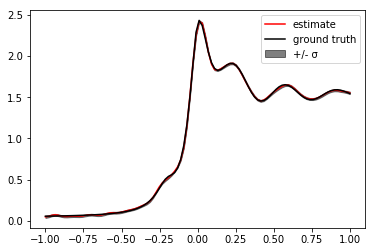

In [18]:
figure()
μ = m.predict_mean(torch.linspace(-1,1,100).unsqueeze(1)).detach().numpy().squeeze()
σ = np.sqrt(m.predict_var(torch.linspace(-1,1,100).unsqueeze(1)).detach().numpy().squeeze())
plot(torch.linspace(-1,1,100).numpy(), μ, color='r',label='estimate')
fill_between(torch.linspace(-1,1,100).numpy(), μ + σ, μ - σ,color='k',alpha=0.5,label='+/- σ')
plot(x[:100],y,color='k',label='ground truth')
legend()

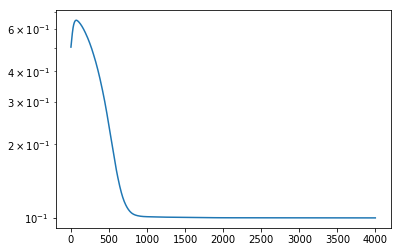

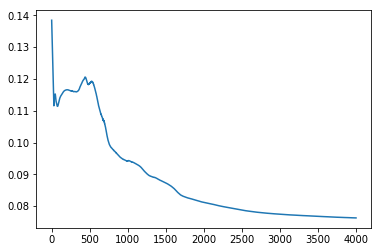

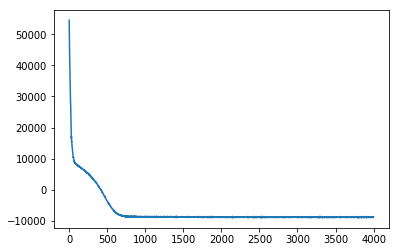

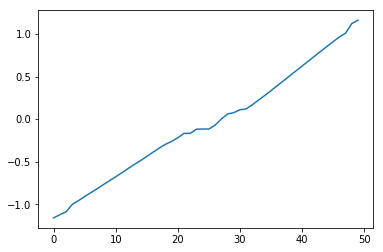

In [20]:
figure()
semilogy(Logger.val_dict['hyper_params.std_lik'])
figure()
plot(Logger.val_dict['stored_modules.K._lengthscale_storage'])
figure()
plot(Logger.val_dict['loss'])
figure()
plot(np.sort(m.hyper_params['u'].detach().numpy().squeeze()))

## Example 2a

1. 1D GPMM
2. Gaussian likelihood
3. Analytic evaluation of variational expectation

In [5]:
X,  yc, y = make_fake_herfd_weighted(10000, 100)

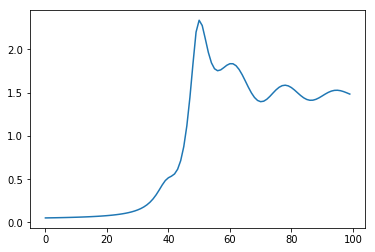

In [6]:
figure()
plot(y)

In [17]:
class VFE_1D_GPMM(torch.nn.Module):
    def __init__(self, U0, F0, Ntotal, std_lik_init = 0.5, lenscale_init = 0.05,
                 dtype=torch.get_default_dtype()):
        super().__init__()
        self.dtype = dtype
        m = Vector('m')
        mprior = MeanSymbol('mprior')
        L0 = Matrix('L0')
        u0 = Vector('u0')
        f0 = Vector('f0')
        K0 = Kernel('K0')
        y = Vector('y')
        X = Matrix('X')
        Ntotal = Constant(Ntotal)
        #and finally the standard deviation of the likelihood
        std_lik = Scalar('std_lik')
        jitter = Scalar('jitter')
        #generally there are parameters which require positivity. I use this transform for them:
        self._makepos = SoftplusTransform()
        
        ### KL loss graph ###
        kl_loss = kl(K0, u0, mprior, L0, m, jitter)
        self._kl_loss_expr = kl_loss
        graph = expr2graph(Label(String("kl_loss"), kl_loss))
        self._kl_loss_fun = graph2ast(graph, compiled=True, debug=False)
        
        ### Predict to weighted f-space ###
        mf = weighted_mean(K0, u0, f0, mprior, m, X, jitter)
        varf = weighted_var_fullspace_diag(K0, f0, X) - weighted_var_subspace_diag(K0, u0, f0, X, jitter) + \
                weighted_var_posterior_diag(K0, u0, f0, L0, X, jitter)
        
        ### Gaussian Likelihood in f-space ###
        ve_loss = analytic_gaussian_likelihood(y, mf, varf, std_lik, Ntotal)
        self._ve_loss_expr = ve_loss
        graph = expr2graph(Label(String("ve_loss"), ve_loss))
        self._ve_loss_fun = graph2ast(graph, compiled=True, debug=False)
        
        #form the total loss
        loss = -ve_loss + kl_loss
        graph = expr2graph(Label(String("loss"), loss))
        self._loss_fun = graph2ast(graph, compiled=True, debug=False)
        
        ### Predict to f-space ###
        mf = mean(K0, u0, f0, mprior, m, jitter)
        graph = expr2graph(Label(String("mean_pred"), mf))
        self._mean_pred = graph2ast(graph, compiled=True, debug=False)
        varf = var_fullspace_diag(K0, f0) - var_subspace_diag(K0, u0, f0, jitter) + \
                var_posterior_diag(K0, u0, f0, L0, jitter)
        graph = expr2graph(Label(String("var_pred"), varf))
        self._var_pred = graph2ast(graph, compiled=True, debug=False)
        
        
        #the actual storage tensors go here:
        with torch.no_grad():
            self.variational_params = torch.nn.ParameterDict({
                'm': torch.nn.Parameter(torch.randn((U0,1),dtype=self.dtype)/(U0)),
            })
            self.hyper_params = torch.nn.ParameterDict({
                'std_lik': torch.nn.Parameter(self._makepos.inv(torch.tensor([[std_lik_init]],dtype=self.dtype))),
                'u0': torch.nn.Parameter(torch.linspace(-1,1,U0,dtype=self.dtype).unsqueeze(1)),
                #fixed parameters go here:
                'jitter': torch.nn.Parameter(torch.tensor(1e-4,dtype=self.dtype), requires_grad=False),
                'f0': torch.nn.Parameter(torch.linspace(-1,1,F0,dtype=self.dtype).unsqueeze(1), requires_grad=False),
            })

            #modules containing parameters go here:
            self.stored_modules = torch.nn.ModuleDict({
                'K0': ARDRBFKernel(lengthscale=torch.tensor([[lenscale_init]])),
                'mprior': ConstantMean(torch.tensor(0.))
                })
        priorL0 = (self.stored_modules['K0'](self.hyper_params['u0'],self.hyper_params['u0']) + 
                  torch.eye(U0)*1e-4).cholesky()
        self.L0 = ConstrainedLowerTriangular(U0)
        self.L0.custom_initialization(priorL0)
    def kl_loss(self):
        leaves = {
            **self.variational_params,
            **self.hyper_params,
            **self.stored_modules,
            'L0': self.L0(),
        }
        result = self._kl_loss_fun(**leaves)
        return result.kl_loss
    def ve_loss(self, y, X):
        leaves = {
            'y': y,
            'X': X,
            **self.variational_params,
            **self.hyper_params,
            **self.stored_modules,
            'L0': self.L0(),
            'std_lik': self._makepos(self.hyper_params['std_lik'])
        }
        result = self._ve_loss_fun(**leaves)
        return result.ve_loss
    def loss(self, y, X):
        leaves = {
            'y': y,
            'X': X,
            **self.variational_params,
            **self.hyper_params,
            **self.stored_modules,
            'L0': self.L0(),
            'std_lik': self._makepos(self.hyper_params['std_lik'])
        }
        result = self._loss_fun(**leaves)
        return result.loss
    def predict_mean(self):
        leaves = {
            **self.variational_params,
            **self.hyper_params,
            **self.stored_modules,
            'L0': self.L0(),
            'std_lik': self._makepos(self.hyper_params['std_lik'])
        }
        result = self._mean_pred(**leaves)
        return result.mean_pred
    def predict_var(self):
        leaves = {
            **self.variational_params,
            **self.hyper_params,
            **self.stored_modules,
            'L0': self.L0(),
            'std_lik': self._makepos(self.hyper_params['std_lik'])
        }
        result = self._var_pred(**leaves)
        return result.var_pred

In [19]:
m = VFE_1D_GPMM(50,100,10000,std_lik_init=2.0,lenscale_init=0.15)
# m.hyper_params['u0'].requires_grad = False
# m.hyper_params['u1'].requires_grad = False
# m.stored_K['K0']._lengthscale_storage.requires_grad = False
# m.stored_K['K0']._amplitude_storage.requires_grad = False
# m.stored_K['K1']._lengthscale_storage.requires_grad = False
# m.stored_K['K1']._amplitude_storage.requires_grad = False
m.cuda()
optimizer = torch.optim.Adam(m.parameters(),lr=1e-2)
epochs = 2000
scheduler = StepLR(optimizer,50,gamma=0.95)

data = TensorDataset(torch.from_numpy(X.astype('float32')), torch.from_numpy(yc.astype('float32')))
Logger = ScalarLogger(m, {'hyper_params.std_lik': m._makepos,
                          'stored_modules.K0._lengthscale_storage': m._makepos,
                          'stored_modules.K0._amplitude_storage': m._makepos,
                          'stored_modules.mprior.value': lambda x: x},
                     extra_keys={'loss': lambda x: x,
                                'step_size': lambda x: x})

for i in range(epochs):
    d = DataLoader(dataset=data, shuffle=True, batch_size=1000)
    for Xb,yb in d:
        ybc, Xbc = yb.cuda(), Xb.cuda()
        optimizer.zero_grad()
        loss = m.loss(ybc,Xbc)
        loss.backward()
        optimizer.step()
        Logger(extra_vals=[float(loss), float(optimizer.param_groups[0]['lr'])])
    scheduler.step()
    print(Logger.report("epoch {:d}: ".format(i)))

Module path:  /home/fdfuller/work/torchgp/notebooks/reparam/.compiled/fe6235a412301eab.py
Module path:  /home/fdfuller/work/torchgp/notebooks/reparam/.compiled/94031118481783bf.py
Module path:  /home/fdfuller/work/torchgp/notebooks/reparam/.compiled/3e9310e412c15d17.py
Module path:  /home/fdfuller/work/torchgp/notebooks/reparam/.compiled/a9dd8fb166accca4.py
Module path:  /home/fdfuller/work/torchgp/notebooks/reparam/.compiled/9e30380974ec36ab.py
epoch 0: hyper_params.std_lik: 1.91387, stored_modules.K0._lengthscale_storage: 0.128787, stored_modules.K0._amplitude_storage: 0.739663, stored_modules.mprior.value: 0.0383692, loss: 17416.2, step_size: 0.01, 
epoch 1: hyper_params.std_lik: 1.8278, stored_modules.K0._lengthscale_storage: 0.120798, stored_modules.K0._amplitude_storage: 0.771144, stored_modules.mprior.value: 0.0778386, loss: 16849.3, step_size: 0.01, 
epoch 2: hyper_params.std_lik: 1.7413, stored_modules.K0._lengthscale_storage: 0.116299, stored_modules.K0._amplitude_storage: 0.

epoch 38: hyper_params.std_lik: 0.12186, stored_modules.K0._lengthscale_storage: 0.0719112, stored_modules.K0._amplitude_storage: 0.524282, stored_modules.mprior.value: 1.01657, loss: -7493.91, step_size: 0.01, 
epoch 39: hyper_params.std_lik: 0.119011, stored_modules.K0._lengthscale_storage: 0.0722374, stored_modules.K0._amplitude_storage: 0.522248, stored_modules.mprior.value: 1.01011, loss: -7573.75, step_size: 0.01, 
epoch 40: hyper_params.std_lik: 0.116645, stored_modules.K0._lengthscale_storage: 0.0725199, stored_modules.K0._amplitude_storage: 0.520621, stored_modules.mprior.value: 1.00603, loss: -7836.54, step_size: 0.01, 
epoch 41: hyper_params.std_lik: 0.114515, stored_modules.K0._lengthscale_storage: 0.0726346, stored_modules.K0._amplitude_storage: 0.519668, stored_modules.mprior.value: 1.004, loss: -7418.62, step_size: 0.01, 
epoch 42: hyper_params.std_lik: 0.112976, stored_modules.K0._lengthscale_storage: 0.0726567, stored_modules.K0._amplitude_storage: 0.518845, stored_mod

epoch 78: hyper_params.std_lik: 0.102442, stored_modules.K0._lengthscale_storage: 0.0827552, stored_modules.K0._amplitude_storage: 0.486929, stored_modules.mprior.value: 0.909196, loss: -8033.13, step_size: 0.0095, 
epoch 79: hyper_params.std_lik: 0.102415, stored_modules.K0._lengthscale_storage: 0.0828409, stored_modules.K0._amplitude_storage: 0.486482, stored_modules.mprior.value: 0.908296, loss: -8434.14, step_size: 0.0095, 
epoch 80: hyper_params.std_lik: 0.102552, stored_modules.K0._lengthscale_storage: 0.083093, stored_modules.K0._amplitude_storage: 0.485566, stored_modules.mprior.value: 0.905577, loss: -8249.4, step_size: 0.0095, 
epoch 81: hyper_params.std_lik: 0.102626, stored_modules.K0._lengthscale_storage: 0.0832226, stored_modules.K0._amplitude_storage: 0.485005, stored_modules.mprior.value: 0.904332, loss: -8515.09, step_size: 0.0095, 
epoch 82: hyper_params.std_lik: 0.102358, stored_modules.K0._lengthscale_storage: 0.0832761, stored_modules.K0._amplitude_storage: 0.48477

epoch 116: hyper_params.std_lik: 0.100848, stored_modules.K0._lengthscale_storage: 0.0856665, stored_modules.K0._amplitude_storage: 0.472168, stored_modules.mprior.value: 0.902936, loss: -8138.82, step_size: 0.009025, 
epoch 117: hyper_params.std_lik: 0.100943, stored_modules.K0._lengthscale_storage: 0.0858449, stored_modules.K0._amplitude_storage: 0.471317, stored_modules.mprior.value: 0.90267, loss: -8477.76, step_size: 0.009025, 
epoch 118: hyper_params.std_lik: 0.101079, stored_modules.K0._lengthscale_storage: 0.0859431, stored_modules.K0._amplitude_storage: 0.470537, stored_modules.mprior.value: 0.903501, loss: -8502.73, step_size: 0.009025, 
epoch 119: hyper_params.std_lik: 0.100987, stored_modules.K0._lengthscale_storage: 0.0859586, stored_modules.K0._amplitude_storage: 0.469986, stored_modules.mprior.value: 0.904567, loss: -8920.53, step_size: 0.009025, 
epoch 120: hyper_params.std_lik: 0.1008, stored_modules.K0._lengthscale_storage: 0.0860845, stored_modules.K0._amplitude_stor

epoch 154: hyper_params.std_lik: 0.100432, stored_modules.K0._lengthscale_storage: 0.0886575, stored_modules.K0._amplitude_storage: 0.443591, stored_modules.mprior.value: 0.921053, loss: -8458.95, step_size: 0.00857375, 
epoch 155: hyper_params.std_lik: 0.100531, stored_modules.K0._lengthscale_storage: 0.0888119, stored_modules.K0._amplitude_storage: 0.442602, stored_modules.mprior.value: 0.920718, loss: -8768.2, step_size: 0.00857375, 
epoch 156: hyper_params.std_lik: 0.100343, stored_modules.K0._lengthscale_storage: 0.0889253, stored_modules.K0._amplitude_storage: 0.441695, stored_modules.mprior.value: 0.920804, loss: -8566.11, step_size: 0.00857375, 
epoch 157: hyper_params.std_lik: 0.10037, stored_modules.K0._lengthscale_storage: 0.0889122, stored_modules.K0._amplitude_storage: 0.441032, stored_modules.mprior.value: 0.921619, loss: -8299.28, step_size: 0.00857375, 
epoch 158: hyper_params.std_lik: 0.100583, stored_modules.K0._lengthscale_storage: 0.0889901, stored_modules.K0._ampli

epoch 192: hyper_params.std_lik: 0.10035, stored_modules.K0._lengthscale_storage: 0.0917125, stored_modules.K0._amplitude_storage: 0.410693, stored_modules.mprior.value: 0.92237, loss: -8900.97, step_size: 0.00857375, 
epoch 193: hyper_params.std_lik: 0.10042, stored_modules.K0._lengthscale_storage: 0.0917578, stored_modules.K0._amplitude_storage: 0.409929, stored_modules.mprior.value: 0.922951, loss: -8901.35, step_size: 0.00857375, 
epoch 194: hyper_params.std_lik: 0.100349, stored_modules.K0._lengthscale_storage: 0.0917934, stored_modules.K0._amplitude_storage: 0.409179, stored_modules.mprior.value: 0.923524, loss: -8509.03, step_size: 0.00857375, 
epoch 195: hyper_params.std_lik: 0.100374, stored_modules.K0._lengthscale_storage: 0.091914, stored_modules.K0._amplitude_storage: 0.40828, stored_modules.mprior.value: 0.924604, loss: -8911.99, step_size: 0.00857375, 
epoch 196: hyper_params.std_lik: 0.100405, stored_modules.K0._lengthscale_storage: 0.0920303, stored_modules.K0._amplitud

epoch 230: hyper_params.std_lik: 0.100289, stored_modules.K0._lengthscale_storage: 0.0939128, stored_modules.K0._amplitude_storage: 0.382589, stored_modules.mprior.value: 0.928761, loss: -9123.11, step_size: 0.00814506, 
epoch 231: hyper_params.std_lik: 0.0998668, stored_modules.K0._lengthscale_storage: 0.0940096, stored_modules.K0._amplitude_storage: 0.381851, stored_modules.mprior.value: 0.929112, loss: -8646.54, step_size: 0.00814506, 
epoch 232: hyper_params.std_lik: 0.100378, stored_modules.K0._lengthscale_storage: 0.0941161, stored_modules.K0._amplitude_storage: 0.381091, stored_modules.mprior.value: 0.929927, loss: -8797.01, step_size: 0.00814506, 
epoch 233: hyper_params.std_lik: 0.100327, stored_modules.K0._lengthscale_storage: 0.0941898, stored_modules.K0._amplitude_storage: 0.380384, stored_modules.mprior.value: 0.927948, loss: -8525.27, step_size: 0.00814506, 
epoch 234: hyper_params.std_lik: 0.100066, stored_modules.K0._lengthscale_storage: 0.0941942, stored_modules.K0._am

epoch 268: hyper_params.std_lik: 0.100236, stored_modules.K0._lengthscale_storage: 0.0954473, stored_modules.K0._amplitude_storage: 0.360532, stored_modules.mprior.value: 0.931477, loss: -8746.25, step_size: 0.00773781, 
epoch 269: hyper_params.std_lik: 0.100231, stored_modules.K0._lengthscale_storage: 0.0954663, stored_modules.K0._amplitude_storage: 0.360051, stored_modules.mprior.value: 0.931127, loss: -8404.81, step_size: 0.00773781, 
epoch 270: hyper_params.std_lik: 0.100516, stored_modules.K0._lengthscale_storage: 0.0954996, stored_modules.K0._amplitude_storage: 0.359552, stored_modules.mprior.value: 0.930481, loss: -8975.27, step_size: 0.00773781, 
epoch 271: hyper_params.std_lik: 0.100399, stored_modules.K0._lengthscale_storage: 0.0955222, stored_modules.K0._amplitude_storage: 0.359068, stored_modules.mprior.value: 0.930819, loss: -9051.78, step_size: 0.00773781, 
epoch 272: hyper_params.std_lik: 0.0998955, stored_modules.K0._lengthscale_storage: 0.0955496, stored_modules.K0._am

epoch 306: hyper_params.std_lik: 0.100372, stored_modules.K0._lengthscale_storage: 0.0956136, stored_modules.K0._amplitude_storage: 0.346232, stored_modules.mprior.value: 0.933037, loss: -8522.57, step_size: 0.00735092, 
epoch 307: hyper_params.std_lik: 0.10057, stored_modules.K0._lengthscale_storage: 0.0956505, stored_modules.K0._amplitude_storage: 0.345885, stored_modules.mprior.value: 0.932858, loss: -9001.76, step_size: 0.00735092, 
epoch 308: hyper_params.std_lik: 0.100189, stored_modules.K0._lengthscale_storage: 0.0956778, stored_modules.K0._amplitude_storage: 0.345546, stored_modules.mprior.value: 0.932556, loss: -8761.37, step_size: 0.00735092, 
epoch 309: hyper_params.std_lik: 0.100092, stored_modules.K0._lengthscale_storage: 0.0956837, stored_modules.K0._amplitude_storage: 0.345243, stored_modules.mprior.value: 0.931934, loss: -8577.1, step_size: 0.00735092, 
epoch 310: hyper_params.std_lik: 0.100035, stored_modules.K0._lengthscale_storage: 0.095686, stored_modules.K0._amplit

epoch 344: hyper_params.std_lik: 0.0999123, stored_modules.K0._lengthscale_storage: 0.0955246, stored_modules.K0._amplitude_storage: 0.336011, stored_modules.mprior.value: 0.931638, loss: -8972.06, step_size: 0.00735092, 
epoch 345: hyper_params.std_lik: 0.0997841, stored_modules.K0._lengthscale_storage: 0.0954763, stored_modules.K0._amplitude_storage: 0.335894, stored_modules.mprior.value: 0.93138, loss: -8373.18, step_size: 0.00735092, 
epoch 346: hyper_params.std_lik: 0.100663, stored_modules.K0._lengthscale_storage: 0.0954781, stored_modules.K0._amplitude_storage: 0.335667, stored_modules.mprior.value: 0.932142, loss: -8909.69, step_size: 0.00735092, 
epoch 347: hyper_params.std_lik: 0.10052, stored_modules.K0._lengthscale_storage: 0.0954198, stored_modules.K0._amplitude_storage: 0.335569, stored_modules.mprior.value: 0.932761, loss: -8746.41, step_size: 0.00735092, 
epoch 348: hyper_params.std_lik: 0.0999752, stored_modules.K0._lengthscale_storage: 0.095432, stored_modules.K0._amp

epoch 382: hyper_params.std_lik: 0.10041, stored_modules.K0._lengthscale_storage: 0.0961653, stored_modules.K0._amplitude_storage: 0.329292, stored_modules.mprior.value: 0.93234, loss: -8623.4, step_size: 0.00698337, 
epoch 383: hyper_params.std_lik: 0.10045, stored_modules.K0._lengthscale_storage: 0.0960642, stored_modules.K0._amplitude_storage: 0.329372, stored_modules.mprior.value: 0.932062, loss: -9257.98, step_size: 0.00698337, 
epoch 384: hyper_params.std_lik: 0.10004, stored_modules.K0._lengthscale_storage: 0.0960235, stored_modules.K0._amplitude_storage: 0.329381, stored_modules.mprior.value: 0.931993, loss: -8559.55, step_size: 0.00698337, 
epoch 385: hyper_params.std_lik: 0.0999697, stored_modules.K0._lengthscale_storage: 0.0959912, stored_modules.K0._amplitude_storage: 0.329366, stored_modules.mprior.value: 0.931751, loss: -8534.27, step_size: 0.00698337, 
epoch 386: hyper_params.std_lik: 0.100452, stored_modules.K0._lengthscale_storage: 0.095986, stored_modules.K0._amplitud

epoch 420: hyper_params.std_lik: 0.100066, stored_modules.K0._lengthscale_storage: 0.0955926, stored_modules.K0._amplitude_storage: 0.329058, stored_modules.mprior.value: 0.93166, loss: -8488.03, step_size: 0.0066342, 
epoch 421: hyper_params.std_lik: 0.100142, stored_modules.K0._lengthscale_storage: 0.0956624, stored_modules.K0._amplitude_storage: 0.328992, stored_modules.mprior.value: 0.932855, loss: -9239.69, step_size: 0.0066342, 
epoch 422: hyper_params.std_lik: 0.100367, stored_modules.K0._lengthscale_storage: 0.095532, stored_modules.K0._amplitude_storage: 0.3292, stored_modules.mprior.value: 0.932594, loss: -8796.58, step_size: 0.0066342, 
epoch 423: hyper_params.std_lik: 0.100215, stored_modules.K0._lengthscale_storage: 0.0954622, stored_modules.K0._amplitude_storage: 0.329268, stored_modules.mprior.value: 0.932178, loss: -8721.44, step_size: 0.0066342, 
epoch 424: hyper_params.std_lik: 0.100093, stored_modules.K0._lengthscale_storage: 0.0954794, stored_modules.K0._amplitude_s

epoch 458: hyper_params.std_lik: 0.100111, stored_modules.K0._lengthscale_storage: 0.0957381, stored_modules.K0._amplitude_storage: 0.330144, stored_modules.mprior.value: 0.932958, loss: -9055.22, step_size: 0.00630249, 
epoch 459: hyper_params.std_lik: 0.100421, stored_modules.K0._lengthscale_storage: 0.0956929, stored_modules.K0._amplitude_storage: 0.330183, stored_modules.mprior.value: 0.933016, loss: -8454.62, step_size: 0.00630249, 
epoch 460: hyper_params.std_lik: 0.100383, stored_modules.K0._lengthscale_storage: 0.0957052, stored_modules.K0._amplitude_storage: 0.33016, stored_modules.mprior.value: 0.932655, loss: -8605.41, step_size: 0.00630249, 
epoch 461: hyper_params.std_lik: 0.100533, stored_modules.K0._lengthscale_storage: 0.0957209, stored_modules.K0._amplitude_storage: 0.330175, stored_modules.mprior.value: 0.934541, loss: -8981.33, step_size: 0.00630249, 
epoch 462: hyper_params.std_lik: 0.0997703, stored_modules.K0._lengthscale_storage: 0.0956417, stored_modules.K0._amp

epoch 496: hyper_params.std_lik: 0.100231, stored_modules.K0._lengthscale_storage: 0.0955665, stored_modules.K0._amplitude_storage: 0.330462, stored_modules.mprior.value: 0.932733, loss: -8750.53, step_size: 0.00630249, 
epoch 497: hyper_params.std_lik: 0.100106, stored_modules.K0._lengthscale_storage: 0.095591, stored_modules.K0._amplitude_storage: 0.330456, stored_modules.mprior.value: 0.93391, loss: -8860.15, step_size: 0.00630249, 
epoch 498: hyper_params.std_lik: 0.100588, stored_modules.K0._lengthscale_storage: 0.0955459, stored_modules.K0._amplitude_storage: 0.330522, stored_modules.mprior.value: 0.933852, loss: -8914.22, step_size: 0.00630249, 
epoch 499: hyper_params.std_lik: 0.0999962, stored_modules.K0._lengthscale_storage: 0.0954901, stored_modules.K0._amplitude_storage: 0.330649, stored_modules.mprior.value: 0.93459, loss: -8716.99, step_size: 0.00630249, 
epoch 500: hyper_params.std_lik: 0.0999245, stored_modules.K0._lengthscale_storage: 0.0954946, stored_modules.K0._ampl

epoch 534: hyper_params.std_lik: 0.0999723, stored_modules.K0._lengthscale_storage: 0.095238, stored_modules.K0._amplitude_storage: 0.330714, stored_modules.mprior.value: 0.933709, loss: -8534.13, step_size: 0.00598737, 
epoch 535: hyper_params.std_lik: 0.10012, stored_modules.K0._lengthscale_storage: 0.0952346, stored_modules.K0._amplitude_storage: 0.330634, stored_modules.mprior.value: 0.934636, loss: -8662.03, step_size: 0.00598737, 
epoch 536: hyper_params.std_lik: 0.100431, stored_modules.K0._lengthscale_storage: 0.0952337, stored_modules.K0._amplitude_storage: 0.330602, stored_modules.mprior.value: 0.933776, loss: -8794.77, step_size: 0.00598737, 
epoch 537: hyper_params.std_lik: 0.100568, stored_modules.K0._lengthscale_storage: 0.0951722, stored_modules.K0._amplitude_storage: 0.33063, stored_modules.mprior.value: 0.932987, loss: -8957.25, step_size: 0.00598737, 
epoch 538: hyper_params.std_lik: 0.100078, stored_modules.K0._lengthscale_storage: 0.0951127, stored_modules.K0._ampli

epoch 572: hyper_params.std_lik: 0.10008, stored_modules.K0._lengthscale_storage: 0.0949132, stored_modules.K0._amplitude_storage: 0.331235, stored_modules.mprior.value: 0.932804, loss: -8927.15, step_size: 0.005688, 
epoch 573: hyper_params.std_lik: 0.100064, stored_modules.K0._lengthscale_storage: 0.0952124, stored_modules.K0._amplitude_storage: 0.330826, stored_modules.mprior.value: 0.934323, loss: -8772.5, step_size: 0.005688, 
epoch 574: hyper_params.std_lik: 0.100425, stored_modules.K0._lengthscale_storage: 0.0954103, stored_modules.K0._amplitude_storage: 0.330551, stored_modules.mprior.value: 0.934077, loss: -8843.2, step_size: 0.005688, 
epoch 575: hyper_params.std_lik: 0.100438, stored_modules.K0._lengthscale_storage: 0.0955398, stored_modules.K0._amplitude_storage: 0.330396, stored_modules.mprior.value: 0.933326, loss: -8555.66, step_size: 0.005688, 
epoch 576: hyper_params.std_lik: 0.1002, stored_modules.K0._lengthscale_storage: 0.0954112, stored_modules.K0._amplitude_storag

epoch 610: hyper_params.std_lik: 0.1004, stored_modules.K0._lengthscale_storage: 0.0951597, stored_modules.K0._amplitude_storage: 0.330486, stored_modules.mprior.value: 0.934271, loss: -9125.1, step_size: 0.0054036, 
epoch 611: hyper_params.std_lik: 0.100164, stored_modules.K0._lengthscale_storage: 0.0950903, stored_modules.K0._amplitude_storage: 0.330505, stored_modules.mprior.value: 0.933752, loss: -8742.17, step_size: 0.0054036, 
epoch 612: hyper_params.std_lik: 0.10056, stored_modules.K0._lengthscale_storage: 0.0949062, stored_modules.K0._amplitude_storage: 0.330724, stored_modules.mprior.value: 0.935316, loss: -8815.59, step_size: 0.0054036, 
epoch 613: hyper_params.std_lik: 0.0998647, stored_modules.K0._lengthscale_storage: 0.0948166, stored_modules.K0._amplitude_storage: 0.330885, stored_modules.mprior.value: 0.93487, loss: -8413.24, step_size: 0.0054036, 
epoch 614: hyper_params.std_lik: 0.100176, stored_modules.K0._lengthscale_storage: 0.0950287, stored_modules.K0._amplitude_s

epoch 648: hyper_params.std_lik: 0.100381, stored_modules.K0._lengthscale_storage: 0.0954708, stored_modules.K0._amplitude_storage: 0.330828, stored_modules.mprior.value: 0.934326, loss: -9034.88, step_size: 0.0054036, 
epoch 649: hyper_params.std_lik: 0.100549, stored_modules.K0._lengthscale_storage: 0.0958258, stored_modules.K0._amplitude_storage: 0.330365, stored_modules.mprior.value: 0.934786, loss: -8556.72, step_size: 0.0054036, 
epoch 650: hyper_params.std_lik: 0.100368, stored_modules.K0._lengthscale_storage: 0.095691, stored_modules.K0._amplitude_storage: 0.330674, stored_modules.mprior.value: 0.937131, loss: -8895.52, step_size: 0.00513342, 
epoch 651: hyper_params.std_lik: 0.10028, stored_modules.K0._lengthscale_storage: 0.0950172, stored_modules.K0._amplitude_storage: 0.331627, stored_modules.mprior.value: 0.936001, loss: -8807.09, step_size: 0.00513342, 
epoch 652: hyper_params.std_lik: 0.0996505, stored_modules.K0._lengthscale_storage: 0.0948755, stored_modules.K0._amplit

epoch 686: hyper_params.std_lik: 0.100249, stored_modules.K0._lengthscale_storage: 0.095185, stored_modules.K0._amplitude_storage: 0.329444, stored_modules.mprior.value: 0.933908, loss: -8846.94, step_size: 0.00513342, 
epoch 687: hyper_params.std_lik: 0.0998838, stored_modules.K0._lengthscale_storage: 0.094822, stored_modules.K0._amplitude_storage: 0.330075, stored_modules.mprior.value: 0.932539, loss: -8787.78, step_size: 0.00513342, 
epoch 688: hyper_params.std_lik: 0.100067, stored_modules.K0._lengthscale_storage: 0.0947186, stored_modules.K0._amplitude_storage: 0.33021, stored_modules.mprior.value: 0.935485, loss: -8597.02, step_size: 0.00513342, 
epoch 689: hyper_params.std_lik: 0.100546, stored_modules.K0._lengthscale_storage: 0.0947508, stored_modules.K0._amplitude_storage: 0.330126, stored_modules.mprior.value: 0.935717, loss: -9143.6, step_size: 0.00513342, 
epoch 690: hyper_params.std_lik: 0.100145, stored_modules.K0._lengthscale_storage: 0.0949286, stored_modules.K0._amplit

epoch 724: hyper_params.std_lik: 0.100093, stored_modules.K0._lengthscale_storage: 0.0951534, stored_modules.K0._amplitude_storage: 0.328596, stored_modules.mprior.value: 0.936743, loss: -8621.22, step_size: 0.00487675, 
epoch 725: hyper_params.std_lik: 0.100236, stored_modules.K0._lengthscale_storage: 0.0951885, stored_modules.K0._amplitude_storage: 0.328768, stored_modules.mprior.value: 0.937369, loss: -9004.08, step_size: 0.00487675, 
epoch 726: hyper_params.std_lik: 0.100459, stored_modules.K0._lengthscale_storage: 0.0950738, stored_modules.K0._amplitude_storage: 0.32913, stored_modules.mprior.value: 0.935381, loss: -8861.33, step_size: 0.00487675, 
epoch 727: hyper_params.std_lik: 0.0998244, stored_modules.K0._lengthscale_storage: 0.0950543, stored_modules.K0._amplitude_storage: 0.329061, stored_modules.mprior.value: 0.935516, loss: -8293.65, step_size: 0.00487675, 
epoch 728: hyper_params.std_lik: 0.100254, stored_modules.K0._lengthscale_storage: 0.0949288, stored_modules.K0._amp

epoch 762: hyper_params.std_lik: 0.100701, stored_modules.K0._lengthscale_storage: 0.0950099, stored_modules.K0._amplitude_storage: 0.327648, stored_modules.mprior.value: 0.935872, loss: -8700.6, step_size: 0.00463291, 
epoch 763: hyper_params.std_lik: 0.10046, stored_modules.K0._lengthscale_storage: 0.0944665, stored_modules.K0._amplitude_storage: 0.328754, stored_modules.mprior.value: 0.936002, loss: -8775.72, step_size: 0.00463291, 
epoch 764: hyper_params.std_lik: 0.099999, stored_modules.K0._lengthscale_storage: 0.093705, stored_modules.K0._amplitude_storage: 0.330179, stored_modules.mprior.value: 0.935535, loss: -8806.18, step_size: 0.00463291, 
epoch 765: hyper_params.std_lik: 0.0997814, stored_modules.K0._lengthscale_storage: 0.0937939, stored_modules.K0._amplitude_storage: 0.330031, stored_modules.mprior.value: 0.936274, loss: -8699.73, step_size: 0.00463291, 
epoch 766: hyper_params.std_lik: 0.100458, stored_modules.K0._lengthscale_storage: 0.0943631, stored_modules.K0._ampli

epoch 800: hyper_params.std_lik: 0.0996788, stored_modules.K0._lengthscale_storage: 0.0950057, stored_modules.K0._amplitude_storage: 0.32876, stored_modules.mprior.value: 0.934249, loss: -8394.38, step_size: 0.00440127, 
epoch 801: hyper_params.std_lik: 0.100534, stored_modules.K0._lengthscale_storage: 0.0947498, stored_modules.K0._amplitude_storage: 0.329119, stored_modules.mprior.value: 0.937216, loss: -8847.24, step_size: 0.00440127, 
epoch 802: hyper_params.std_lik: 0.100784, stored_modules.K0._lengthscale_storage: 0.0944358, stored_modules.K0._amplitude_storage: 0.329667, stored_modules.mprior.value: 0.936171, loss: -9042.2, step_size: 0.00440127, 
epoch 803: hyper_params.std_lik: 0.0998722, stored_modules.K0._lengthscale_storage: 0.0948649, stored_modules.K0._amplitude_storage: 0.328829, stored_modules.mprior.value: 0.934309, loss: -8795.7, step_size: 0.00440127, 
epoch 804: hyper_params.std_lik: 0.10031, stored_modules.K0._lengthscale_storage: 0.0951412, stored_modules.K0._ampli

epoch 838: hyper_params.std_lik: 0.100277, stored_modules.K0._lengthscale_storage: 0.0943993, stored_modules.K0._amplitude_storage: 0.328449, stored_modules.mprior.value: 0.933073, loss: -8881.65, step_size: 0.00440127, 
epoch 839: hyper_params.std_lik: 0.100266, stored_modules.K0._lengthscale_storage: 0.094512, stored_modules.K0._amplitude_storage: 0.328143, stored_modules.mprior.value: 0.93278, loss: -8673.58, step_size: 0.00440127, 
epoch 840: hyper_params.std_lik: 0.100139, stored_modules.K0._lengthscale_storage: 0.0946362, stored_modules.K0._amplitude_storage: 0.327947, stored_modules.mprior.value: 0.932181, loss: -8848.36, step_size: 0.00440127, 
epoch 841: hyper_params.std_lik: 0.100065, stored_modules.K0._lengthscale_storage: 0.0944773, stored_modules.K0._amplitude_storage: 0.328175, stored_modules.mprior.value: 0.935283, loss: -8758.4, step_size: 0.00440127, 
epoch 842: hyper_params.std_lik: 0.100229, stored_modules.K0._lengthscale_storage: 0.0940527, stored_modules.K0._amplit

epoch 876: hyper_params.std_lik: 0.0996975, stored_modules.K0._lengthscale_storage: 0.094876, stored_modules.K0._amplitude_storage: 0.323134, stored_modules.mprior.value: 0.935768, loss: -8624.54, step_size: 0.0041812, 
epoch 877: hyper_params.std_lik: 0.100503, stored_modules.K0._lengthscale_storage: 0.0950061, stored_modules.K0._amplitude_storage: 0.323146, stored_modules.mprior.value: 0.934333, loss: -8784.69, step_size: 0.0041812, 
epoch 878: hyper_params.std_lik: 0.100367, stored_modules.K0._lengthscale_storage: 0.0944357, stored_modules.K0._amplitude_storage: 0.324452, stored_modules.mprior.value: 0.935716, loss: -8785.05, step_size: 0.0041812, 
epoch 879: hyper_params.std_lik: 0.100452, stored_modules.K0._lengthscale_storage: 0.0950742, stored_modules.K0._amplitude_storage: 0.323937, stored_modules.mprior.value: 0.940379, loss: -8881.74, step_size: 0.0041812, 
epoch 880: hyper_params.std_lik: 0.0998801, stored_modules.K0._lengthscale_storage: 0.0943861, stored_modules.K0._amplit

epoch 914: hyper_params.std_lik: 0.100153, stored_modules.K0._lengthscale_storage: 0.094388, stored_modules.K0._amplitude_storage: 0.326861, stored_modules.mprior.value: 0.934777, loss: -8516.79, step_size: 0.00397214, 
epoch 915: hyper_params.std_lik: 0.100213, stored_modules.K0._lengthscale_storage: 0.0942764, stored_modules.K0._amplitude_storage: 0.327115, stored_modules.mprior.value: 0.936064, loss: -8769.39, step_size: 0.00397214, 
epoch 916: hyper_params.std_lik: 0.100586, stored_modules.K0._lengthscale_storage: 0.0941556, stored_modules.K0._amplitude_storage: 0.327509, stored_modules.mprior.value: 0.934588, loss: -8635.24, step_size: 0.00397214, 
epoch 917: hyper_params.std_lik: 0.10035, stored_modules.K0._lengthscale_storage: 0.094106, stored_modules.K0._amplitude_storage: 0.327462, stored_modules.mprior.value: 0.935149, loss: -8912.13, step_size: 0.00397214, 
epoch 918: hyper_params.std_lik: 0.0998734, stored_modules.K0._lengthscale_storage: 0.0942294, stored_modules.K0._ampli

epoch 952: hyper_params.std_lik: 0.0997727, stored_modules.K0._lengthscale_storage: 0.0941941, stored_modules.K0._amplitude_storage: 0.327699, stored_modules.mprior.value: 0.933238, loss: -8637.73, step_size: 0.00377354, 
epoch 953: hyper_params.std_lik: 0.100008, stored_modules.K0._lengthscale_storage: 0.0940851, stored_modules.K0._amplitude_storage: 0.327926, stored_modules.mprior.value: 0.934816, loss: -8464.94, step_size: 0.00377354, 
epoch 954: hyper_params.std_lik: 0.100614, stored_modules.K0._lengthscale_storage: 0.0943512, stored_modules.K0._amplitude_storage: 0.327271, stored_modules.mprior.value: 0.932468, loss: -8941.48, step_size: 0.00377354, 
epoch 955: hyper_params.std_lik: 0.100512, stored_modules.K0._lengthscale_storage: 0.094154, stored_modules.K0._amplitude_storage: 0.327619, stored_modules.mprior.value: 0.933778, loss: -9056.74, step_size: 0.00377354, 
epoch 956: hyper_params.std_lik: 0.0999452, stored_modules.K0._lengthscale_storage: 0.0941964, stored_modules.K0._am

epoch 990: hyper_params.std_lik: 0.0998104, stored_modules.K0._lengthscale_storage: 0.0949661, stored_modules.K0._amplitude_storage: 0.325631, stored_modules.mprior.value: 0.935913, loss: -8544.51, step_size: 0.00377354, 
epoch 991: hyper_params.std_lik: 0.0999363, stored_modules.K0._lengthscale_storage: 0.0940566, stored_modules.K0._amplitude_storage: 0.328159, stored_modules.mprior.value: 0.935823, loss: -8534.68, step_size: 0.00377354, 
epoch 992: hyper_params.std_lik: 0.100111, stored_modules.K0._lengthscale_storage: 0.0939025, stored_modules.K0._amplitude_storage: 0.328262, stored_modules.mprior.value: 0.937526, loss: -8621.11, step_size: 0.00377354, 
epoch 993: hyper_params.std_lik: 0.100287, stored_modules.K0._lengthscale_storage: 0.0941287, stored_modules.K0._amplitude_storage: 0.327308, stored_modules.mprior.value: 0.932299, loss: -8567.8, step_size: 0.00377354, 
epoch 994: hyper_params.std_lik: 0.10054, stored_modules.K0._lengthscale_storage: 0.0942725, stored_modules.K0._amp

epoch 1028: hyper_params.std_lik: 0.10053, stored_modules.K0._lengthscale_storage: 0.0939417, stored_modules.K0._amplitude_storage: 0.327003, stored_modules.mprior.value: 0.936652, loss: -8975.76, step_size: 0.00358486, 
epoch 1029: hyper_params.std_lik: 0.100338, stored_modules.K0._lengthscale_storage: 0.0936269, stored_modules.K0._amplitude_storage: 0.327344, stored_modules.mprior.value: 0.934842, loss: -8703.36, step_size: 0.00358486, 
epoch 1030: hyper_params.std_lik: 0.10002, stored_modules.K0._lengthscale_storage: 0.0941129, stored_modules.K0._amplitude_storage: 0.325778, stored_modules.mprior.value: 0.927931, loss: -8979.87, step_size: 0.00358486, 
epoch 1031: hyper_params.std_lik: 0.100052, stored_modules.K0._lengthscale_storage: 0.0944275, stored_modules.K0._amplitude_storage: 0.325124, stored_modules.mprior.value: 0.93401, loss: -9018.08, step_size: 0.00358486, 
epoch 1032: hyper_params.std_lik: 0.100164, stored_modules.K0._lengthscale_storage: 0.093874, stored_modules.K0._am

epoch 1066: hyper_params.std_lik: 0.100274, stored_modules.K0._lengthscale_storage: 0.0941884, stored_modules.K0._amplitude_storage: 0.324557, stored_modules.mprior.value: 0.933528, loss: -8830.44, step_size: 0.00340562, 
epoch 1067: hyper_params.std_lik: 0.0999596, stored_modules.K0._lengthscale_storage: 0.0943507, stored_modules.K0._amplitude_storage: 0.324539, stored_modules.mprior.value: 0.938962, loss: -8705.73, step_size: 0.00340562, 
epoch 1068: hyper_params.std_lik: 0.100215, stored_modules.K0._lengthscale_storage: 0.0940944, stored_modules.K0._amplitude_storage: 0.325363, stored_modules.mprior.value: 0.934618, loss: -9315.17, step_size: 0.00340562, 
epoch 1069: hyper_params.std_lik: 0.100206, stored_modules.K0._lengthscale_storage: 0.094317, stored_modules.K0._amplitude_storage: 0.324843, stored_modules.mprior.value: 0.934673, loss: -8881.94, step_size: 0.00340562, 
epoch 1070: hyper_params.std_lik: 0.10039, stored_modules.K0._lengthscale_storage: 0.0942572, stored_modules.K0.

epoch 1104: hyper_params.std_lik: 0.100249, stored_modules.K0._lengthscale_storage: 0.0934218, stored_modules.K0._amplitude_storage: 0.325225, stored_modules.mprior.value: 0.94059, loss: -9142.69, step_size: 0.00323534, 
epoch 1105: hyper_params.std_lik: 0.100344, stored_modules.K0._lengthscale_storage: 0.0937657, stored_modules.K0._amplitude_storage: 0.324194, stored_modules.mprior.value: 0.936913, loss: -9117.67, step_size: 0.00323534, 
epoch 1106: hyper_params.std_lik: 0.0999685, stored_modules.K0._lengthscale_storage: 0.0936905, stored_modules.K0._amplitude_storage: 0.324496, stored_modules.mprior.value: 0.93534, loss: -8895.53, step_size: 0.00323534, 
epoch 1107: hyper_params.std_lik: 0.0999537, stored_modules.K0._lengthscale_storage: 0.093387, stored_modules.K0._amplitude_storage: 0.325334, stored_modules.mprior.value: 0.9337, loss: -8697.65, step_size: 0.00323534, 
epoch 1108: hyper_params.std_lik: 0.100094, stored_modules.K0._lengthscale_storage: 0.0938168, stored_modules.K0._a

epoch 1142: hyper_params.std_lik: 0.100187, stored_modules.K0._lengthscale_storage: 0.0935649, stored_modules.K0._amplitude_storage: 0.32589, stored_modules.mprior.value: 0.934462, loss: -8493.45, step_size: 0.00323534, 
epoch 1143: hyper_params.std_lik: 0.100321, stored_modules.K0._lengthscale_storage: 0.0938485, stored_modules.K0._amplitude_storage: 0.324807, stored_modules.mprior.value: 0.934669, loss: -8559.93, step_size: 0.00323534, 
epoch 1144: hyper_params.std_lik: 0.10015, stored_modules.K0._lengthscale_storage: 0.0938405, stored_modules.K0._amplitude_storage: 0.324738, stored_modules.mprior.value: 0.93217, loss: -8529.98, step_size: 0.00323534, 
epoch 1145: hyper_params.std_lik: 0.100276, stored_modules.K0._lengthscale_storage: 0.0938113, stored_modules.K0._amplitude_storage: 0.324674, stored_modules.mprior.value: 0.933992, loss: -8741.4, step_size: 0.00323534, 
epoch 1146: hyper_params.std_lik: 0.100013, stored_modules.K0._lengthscale_storage: 0.0940565, stored_modules.K0._am

epoch 1180: hyper_params.std_lik: 0.10045, stored_modules.K0._lengthscale_storage: 0.093625, stored_modules.K0._amplitude_storage: 0.324431, stored_modules.mprior.value: 0.933989, loss: -8729.47, step_size: 0.00307357, 
epoch 1181: hyper_params.std_lik: 0.100268, stored_modules.K0._lengthscale_storage: 0.0936754, stored_modules.K0._amplitude_storage: 0.324532, stored_modules.mprior.value: 0.93638, loss: -8745.67, step_size: 0.00307357, 
epoch 1182: hyper_params.std_lik: 0.0998602, stored_modules.K0._lengthscale_storage: 0.093776, stored_modules.K0._amplitude_storage: 0.324063, stored_modules.mprior.value: 0.936081, loss: -8462.43, step_size: 0.00307357, 
epoch 1183: hyper_params.std_lik: 0.10005, stored_modules.K0._lengthscale_storage: 0.0935273, stored_modules.K0._amplitude_storage: 0.324331, stored_modules.mprior.value: 0.931179, loss: -8887.48, step_size: 0.00307357, 
epoch 1184: hyper_params.std_lik: 0.100128, stored_modules.K0._lengthscale_storage: 0.0934567, stored_modules.K0._am

epoch 1218: hyper_params.std_lik: 0.100034, stored_modules.K0._lengthscale_storage: 0.0938482, stored_modules.K0._amplitude_storage: 0.323535, stored_modules.mprior.value: 0.93292, loss: -8810.84, step_size: 0.00291989, 
epoch 1219: hyper_params.std_lik: 0.100067, stored_modules.K0._lengthscale_storage: 0.0940577, stored_modules.K0._amplitude_storage: 0.32291, stored_modules.mprior.value: 0.932949, loss: -8585.78, step_size: 0.00291989, 
epoch 1220: hyper_params.std_lik: 0.100347, stored_modules.K0._lengthscale_storage: 0.0942992, stored_modules.K0._amplitude_storage: 0.322626, stored_modules.mprior.value: 0.933598, loss: -8951.22, step_size: 0.00291989, 
epoch 1221: hyper_params.std_lik: 0.100542, stored_modules.K0._lengthscale_storage: 0.0941127, stored_modules.K0._amplitude_storage: 0.323605, stored_modules.mprior.value: 0.934948, loss: -9142.59, step_size: 0.00291989, 
epoch 1222: hyper_params.std_lik: 0.100001, stored_modules.K0._lengthscale_storage: 0.0940236, stored_modules.K0._

epoch 1256: hyper_params.std_lik: 0.10008, stored_modules.K0._lengthscale_storage: 0.0938274, stored_modules.K0._amplitude_storage: 0.32497, stored_modules.mprior.value: 0.933369, loss: -8576.95, step_size: 0.0027739, 
epoch 1257: hyper_params.std_lik: 0.100332, stored_modules.K0._lengthscale_storage: 0.0936443, stored_modules.K0._amplitude_storage: 0.32583, stored_modules.mprior.value: 0.930706, loss: -8798.03, step_size: 0.0027739, 
epoch 1258: hyper_params.std_lik: 0.100497, stored_modules.K0._lengthscale_storage: 0.0939568, stored_modules.K0._amplitude_storage: 0.325166, stored_modules.mprior.value: 0.93219, loss: -8845.9, step_size: 0.0027739, 
epoch 1259: hyper_params.std_lik: 0.100182, stored_modules.K0._lengthscale_storage: 0.0940217, stored_modules.K0._amplitude_storage: 0.325402, stored_modules.mprior.value: 0.935998, loss: -8847.5, step_size: 0.0027739, 
epoch 1260: hyper_params.std_lik: 0.0997949, stored_modules.K0._lengthscale_storage: 0.093757, stored_modules.K0._amplitud

epoch 1294: hyper_params.std_lik: 0.100251, stored_modules.K0._lengthscale_storage: 0.0936243, stored_modules.K0._amplitude_storage: 0.324792, stored_modules.mprior.value: 0.933705, loss: -9003.91, step_size: 0.0027739, 
epoch 1295: hyper_params.std_lik: 0.0999426, stored_modules.K0._lengthscale_storage: 0.0934922, stored_modules.K0._amplitude_storage: 0.325153, stored_modules.mprior.value: 0.932362, loss: -8511.83, step_size: 0.0027739, 
epoch 1296: hyper_params.std_lik: 0.100347, stored_modules.K0._lengthscale_storage: 0.0937958, stored_modules.K0._amplitude_storage: 0.324299, stored_modules.mprior.value: 0.934421, loss: -9069.28, step_size: 0.0027739, 
epoch 1297: hyper_params.std_lik: 0.10028, stored_modules.K0._lengthscale_storage: 0.0937024, stored_modules.K0._amplitude_storage: 0.324618, stored_modules.mprior.value: 0.931087, loss: -8718.18, step_size: 0.0027739, 
epoch 1298: hyper_params.std_lik: 0.100202, stored_modules.K0._lengthscale_storage: 0.0935104, stored_modules.K0._am

epoch 1332: hyper_params.std_lik: 0.100106, stored_modules.K0._lengthscale_storage: 0.0939911, stored_modules.K0._amplitude_storage: 0.322932, stored_modules.mprior.value: 0.936916, loss: -8681.43, step_size: 0.0026352, 
epoch 1333: hyper_params.std_lik: 0.10014, stored_modules.K0._lengthscale_storage: 0.0936865, stored_modules.K0._amplitude_storage: 0.32442, stored_modules.mprior.value: 0.936914, loss: -8600.24, step_size: 0.0026352, 
epoch 1334: hyper_params.std_lik: 0.100115, stored_modules.K0._lengthscale_storage: 0.0930786, stored_modules.K0._amplitude_storage: 0.326418, stored_modules.mprior.value: 0.934645, loss: -8719.09, step_size: 0.0026352, 
epoch 1335: hyper_params.std_lik: 0.100498, stored_modules.K0._lengthscale_storage: 0.0932632, stored_modules.K0._amplitude_storage: 0.325623, stored_modules.mprior.value: 0.934333, loss: -8793.25, step_size: 0.0026352, 
epoch 1336: hyper_params.std_lik: 0.100002, stored_modules.K0._lengthscale_storage: 0.0937997, stored_modules.K0._ampl

epoch 1370: hyper_params.std_lik: 0.100174, stored_modules.K0._lengthscale_storage: 0.0937246, stored_modules.K0._amplitude_storage: 0.324026, stored_modules.mprior.value: 0.9324, loss: -8968.25, step_size: 0.00250344, 
epoch 1371: hyper_params.std_lik: 0.100157, stored_modules.K0._lengthscale_storage: 0.0939198, stored_modules.K0._amplitude_storage: 0.323145, stored_modules.mprior.value: 0.932751, loss: -8729.22, step_size: 0.00250344, 
epoch 1372: hyper_params.std_lik: 0.10015, stored_modules.K0._lengthscale_storage: 0.0935296, stored_modules.K0._amplitude_storage: 0.324474, stored_modules.mprior.value: 0.933697, loss: -8689.17, step_size: 0.00250344, 
epoch 1373: hyper_params.std_lik: 0.100235, stored_modules.K0._lengthscale_storage: 0.0938565, stored_modules.K0._amplitude_storage: 0.323721, stored_modules.mprior.value: 0.931084, loss: -8729.86, step_size: 0.00250344, 
epoch 1374: hyper_params.std_lik: 0.0999536, stored_modules.K0._lengthscale_storage: 0.0939914, stored_modules.K0._

epoch 1408: hyper_params.std_lik: 0.10037, stored_modules.K0._lengthscale_storage: 0.0932406, stored_modules.K0._amplitude_storage: 0.324633, stored_modules.mprior.value: 0.933879, loss: -8801.5, step_size: 0.00237827, 
epoch 1409: hyper_params.std_lik: 0.100396, stored_modules.K0._lengthscale_storage: 0.0931789, stored_modules.K0._amplitude_storage: 0.324384, stored_modules.mprior.value: 0.932262, loss: -8831.9, step_size: 0.00237827, 
epoch 1410: hyper_params.std_lik: 0.100284, stored_modules.K0._lengthscale_storage: 0.0934173, stored_modules.K0._amplitude_storage: 0.323769, stored_modules.mprior.value: 0.937025, loss: -8852.7, step_size: 0.00237827, 
epoch 1411: hyper_params.std_lik: 0.10004, stored_modules.K0._lengthscale_storage: 0.0934812, stored_modules.K0._amplitude_storage: 0.323608, stored_modules.mprior.value: 0.936813, loss: -8610.56, step_size: 0.00237827, 
epoch 1412: hyper_params.std_lik: 0.100051, stored_modules.K0._lengthscale_storage: 0.0936664, stored_modules.K0._amp

epoch 1446: hyper_params.std_lik: 0.10028, stored_modules.K0._lengthscale_storage: 0.0930617, stored_modules.K0._amplitude_storage: 0.325117, stored_modules.mprior.value: 0.935383, loss: -8894.55, step_size: 0.00237827, 
epoch 1447: hyper_params.std_lik: 0.100078, stored_modules.K0._lengthscale_storage: 0.0934886, stored_modules.K0._amplitude_storage: 0.323118, stored_modules.mprior.value: 0.933908, loss: -8509.64, step_size: 0.00237827, 
epoch 1448: hyper_params.std_lik: 0.100156, stored_modules.K0._lengthscale_storage: 0.0939155, stored_modules.K0._amplitude_storage: 0.321532, stored_modules.mprior.value: 0.932969, loss: -8721.46, step_size: 0.00237827, 
epoch 1449: hyper_params.std_lik: 0.100459, stored_modules.K0._lengthscale_storage: 0.0937308, stored_modules.K0._amplitude_storage: 0.322635, stored_modules.mprior.value: 0.932513, loss: -9027.38, step_size: 0.00237827, 
epoch 1450: hyper_params.std_lik: 0.100148, stored_modules.K0._lengthscale_storage: 0.0934218, stored_modules.K0.

epoch 1484: hyper_params.std_lik: 0.100216, stored_modules.K0._lengthscale_storage: 0.0933417, stored_modules.K0._amplitude_storage: 0.324483, stored_modules.mprior.value: 0.937147, loss: -8959.17, step_size: 0.00225936, 
epoch 1485: hyper_params.std_lik: 0.100099, stored_modules.K0._lengthscale_storage: 0.0933853, stored_modules.K0._amplitude_storage: 0.324356, stored_modules.mprior.value: 0.937709, loss: -8908.33, step_size: 0.00225936, 
epoch 1486: hyper_params.std_lik: 0.10003, stored_modules.K0._lengthscale_storage: 0.0934737, stored_modules.K0._amplitude_storage: 0.323789, stored_modules.mprior.value: 0.934178, loss: -8658.55, step_size: 0.00225936, 
epoch 1487: hyper_params.std_lik: 0.100172, stored_modules.K0._lengthscale_storage: 0.0936757, stored_modules.K0._amplitude_storage: 0.323232, stored_modules.mprior.value: 0.933847, loss: -8979.88, step_size: 0.00225936, 
epoch 1488: hyper_params.std_lik: 0.100187, stored_modules.K0._lengthscale_storage: 0.0935553, stored_modules.K0.

epoch 1522: hyper_params.std_lik: 0.100387, stored_modules.K0._lengthscale_storage: 0.0932975, stored_modules.K0._amplitude_storage: 0.323802, stored_modules.mprior.value: 0.932397, loss: -8812.11, step_size: 0.00214639, 
epoch 1523: hyper_params.std_lik: 0.100156, stored_modules.K0._lengthscale_storage: 0.0934701, stored_modules.K0._amplitude_storage: 0.323079, stored_modules.mprior.value: 0.935908, loss: -8971.29, step_size: 0.00214639, 
epoch 1524: hyper_params.std_lik: 0.100181, stored_modules.K0._lengthscale_storage: 0.0937693, stored_modules.K0._amplitude_storage: 0.322394, stored_modules.mprior.value: 0.932267, loss: -8701.83, step_size: 0.00214639, 
epoch 1525: hyper_params.std_lik: 0.100265, stored_modules.K0._lengthscale_storage: 0.0937414, stored_modules.K0._amplitude_storage: 0.32313, stored_modules.mprior.value: 0.934631, loss: -9016.79, step_size: 0.00214639, 
epoch 1526: hyper_params.std_lik: 0.0999824, stored_modules.K0._lengthscale_storage: 0.0935588, stored_modules.K0

epoch 1560: hyper_params.std_lik: 0.100099, stored_modules.K0._lengthscale_storage: 0.0935671, stored_modules.K0._amplitude_storage: 0.322715, stored_modules.mprior.value: 0.934206, loss: -8676.62, step_size: 0.00203907, 
epoch 1561: hyper_params.std_lik: 0.100264, stored_modules.K0._lengthscale_storage: 0.0936951, stored_modules.K0._amplitude_storage: 0.322755, stored_modules.mprior.value: 0.935228, loss: -8765.72, step_size: 0.00203907, 
epoch 1562: hyper_params.std_lik: 0.100276, stored_modules.K0._lengthscale_storage: 0.0934379, stored_modules.K0._amplitude_storage: 0.324101, stored_modules.mprior.value: 0.937416, loss: -8788.97, step_size: 0.00203907, 
epoch 1563: hyper_params.std_lik: 0.100109, stored_modules.K0._lengthscale_storage: 0.0933206, stored_modules.K0._amplitude_storage: 0.324844, stored_modules.mprior.value: 0.93138, loss: -8654.66, step_size: 0.00203907, 
epoch 1564: hyper_params.std_lik: 0.100331, stored_modules.K0._lengthscale_storage: 0.0931246, stored_modules.K0.

epoch 1598: hyper_params.std_lik: 0.10016, stored_modules.K0._lengthscale_storage: 0.0934038, stored_modules.K0._amplitude_storage: 0.324355, stored_modules.mprior.value: 0.932862, loss: -8764.53, step_size: 0.00203907, 
epoch 1599: hyper_params.std_lik: 0.100543, stored_modules.K0._lengthscale_storage: 0.0932949, stored_modules.K0._amplitude_storage: 0.324676, stored_modules.mprior.value: 0.933754, loss: -9385.79, step_size: 0.00203907, 
epoch 1600: hyper_params.std_lik: 0.100319, stored_modules.K0._lengthscale_storage: 0.0933891, stored_modules.K0._amplitude_storage: 0.324458, stored_modules.mprior.value: 0.93262, loss: -8935.56, step_size: 0.00193711, 
epoch 1601: hyper_params.std_lik: 0.100181, stored_modules.K0._lengthscale_storage: 0.0933646, stored_modules.K0._amplitude_storage: 0.324415, stored_modules.mprior.value: 0.933586, loss: -8982.62, step_size: 0.00193711, 
epoch 1602: hyper_params.std_lik: 0.0999864, stored_modules.K0._lengthscale_storage: 0.0932741, stored_modules.K0.

epoch 1636: hyper_params.std_lik: 0.100116, stored_modules.K0._lengthscale_storage: 0.093515, stored_modules.K0._amplitude_storage: 0.323313, stored_modules.mprior.value: 0.933593, loss: -8615.11, step_size: 0.00193711, 
epoch 1637: hyper_params.std_lik: 0.0999569, stored_modules.K0._lengthscale_storage: 0.0935679, stored_modules.K0._amplitude_storage: 0.323966, stored_modules.mprior.value: 0.93408, loss: -8660.14, step_size: 0.00193711, 
epoch 1638: hyper_params.std_lik: 0.100116, stored_modules.K0._lengthscale_storage: 0.0932742, stored_modules.K0._amplitude_storage: 0.325021, stored_modules.mprior.value: 0.937993, loss: -8721.99, step_size: 0.00193711, 
epoch 1639: hyper_params.std_lik: 0.10041, stored_modules.K0._lengthscale_storage: 0.0934509, stored_modules.K0._amplitude_storage: 0.324195, stored_modules.mprior.value: 0.933806, loss: -8585.51, step_size: 0.00193711, 
epoch 1640: hyper_params.std_lik: 0.100466, stored_modules.K0._lengthscale_storage: 0.0931778, stored_modules.K0._

epoch 1674: hyper_params.std_lik: 0.100286, stored_modules.K0._lengthscale_storage: 0.0931614, stored_modules.K0._amplitude_storage: 0.323889, stored_modules.mprior.value: 0.933264, loss: -9209.36, step_size: 0.00184026, 
epoch 1675: hyper_params.std_lik: 0.100179, stored_modules.K0._lengthscale_storage: 0.0933253, stored_modules.K0._amplitude_storage: 0.323049, stored_modules.mprior.value: 0.931872, loss: -8777.22, step_size: 0.00184026, 
epoch 1676: hyper_params.std_lik: 0.100122, stored_modules.K0._lengthscale_storage: 0.0933662, stored_modules.K0._amplitude_storage: 0.322603, stored_modules.mprior.value: 0.932981, loss: -8693.02, step_size: 0.00184026, 
epoch 1677: hyper_params.std_lik: 0.10012, stored_modules.K0._lengthscale_storage: 0.0934059, stored_modules.K0._amplitude_storage: 0.322697, stored_modules.mprior.value: 0.932339, loss: -9063.86, step_size: 0.00184026, 
epoch 1678: hyper_params.std_lik: 0.100197, stored_modules.K0._lengthscale_storage: 0.0932829, stored_modules.K0.

epoch 1712: hyper_params.std_lik: 0.100175, stored_modules.K0._lengthscale_storage: 0.0931712, stored_modules.K0._amplitude_storage: 0.322693, stored_modules.mprior.value: 0.933735, loss: -8741.54, step_size: 0.00174825, 
epoch 1713: hyper_params.std_lik: 0.100371, stored_modules.K0._lengthscale_storage: 0.0931771, stored_modules.K0._amplitude_storage: 0.322763, stored_modules.mprior.value: 0.936118, loss: -9141.73, step_size: 0.00174825, 
epoch 1714: hyper_params.std_lik: 0.100253, stored_modules.K0._lengthscale_storage: 0.0933018, stored_modules.K0._amplitude_storage: 0.322623, stored_modules.mprior.value: 0.935552, loss: -8902.56, step_size: 0.00174825, 
epoch 1715: hyper_params.std_lik: 0.1002, stored_modules.K0._lengthscale_storage: 0.0930686, stored_modules.K0._amplitude_storage: 0.323564, stored_modules.mprior.value: 0.933829, loss: -8993.79, step_size: 0.00174825, 
epoch 1716: hyper_params.std_lik: 0.100031, stored_modules.K0._lengthscale_storage: 0.0931166, stored_modules.K0._

epoch 1750: hyper_params.std_lik: 0.100059, stored_modules.K0._lengthscale_storage: 0.0933027, stored_modules.K0._amplitude_storage: 0.322508, stored_modules.mprior.value: 0.932373, loss: -8952.77, step_size: 0.00166083, 
epoch 1751: hyper_params.std_lik: 0.0999939, stored_modules.K0._lengthscale_storage: 0.0932541, stored_modules.K0._amplitude_storage: 0.322518, stored_modules.mprior.value: 0.936457, loss: -8467.17, step_size: 0.00166083, 
epoch 1752: hyper_params.std_lik: 0.100233, stored_modules.K0._lengthscale_storage: 0.0932724, stored_modules.K0._amplitude_storage: 0.322288, stored_modules.mprior.value: 0.935397, loss: -8697.12, step_size: 0.00166083, 
epoch 1753: hyper_params.std_lik: 0.100154, stored_modules.K0._lengthscale_storage: 0.0930819, stored_modules.K0._amplitude_storage: 0.32302, stored_modules.mprior.value: 0.933402, loss: -8698.75, step_size: 0.00166083, 
epoch 1754: hyper_params.std_lik: 0.100132, stored_modules.K0._lengthscale_storage: 0.0931178, stored_modules.K0

epoch 1788: hyper_params.std_lik: 0.100173, stored_modules.K0._lengthscale_storage: 0.0932813, stored_modules.K0._amplitude_storage: 0.323365, stored_modules.mprior.value: 0.93547, loss: -8585.37, step_size: 0.00166083, 
epoch 1789: hyper_params.std_lik: 0.100254, stored_modules.K0._lengthscale_storage: 0.0933837, stored_modules.K0._amplitude_storage: 0.32312, stored_modules.mprior.value: 0.933764, loss: -8974.24, step_size: 0.00166083, 
epoch 1790: hyper_params.std_lik: 0.10019, stored_modules.K0._lengthscale_storage: 0.0934303, stored_modules.K0._amplitude_storage: 0.322802, stored_modules.mprior.value: 0.933782, loss: -8852.23, step_size: 0.00166083, 
epoch 1791: hyper_params.std_lik: 0.100184, stored_modules.K0._lengthscale_storage: 0.0934243, stored_modules.K0._amplitude_storage: 0.322785, stored_modules.mprior.value: 0.932641, loss: -8847.14, step_size: 0.00166083, 
epoch 1792: hyper_params.std_lik: 0.100182, stored_modules.K0._lengthscale_storage: 0.0934549, stored_modules.K0._a

epoch 1826: hyper_params.std_lik: 0.100115, stored_modules.K0._lengthscale_storage: 0.0934399, stored_modules.K0._amplitude_storage: 0.321406, stored_modules.mprior.value: 0.93413, loss: -8902.27, step_size: 0.00157779, 
epoch 1827: hyper_params.std_lik: 0.100047, stored_modules.K0._lengthscale_storage: 0.0934752, stored_modules.K0._amplitude_storage: 0.321669, stored_modules.mprior.value: 0.93437, loss: -8797.92, step_size: 0.00157779, 
epoch 1828: hyper_params.std_lik: 0.100047, stored_modules.K0._lengthscale_storage: 0.0932942, stored_modules.K0._amplitude_storage: 0.322576, stored_modules.mprior.value: 0.934678, loss: -8808.62, step_size: 0.00157779, 
epoch 1829: hyper_params.std_lik: 0.100027, stored_modules.K0._lengthscale_storage: 0.0931552, stored_modules.K0._amplitude_storage: 0.323164, stored_modules.mprior.value: 0.934241, loss: -8706.33, step_size: 0.00157779, 
epoch 1830: hyper_params.std_lik: 0.100188, stored_modules.K0._lengthscale_storage: 0.0932634, stored_modules.K0._

epoch 1864: hyper_params.std_lik: 0.100144, stored_modules.K0._lengthscale_storage: 0.09358, stored_modules.K0._amplitude_storage: 0.321635, stored_modules.mprior.value: 0.935348, loss: -8711.22, step_size: 0.0014989, 
epoch 1865: hyper_params.std_lik: 0.100209, stored_modules.K0._lengthscale_storage: 0.0935825, stored_modules.K0._amplitude_storage: 0.322037, stored_modules.mprior.value: 0.934628, loss: -8600.34, step_size: 0.0014989, 
epoch 1866: hyper_params.std_lik: 0.100422, stored_modules.K0._lengthscale_storage: 0.0934548, stored_modules.K0._amplitude_storage: 0.322803, stored_modules.mprior.value: 0.934277, loss: -8845.53, step_size: 0.0014989, 
epoch 1867: hyper_params.std_lik: 0.100196, stored_modules.K0._lengthscale_storage: 0.0933825, stored_modules.K0._amplitude_storage: 0.323014, stored_modules.mprior.value: 0.934295, loss: -8812.23, step_size: 0.0014989, 
epoch 1868: hyper_params.std_lik: 0.100216, stored_modules.K0._lengthscale_storage: 0.0933378, stored_modules.K0._ampl

epoch 1902: hyper_params.std_lik: 0.100226, stored_modules.K0._lengthscale_storage: 0.0931282, stored_modules.K0._amplitude_storage: 0.323613, stored_modules.mprior.value: 0.935171, loss: -8910.84, step_size: 0.00142396, 
epoch 1903: hyper_params.std_lik: 0.100228, stored_modules.K0._lengthscale_storage: 0.0932525, stored_modules.K0._amplitude_storage: 0.322698, stored_modules.mprior.value: 0.936007, loss: -8684.82, step_size: 0.00142396, 
epoch 1904: hyper_params.std_lik: 0.1002, stored_modules.K0._lengthscale_storage: 0.0934188, stored_modules.K0._amplitude_storage: 0.321975, stored_modules.mprior.value: 0.934621, loss: -8578.9, step_size: 0.00142396, 
epoch 1905: hyper_params.std_lik: 0.100132, stored_modules.K0._lengthscale_storage: 0.0932811, stored_modules.K0._amplitude_storage: 0.322373, stored_modules.mprior.value: 0.934759, loss: -8947.4, step_size: 0.00142396, 
epoch 1906: hyper_params.std_lik: 0.100211, stored_modules.K0._lengthscale_storage: 0.0931243, stored_modules.K0._am

epoch 1940: hyper_params.std_lik: 0.100191, stored_modules.K0._lengthscale_storage: 0.0931841, stored_modules.K0._amplitude_storage: 0.322341, stored_modules.mprior.value: 0.934581, loss: -8725.18, step_size: 0.00142396, 
epoch 1941: hyper_params.std_lik: 0.100077, stored_modules.K0._lengthscale_storage: 0.0932419, stored_modules.K0._amplitude_storage: 0.322002, stored_modules.mprior.value: 0.934021, loss: -8749.81, step_size: 0.00142396, 
epoch 1942: hyper_params.std_lik: 0.100031, stored_modules.K0._lengthscale_storage: 0.0932553, stored_modules.K0._amplitude_storage: 0.321912, stored_modules.mprior.value: 0.933755, loss: -8400.36, step_size: 0.00142396, 
epoch 1943: hyper_params.std_lik: 0.100255, stored_modules.K0._lengthscale_storage: 0.0932689, stored_modules.K0._amplitude_storage: 0.321875, stored_modules.mprior.value: 0.933993, loss: -9007.83, step_size: 0.00142396, 
epoch 1944: hyper_params.std_lik: 0.100132, stored_modules.K0._lengthscale_storage: 0.0932127, stored_modules.K0

epoch 1978: hyper_params.std_lik: 0.100116, stored_modules.K0._lengthscale_storage: 0.093434, stored_modules.K0._amplitude_storage: 0.32244, stored_modules.mprior.value: 0.936162, loss: -8412.24, step_size: 0.00135276, 
epoch 1979: hyper_params.std_lik: 0.10017, stored_modules.K0._lengthscale_storage: 0.093404, stored_modules.K0._amplitude_storage: 0.322784, stored_modules.mprior.value: 0.934657, loss: -8785.75, step_size: 0.00135276, 
epoch 1980: hyper_params.std_lik: 0.100146, stored_modules.K0._lengthscale_storage: 0.0932808, stored_modules.K0._amplitude_storage: 0.323337, stored_modules.mprior.value: 0.933661, loss: -8563.98, step_size: 0.00135276, 
epoch 1981: hyper_params.std_lik: 0.100114, stored_modules.K0._lengthscale_storage: 0.093179, stored_modules.K0._amplitude_storage: 0.323589, stored_modules.mprior.value: 0.933989, loss: -8789.31, step_size: 0.00135276, 
epoch 1982: hyper_params.std_lik: 0.100078, stored_modules.K0._lengthscale_storage: 0.0931803, stored_modules.K0._amp

In [20]:
m.cpu()

VFE_1D_GPMM(
  (variational_params): ParameterDict(  (m): Parameter containing: [torch.FloatTensor of size 50x1])
  (hyper_params): ParameterDict(
      (f0): Parameter containing: [torch.FloatTensor of size 100x1]
      (jitter): Parameter containing: [torch.FloatTensor of size ]
      (std_lik): Parameter containing: [torch.FloatTensor of size 1x1]
      (u0): Parameter containing: [torch.FloatTensor of size 50x1]
  )
  (stored_modules): ModuleDict(
    (K0): ARDRBFKernel(lengthscale=tensor([[0.0977]]), amplitude=0.38008952140808105)
    (mprior): ConstantMean(value=0.9363098740577698)
  )
  (L0): ConstrainedLowerTriangular()
)

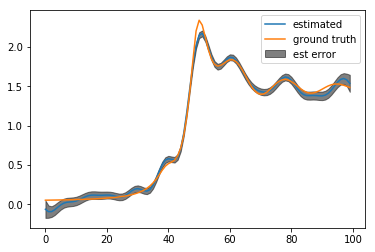

In [21]:
figure()
μ = m.predict_mean().detach().squeeze().numpy()
σ = m.predict_var().detach().sqrt().squeeze().numpy()
plot(μ, label='estimated')
fill_between(np.arange(100),μ+σ,μ-σ,color='k',alpha=0.5,label='est error')
plot(y,label='ground truth')
legend()

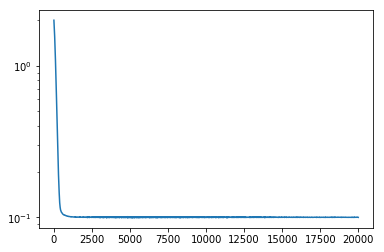

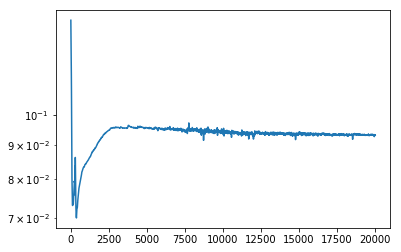

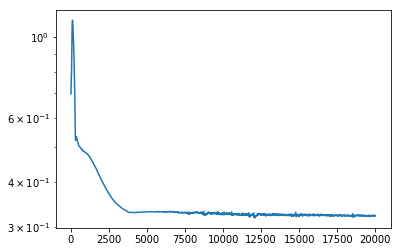

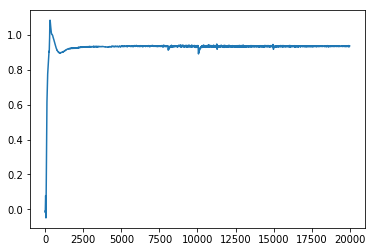

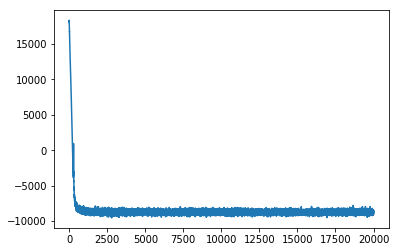

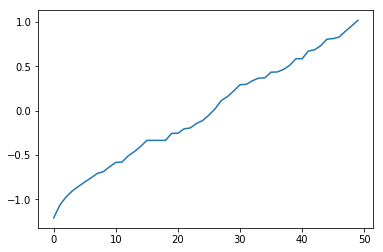

In [23]:
figure()
semilogy(Logger.val_dict['hyper_params.std_lik'])
figure()
semilogy(Logger.val_dict['stored_modules.K0._lengthscale_storage'])
figure()
semilogy(Logger.val_dict['stored_modules.K0._amplitude_storage'])
figure()
plot(Logger.val_dict['stored_modules.mprior.value'])
figure()
plot(Logger.val_dict['loss'])
figure()
plot(np.sort(m.hyper_params['u0'].detach().numpy().squeeze()))

## Example 2b

1. 1D GPMM
2. Gaussian likelihood
3. MC evaluation of variational expectation (reparameterization gradient)

In [24]:
class VFE_1D_GPMM_Reparam(torch.nn.Module):
    def __init__(self, U0, F0, Ntotal, Nmc=10, std_lik_init = 0.5, lenscale_init = 0.05,
                 dtype=torch.get_default_dtype()):
        super().__init__()
        self.dtype = dtype
        m = Vector('m')
        mprior = MeanSymbol('mprior')
        L0 = Matrix('L0')
        u0 = Vector('u0')
        f0 = Vector('f0')
        K0 = Kernel('K0')
        y = Vector('y')
        X = Matrix('X')
        Ntotal = Constant(Ntotal)
        #and finally the standard deviation of the likelihood
        std_lik = Scalar('std_lik')
        jitter = Scalar('jitter')
        Nmc = Constant(Nmc)
        #generally there are parameters which require positivity. I use this transform for them:
        self._makepos = SoftplusTransform()
        
        ### KL loss graph ###
        kl_loss = kl(K0, u0, mprior, L0, m, jitter)
        self._kl_loss_expr = kl_loss
        graph = expr2graph(Label(String("kl_loss"), kl_loss))
        self._kl_loss_fun = graph2ast(graph, compiled=True, debug=False)
        
        ### Predict to weighted f-space ###
        mf = weighted_mean(K0, u0, f0, mprior, m, X, jitter)
        varf = weighted_var_fullspace_diag(K0, f0, X) - weighted_var_subspace_diag(K0, u0, f0, X, jitter) + \
                weighted_var_posterior_diag(K0, u0, f0, L0, X, jitter)
        
        ### Gaussian Likelihood in f-space ###
        ϵ = StdNormalSample(mf,Nmc)
        z = Sqrt(varf)*ϵ + mf
        ve_loss = gaussian_likelihood(y, z, std_lik, Ntotal)
        self._ve_loss_expr = ve_loss
        graph = expr2graph(Label(String("ve_loss"), ve_loss))
        self._ve_loss_fun = graph2ast(graph, compiled=True, debug=False)
        
        #form the total loss
        loss = -ve_loss + kl_loss
        graph = expr2graph(Label(String("loss"), loss))
        self._loss_fun = graph2ast(graph, compiled=True, debug=False)
        
        ### Predict to f-space ###
        mf = mean(K0, u0, f0, mprior, m, jitter)
        graph = expr2graph(Label(String("mean_pred"), mf))
        self._mean_pred = graph2ast(graph, compiled=True, debug=False)
        varf = var_fullspace_diag(K0, f0) - var_subspace_diag(K0, u0, f0, jitter) + \
                var_posterior_diag(K0, u0, f0, L0, jitter)
        graph = expr2graph(Label(String("var_pred"), varf))
        self._var_pred = graph2ast(graph, compiled=True, debug=False)
        
        
        #the actual storage tensors go here:
        with torch.no_grad():
            self.variational_params = torch.nn.ParameterDict({
                'm': torch.nn.Parameter(torch.randn((U0,1),dtype=self.dtype)/(U0)),
            })
            self.hyper_params = torch.nn.ParameterDict({
                'std_lik': torch.nn.Parameter(self._makepos.inv(torch.tensor([[std_lik_init]],dtype=self.dtype))),
                'u0': torch.nn.Parameter(torch.linspace(-1,1,U0,dtype=self.dtype).unsqueeze(1)),
                #fixed parameters go here:
                'jitter': torch.nn.Parameter(torch.tensor(1e-4,dtype=self.dtype), requires_grad=False),
                'f0': torch.nn.Parameter(torch.linspace(-1,1,F0,dtype=self.dtype).unsqueeze(1), requires_grad=False),
            })

            #modules containing parameters go here:
            self.stored_modules = torch.nn.ModuleDict({
                'K0': ARDRBFKernel(lengthscale=torch.tensor([[lenscale_init]])),
                'mprior': ConstantMean(torch.tensor(0.))
                })
        priorL0 = (self.stored_modules['K0'](self.hyper_params['u0'],self.hyper_params['u0']) + 
                  torch.eye(U0)*1e-4).cholesky()
        self.L0 = ConstrainedLowerTriangular(U0)
        self.L0.custom_initialization(priorL0)
    def kl_loss(self):
        leaves = {
            **self.variational_params,
            **self.hyper_params,
            **self.stored_modules,
            'L0': self.L0(),
        }
        result = self._kl_loss_fun(**leaves)
        return result.kl_loss
    def ve_loss(self, y, X):
        leaves = {
            'y': y,
            'X': X,
            **self.variational_params,
            **self.hyper_params,
            **self.stored_modules,
            'L0': self.L0(),
            'std_lik': self._makepos(self.hyper_params['std_lik'])
        }
        result = self._ve_loss_fun(**leaves)
        return result.ve_loss
    def loss(self, y, X):
        leaves = {
            'y': y,
            'X': X,
            **self.variational_params,
            **self.hyper_params,
            **self.stored_modules,
            'L0': self.L0(),
            'std_lik': self._makepos(self.hyper_params['std_lik'])
        }
        result = self._loss_fun(**leaves)
        return result.loss
    def predict_mean(self):
        leaves = {
            **self.variational_params,
            **self.hyper_params,
            **self.stored_modules,
            'L0': self.L0(),
            'std_lik': self._makepos(self.hyper_params['std_lik'])
        }
        result = self._mean_pred(**leaves)
        return result.mean_pred
    def predict_var(self):
        leaves = {
            **self.variational_params,
            **self.hyper_params,
            **self.stored_modules,
            'L0': self.L0(),
            'std_lik': self._makepos(self.hyper_params['std_lik'])
        }
        result = self._var_pred(**leaves)
        return result.var_pred

In [26]:
m = VFE_1D_GPMM_Reparam(50,100,10000,Nmc=10,std_lik_init=2.0,lenscale_init=0.1)
# m.hyper_params['u0'].requires_grad = False
# m.hyper_params['u1'].requires_grad = False
# m.stored_K['K0']._lengthscale_storage.requires_grad = False
# m.stored_K['K0']._amplitude_storage.requires_grad = False
# m.stored_K['K1']._lengthscale_storage.requires_grad = False
# m.stored_K['K1']._amplitude_storage.requires_grad = False
m.cuda()
optimizer = torch.optim.Adam(m.parameters(),lr=5e-2)
epochs = 2000
scheduler = StepLR(optimizer,50,gamma=0.95)

data = TensorDataset(torch.from_numpy(X.astype('float32')), torch.from_numpy(yc.astype('float32')))
Logger = ScalarLogger(m, {'hyper_params.std_lik': m._makepos,
                          'stored_modules.K0._lengthscale_storage': m._makepos,
                          'stored_modules.K0._amplitude_storage': m._makepos,
                          'stored_modules.mprior.value': lambda x: x,
                         },
                     extra_keys={'loss': lambda x: x,
                                'step_size': lambda x: x})

for i in range(epochs):
    d = DataLoader(dataset=data, shuffle=True, batch_size=1000)
    for Xb,yb in d:
        ybc, Xbc = yb.cuda(), Xb.cuda()
        optimizer.zero_grad()
        loss = m.loss(ybc,Xbc)
        loss.backward()
        optimizer.step()
        Logger(extra_vals=[float(loss), float(optimizer.param_groups[0]['lr'])])
    scheduler.step()
    print(Logger.report("epoch {:d}: ".format(i)))

Module path:  /home/fdfuller/work/torchgp/notebooks/reparam/.compiled/fe6235a412301eab.py
Module path:  /home/fdfuller/work/torchgp/notebooks/reparam/.compiled/efc828e974709d99.py
Module path:  /home/fdfuller/work/torchgp/notebooks/reparam/.compiled/0ef4d8a08470d4f8.py
Module path:  /home/fdfuller/work/torchgp/notebooks/reparam/.compiled/a9dd8fb166accca4.py
Module path:  /home/fdfuller/work/torchgp/notebooks/reparam/.compiled/9e30380974ec36ab.py
epoch 0: hyper_params.std_lik: 1.58218, stored_modules.K0._lengthscale_storage: 0.061642, stored_modules.K0._amplitude_storage: 0.946538, stored_modules.mprior.value: 0.234023, loss: 19359.1, step_size: 0.05, 
epoch 1: hyper_params.std_lik: 1.2111, stored_modules.K0._lengthscale_storage: 0.0416273, stored_modules.K0._amplitude_storage: 1.15872, stored_modules.mprior.value: 0.670371, loss: 15281.7, step_size: 0.05, 
epoch 2: hyper_params.std_lik: 1.02401, stored_modules.K0._lengthscale_storage: 0.0282113, stored_modules.K0._amplitude_storage: 1.

epoch 38: hyper_params.std_lik: 0.117817, stored_modules.K0._lengthscale_storage: 0.00976551, stored_modules.K0._amplitude_storage: 0.028763, stored_modules.mprior.value: 1.03562, loss: -6775.14, step_size: 0.05, 
epoch 39: hyper_params.std_lik: 0.117371, stored_modules.K0._lengthscale_storage: 0.0108844, stored_modules.K0._amplitude_storage: 0.0290661, stored_modules.mprior.value: 1.05502, loss: -7251.94, step_size: 0.05, 
epoch 40: hyper_params.std_lik: 0.113937, stored_modules.K0._lengthscale_storage: 0.0122671, stored_modules.K0._amplitude_storage: 0.0296618, stored_modules.mprior.value: 1.06075, loss: -7128.7, step_size: 0.05, 
epoch 41: hyper_params.std_lik: 0.112941, stored_modules.K0._lengthscale_storage: 0.0139203, stored_modules.K0._amplitude_storage: 0.0305573, stored_modules.mprior.value: 1.07, loss: -6957.22, step_size: 0.05, 
epoch 42: hyper_params.std_lik: 0.110366, stored_modules.K0._lengthscale_storage: 0.0159449, stored_modules.K0._amplitude_storage: 0.0318605, stored

epoch 78: hyper_params.std_lik: 0.100946, stored_modules.K0._lengthscale_storage: 0.065615, stored_modules.K0._amplitude_storage: 0.127458, stored_modules.mprior.value: 1.017, loss: -8962.04, step_size: 0.0475, 
epoch 79: hyper_params.std_lik: 0.100399, stored_modules.K0._lengthscale_storage: 0.0660875, stored_modules.K0._amplitude_storage: 0.130089, stored_modules.mprior.value: 1.0159, loss: -8560.62, step_size: 0.0475, 
epoch 80: hyper_params.std_lik: 0.100134, stored_modules.K0._lengthscale_storage: 0.0664581, stored_modules.K0._amplitude_storage: 0.132786, stored_modules.mprior.value: 1.0148, loss: -8199.19, step_size: 0.0475, 
epoch 81: hyper_params.std_lik: 0.101023, stored_modules.K0._lengthscale_storage: 0.0669243, stored_modules.K0._amplitude_storage: 0.135284, stored_modules.mprior.value: 1.01379, loss: -9085.41, step_size: 0.0475, 
epoch 82: hyper_params.std_lik: 0.0998451, stored_modules.K0._lengthscale_storage: 0.067429, stored_modules.K0._amplitude_storage: 0.137716, stor

epoch 116: hyper_params.std_lik: 0.0996041, stored_modules.K0._lengthscale_storage: 0.0767905, stored_modules.K0._amplitude_storage: 0.20434, stored_modules.mprior.value: 0.991291, loss: -8806.56, step_size: 0.045125, 
epoch 117: hyper_params.std_lik: 0.100503, stored_modules.K0._lengthscale_storage: 0.0769882, stored_modules.K0._amplitude_storage: 0.205856, stored_modules.mprior.value: 0.990849, loss: -8593.21, step_size: 0.045125, 
epoch 118: hyper_params.std_lik: 0.0996129, stored_modules.K0._lengthscale_storage: 0.077253, stored_modules.K0._amplitude_storage: 0.207247, stored_modules.mprior.value: 0.990416, loss: -8900.67, step_size: 0.045125, 
epoch 119: hyper_params.std_lik: 0.101262, stored_modules.K0._lengthscale_storage: 0.0773436, stored_modules.K0._amplitude_storage: 0.208878, stored_modules.mprior.value: 0.989992, loss: -8870.22, step_size: 0.045125, 
epoch 120: hyper_params.std_lik: 0.0995763, stored_modules.K0._lengthscale_storage: 0.0775375, stored_modules.K0._amplitude_

epoch 154: hyper_params.std_lik: 0.101054, stored_modules.K0._lengthscale_storage: 0.0836338, stored_modules.K0._amplitude_storage: 0.249569, stored_modules.mprior.value: 0.978054, loss: -8757.9, step_size: 0.0428687, 
epoch 155: hyper_params.std_lik: 0.0995687, stored_modules.K0._lengthscale_storage: 0.0838156, stored_modules.K0._amplitude_storage: 0.250492, stored_modules.mprior.value: 0.977691, loss: -8506.05, step_size: 0.0428687, 
epoch 156: hyper_params.std_lik: 0.100875, stored_modules.K0._lengthscale_storage: 0.0840245, stored_modules.K0._amplitude_storage: 0.251306, stored_modules.mprior.value: 0.977434, loss: -8655.21, step_size: 0.0428687, 
epoch 157: hyper_params.std_lik: 0.100007, stored_modules.K0._lengthscale_storage: 0.0840443, stored_modules.K0._amplitude_storage: 0.252318, stored_modules.mprior.value: 0.977222, loss: -8685.93, step_size: 0.0428687, 
epoch 158: hyper_params.std_lik: 0.101508, stored_modules.K0._lengthscale_storage: 0.0840134, stored_modules.K0._amplitu

epoch 192: hyper_params.std_lik: 0.101143, stored_modules.K0._lengthscale_storage: 0.0868053, stored_modules.K0._amplitude_storage: 0.278601, stored_modules.mprior.value: 0.9687, loss: -8675.24, step_size: 0.0428687, 
epoch 193: hyper_params.std_lik: 0.101002, stored_modules.K0._lengthscale_storage: 0.0868896, stored_modules.K0._amplitude_storage: 0.279045, stored_modules.mprior.value: 0.968487, loss: -8669.99, step_size: 0.0428687, 
epoch 194: hyper_params.std_lik: 0.100702, stored_modules.K0._lengthscale_storage: 0.086874, stored_modules.K0._amplitude_storage: 0.279626, stored_modules.mprior.value: 0.968321, loss: -8926.15, step_size: 0.0428687, 
epoch 195: hyper_params.std_lik: 0.101964, stored_modules.K0._lengthscale_storage: 0.0869102, stored_modules.K0._amplitude_storage: 0.28017, stored_modules.mprior.value: 0.968122, loss: -8832.51, step_size: 0.0428687, 
epoch 196: hyper_params.std_lik: 0.0986014, stored_modules.K0._lengthscale_storage: 0.0871486, stored_modules.K0._amplitude_

epoch 230: hyper_params.std_lik: 0.101438, stored_modules.K0._lengthscale_storage: 0.0885984, stored_modules.K0._amplitude_storage: 0.294911, stored_modules.mprior.value: 0.961632, loss: -8739.77, step_size: 0.0407253, 
epoch 231: hyper_params.std_lik: 0.100778, stored_modules.K0._lengthscale_storage: 0.0885858, stored_modules.K0._amplitude_storage: 0.295356, stored_modules.mprior.value: 0.961461, loss: -8730.65, step_size: 0.0407253, 
epoch 232: hyper_params.std_lik: 0.0987147, stored_modules.K0._lengthscale_storage: 0.088633, stored_modules.K0._amplitude_storage: 0.29568, stored_modules.mprior.value: 0.961286, loss: -8691.56, step_size: 0.0407253, 
epoch 233: hyper_params.std_lik: 0.103582, stored_modules.K0._lengthscale_storage: 0.0886662, stored_modules.K0._amplitude_storage: 0.295947, stored_modules.mprior.value: 0.961177, loss: -8869.02, step_size: 0.0407253, 
epoch 234: hyper_params.std_lik: 0.0979235, stored_modules.K0._lengthscale_storage: 0.0886847, stored_modules.K0._amplitu

epoch 268: hyper_params.std_lik: 0.10009, stored_modules.K0._lengthscale_storage: 0.0888159, stored_modules.K0._amplitude_storage: 0.303279, stored_modules.mprior.value: 0.95577, loss: -8669.47, step_size: 0.038689, 
epoch 269: hyper_params.std_lik: 0.100853, stored_modules.K0._lengthscale_storage: 0.0889996, stored_modules.K0._amplitude_storage: 0.303052, stored_modules.mprior.value: 0.955628, loss: -8354.21, step_size: 0.038689, 
epoch 270: hyper_params.std_lik: 0.099562, stored_modules.K0._lengthscale_storage: 0.0891652, stored_modules.K0._amplitude_storage: 0.302875, stored_modules.mprior.value: 0.955479, loss: -8758.01, step_size: 0.038689, 
epoch 271: hyper_params.std_lik: 0.102737, stored_modules.K0._lengthscale_storage: 0.0890624, stored_modules.K0._amplitude_storage: 0.303272, stored_modules.mprior.value: 0.955339, loss: -8595.03, step_size: 0.038689, 
epoch 272: hyper_params.std_lik: 0.0990365, stored_modules.K0._lengthscale_storage: 0.0890164, stored_modules.K0._amplitude_st

epoch 306: hyper_params.std_lik: 0.100418, stored_modules.K0._lengthscale_storage: 0.089523, stored_modules.K0._amplitude_storage: 0.307199, stored_modules.mprior.value: 0.950642, loss: -8648.36, step_size: 0.0367546, 
epoch 307: hyper_params.std_lik: 0.0998548, stored_modules.K0._lengthscale_storage: 0.0896281, stored_modules.K0._amplitude_storage: 0.307041, stored_modules.mprior.value: 0.950512, loss: -8929.47, step_size: 0.0367546, 
epoch 308: hyper_params.std_lik: 0.0997629, stored_modules.K0._lengthscale_storage: 0.0898351, stored_modules.K0._amplitude_storage: 0.306822, stored_modules.mprior.value: 0.950422, loss: -8774.72, step_size: 0.0367546, 
epoch 309: hyper_params.std_lik: 0.102126, stored_modules.K0._lengthscale_storage: 0.0898652, stored_modules.K0._amplitude_storage: 0.306937, stored_modules.mprior.value: 0.950268, loss: -9058.68, step_size: 0.0367546, 
epoch 310: hyper_params.std_lik: 0.0997311, stored_modules.K0._lengthscale_storage: 0.0896274, stored_modules.K0._ampli

epoch 344: hyper_params.std_lik: 0.100595, stored_modules.K0._lengthscale_storage: 0.089226, stored_modules.K0._amplitude_storage: 0.309322, stored_modules.mprior.value: 0.946774, loss: -8474.64, step_size: 0.0367546, 
epoch 345: hyper_params.std_lik: 0.101615, stored_modules.K0._lengthscale_storage: 0.0891783, stored_modules.K0._amplitude_storage: 0.30931, stored_modules.mprior.value: 0.946662, loss: -9054.49, step_size: 0.0367546, 
epoch 346: hyper_params.std_lik: 0.0990472, stored_modules.K0._lengthscale_storage: 0.0891619, stored_modules.K0._amplitude_storage: 0.30934, stored_modules.mprior.value: 0.946562, loss: -8524.94, step_size: 0.0367546, 
epoch 347: hyper_params.std_lik: 0.100412, stored_modules.K0._lengthscale_storage: 0.0892496, stored_modules.K0._amplitude_storage: 0.309115, stored_modules.mprior.value: 0.946498, loss: -8537.24, step_size: 0.0367546, 
epoch 348: hyper_params.std_lik: 0.102962, stored_modules.K0._lengthscale_storage: 0.089572, stored_modules.K0._amplitude_

epoch 382: hyper_params.std_lik: 0.100899, stored_modules.K0._lengthscale_storage: 0.0898442, stored_modules.K0._amplitude_storage: 0.31139, stored_modules.mprior.value: 0.943684, loss: -9026.38, step_size: 0.0349169, 
epoch 383: hyper_params.std_lik: 0.100362, stored_modules.K0._lengthscale_storage: 0.0898095, stored_modules.K0._amplitude_storage: 0.311188, stored_modules.mprior.value: 0.943625, loss: -8742.78, step_size: 0.0349169, 
epoch 384: hyper_params.std_lik: 0.10092, stored_modules.K0._lengthscale_storage: 0.08995, stored_modules.K0._amplitude_storage: 0.310816, stored_modules.mprior.value: 0.943657, loss: -8756.83, step_size: 0.0349169, 
epoch 385: hyper_params.std_lik: 0.10036, stored_modules.K0._lengthscale_storage: 0.0901626, stored_modules.K0._amplitude_storage: 0.310695, stored_modules.mprior.value: 0.943608, loss: -8492.12, step_size: 0.0349169, 
epoch 386: hyper_params.std_lik: 0.102153, stored_modules.K0._lengthscale_storage: 0.0900426, stored_modules.K0._amplitude_st

epoch 420: hyper_params.std_lik: 0.0986045, stored_modules.K0._lengthscale_storage: 0.0906751, stored_modules.K0._amplitude_storage: 0.313627, stored_modules.mprior.value: 0.941075, loss: -8527.78, step_size: 0.033171, 
epoch 421: hyper_params.std_lik: 0.10172, stored_modules.K0._lengthscale_storage: 0.0907697, stored_modules.K0._amplitude_storage: 0.313581, stored_modules.mprior.value: 0.940939, loss: -8814.1, step_size: 0.033171, 
epoch 422: hyper_params.std_lik: 0.100074, stored_modules.K0._lengthscale_storage: 0.0905377, stored_modules.K0._amplitude_storage: 0.313834, stored_modules.mprior.value: 0.940939, loss: -8966.02, step_size: 0.033171, 
epoch 423: hyper_params.std_lik: 0.100141, stored_modules.K0._lengthscale_storage: 0.0904521, stored_modules.K0._amplitude_storage: 0.31404, stored_modules.mprior.value: 0.940808, loss: -8370.46, step_size: 0.033171, 
epoch 424: hyper_params.std_lik: 0.0998266, stored_modules.K0._lengthscale_storage: 0.0901145, stored_modules.K0._amplitude_st

epoch 458: hyper_params.std_lik: 0.0987876, stored_modules.K0._lengthscale_storage: 0.091152, stored_modules.K0._amplitude_storage: 0.314657, stored_modules.mprior.value: 0.939306, loss: -8850.36, step_size: 0.0315125, 
epoch 459: hyper_params.std_lik: 0.101375, stored_modules.K0._lengthscale_storage: 0.0912825, stored_modules.K0._amplitude_storage: 0.314851, stored_modules.mprior.value: 0.939222, loss: -8735.31, step_size: 0.0315125, 
epoch 460: hyper_params.std_lik: 0.0999066, stored_modules.K0._lengthscale_storage: 0.0912966, stored_modules.K0._amplitude_storage: 0.31523, stored_modules.mprior.value: 0.939202, loss: -8950.45, step_size: 0.0315125, 
epoch 461: hyper_params.std_lik: 0.099977, stored_modules.K0._lengthscale_storage: 0.0912918, stored_modules.K0._amplitude_storage: 0.315426, stored_modules.mprior.value: 0.939138, loss: -8885.38, step_size: 0.0315125, 
epoch 462: hyper_params.std_lik: 0.102009, stored_modules.K0._lengthscale_storage: 0.0911694, stored_modules.K0._amplitu

epoch 496: hyper_params.std_lik: 0.097734, stored_modules.K0._lengthscale_storage: 0.0916206, stored_modules.K0._amplitude_storage: 0.317576, stored_modules.mprior.value: 0.93769, loss: -8552.7, step_size: 0.0315125, 
epoch 497: hyper_params.std_lik: 0.102153, stored_modules.K0._lengthscale_storage: 0.0914957, stored_modules.K0._amplitude_storage: 0.317963, stored_modules.mprior.value: 0.937671, loss: -8870.9, step_size: 0.0315125, 
epoch 498: hyper_params.std_lik: 0.0993556, stored_modules.K0._lengthscale_storage: 0.0914955, stored_modules.K0._amplitude_storage: 0.318046, stored_modules.mprior.value: 0.937579, loss: -8446.88, step_size: 0.0315125, 
epoch 499: hyper_params.std_lik: 0.10106, stored_modules.K0._lengthscale_storage: 0.0915828, stored_modules.K0._amplitude_storage: 0.317917, stored_modules.mprior.value: 0.937595, loss: -8490.29, step_size: 0.0315125, 
epoch 500: hyper_params.std_lik: 0.0995035, stored_modules.K0._lengthscale_storage: 0.0915563, stored_modules.K0._amplitude

epoch 534: hyper_params.std_lik: 0.0997537, stored_modules.K0._lengthscale_storage: 0.0917685, stored_modules.K0._amplitude_storage: 0.31873, stored_modules.mprior.value: 0.936507, loss: -8534.09, step_size: 0.0299368, 
epoch 535: hyper_params.std_lik: 0.100917, stored_modules.K0._lengthscale_storage: 0.0917552, stored_modules.K0._amplitude_storage: 0.318878, stored_modules.mprior.value: 0.936441, loss: -8733.49, step_size: 0.0299368, 
epoch 536: hyper_params.std_lik: 0.0995903, stored_modules.K0._lengthscale_storage: 0.0914496, stored_modules.K0._amplitude_storage: 0.319551, stored_modules.mprior.value: 0.936359, loss: -8482.33, step_size: 0.0299368, 
epoch 537: hyper_params.std_lik: 0.0994384, stored_modules.K0._lengthscale_storage: 0.0914211, stored_modules.K0._amplitude_storage: 0.319543, stored_modules.mprior.value: 0.936399, loss: -8855.34, step_size: 0.0299368, 
epoch 538: hyper_params.std_lik: 0.101138, stored_modules.K0._lengthscale_storage: 0.0915636, stored_modules.K0._ampli

epoch 572: hyper_params.std_lik: 0.100056, stored_modules.K0._lengthscale_storage: 0.091792, stored_modules.K0._amplitude_storage: 0.319758, stored_modules.mprior.value: 0.935727, loss: -8787.21, step_size: 0.02844, 
epoch 573: hyper_params.std_lik: 0.100117, stored_modules.K0._lengthscale_storage: 0.0920056, stored_modules.K0._amplitude_storage: 0.319565, stored_modules.mprior.value: 0.935713, loss: -8752.25, step_size: 0.02844, 
epoch 574: hyper_params.std_lik: 0.101012, stored_modules.K0._lengthscale_storage: 0.091632, stored_modules.K0._amplitude_storage: 0.32049, stored_modules.mprior.value: 0.935747, loss: -8659.08, step_size: 0.02844, 
epoch 575: hyper_params.std_lik: 0.100429, stored_modules.K0._lengthscale_storage: 0.0915963, stored_modules.K0._amplitude_storage: 0.32055, stored_modules.mprior.value: 0.935752, loss: -8677.25, step_size: 0.02844, 
epoch 576: hyper_params.std_lik: 0.100305, stored_modules.K0._lengthscale_storage: 0.0919903, stored_modules.K0._amplitude_storage: 

epoch 610: hyper_params.std_lik: 0.0993744, stored_modules.K0._lengthscale_storage: 0.0923068, stored_modules.K0._amplitude_storage: 0.320413, stored_modules.mprior.value: 0.935432, loss: -8681.23, step_size: 0.027018, 
epoch 611: hyper_params.std_lik: 0.10159, stored_modules.K0._lengthscale_storage: 0.0920895, stored_modules.K0._amplitude_storage: 0.320452, stored_modules.mprior.value: 0.935479, loss: -8299.12, step_size: 0.027018, 
epoch 612: hyper_params.std_lik: 0.100638, stored_modules.K0._lengthscale_storage: 0.0921171, stored_modules.K0._amplitude_storage: 0.320248, stored_modules.mprior.value: 0.935629, loss: -8931.81, step_size: 0.027018, 
epoch 613: hyper_params.std_lik: 0.100994, stored_modules.K0._lengthscale_storage: 0.0924666, stored_modules.K0._amplitude_storage: 0.320155, stored_modules.mprior.value: 0.935547, loss: -9043.77, step_size: 0.027018, 
epoch 614: hyper_params.std_lik: 0.0999999, stored_modules.K0._lengthscale_storage: 0.091966, stored_modules.K0._amplitude_s

epoch 648: hyper_params.std_lik: 0.0992415, stored_modules.K0._lengthscale_storage: 0.0917367, stored_modules.K0._amplitude_storage: 0.321969, stored_modules.mprior.value: 0.934879, loss: -8943.8, step_size: 0.027018, 
epoch 649: hyper_params.std_lik: 0.102519, stored_modules.K0._lengthscale_storage: 0.0910101, stored_modules.K0._amplitude_storage: 0.322423, stored_modules.mprior.value: 0.934742, loss: -8904.25, step_size: 0.027018, 
epoch 650: hyper_params.std_lik: 0.0995062, stored_modules.K0._lengthscale_storage: 0.0916273, stored_modules.K0._amplitude_storage: 0.320468, stored_modules.mprior.value: 0.934755, loss: -8612.21, step_size: 0.0256671, 
epoch 651: hyper_params.std_lik: 0.101022, stored_modules.K0._lengthscale_storage: 0.0913879, stored_modules.K0._amplitude_storage: 0.320707, stored_modules.mprior.value: 0.934848, loss: -8730.35, step_size: 0.0256671, 
epoch 652: hyper_params.std_lik: 0.101001, stored_modules.K0._lengthscale_storage: 0.0915264, stored_modules.K0._amplitud

epoch 686: hyper_params.std_lik: 0.100315, stored_modules.K0._lengthscale_storage: 0.0921507, stored_modules.K0._amplitude_storage: 0.321566, stored_modules.mprior.value: 0.934635, loss: -9010.6, step_size: 0.0256671, 
epoch 687: hyper_params.std_lik: 0.0999212, stored_modules.K0._lengthscale_storage: 0.0917896, stored_modules.K0._amplitude_storage: 0.322597, stored_modules.mprior.value: 0.934521, loss: -8622.92, step_size: 0.0256671, 
epoch 688: hyper_params.std_lik: 0.100556, stored_modules.K0._lengthscale_storage: 0.0919658, stored_modules.K0._amplitude_storage: 0.321985, stored_modules.mprior.value: 0.934468, loss: -8952.28, step_size: 0.0256671, 
epoch 689: hyper_params.std_lik: 0.101025, stored_modules.K0._lengthscale_storage: 0.0934792, stored_modules.K0._amplitude_storage: 0.319173, stored_modules.mprior.value: 0.934355, loss: -8805.32, step_size: 0.0256671, 
epoch 690: hyper_params.std_lik: 0.100208, stored_modules.K0._lengthscale_storage: 0.0926768, stored_modules.K0._amplitu

epoch 724: hyper_params.std_lik: 0.100377, stored_modules.K0._lengthscale_storage: 0.0927666, stored_modules.K0._amplitude_storage: 0.323176, stored_modules.mprior.value: 0.934393, loss: -8658.52, step_size: 0.0243837, 
epoch 725: hyper_params.std_lik: 0.100506, stored_modules.K0._lengthscale_storage: 0.0927828, stored_modules.K0._amplitude_storage: 0.323168, stored_modules.mprior.value: 0.9344, loss: -9110.8, step_size: 0.0243837, 
epoch 726: hyper_params.std_lik: 0.0995955, stored_modules.K0._lengthscale_storage: 0.09233, stored_modules.K0._amplitude_storage: 0.324093, stored_modules.mprior.value: 0.934456, loss: -8598.95, step_size: 0.0243837, 
epoch 727: hyper_params.std_lik: 0.100894, stored_modules.K0._lengthscale_storage: 0.092731, stored_modules.K0._amplitude_storage: 0.323253, stored_modules.mprior.value: 0.934281, loss: -8910.4, step_size: 0.0243837, 
epoch 728: hyper_params.std_lik: 0.0990074, stored_modules.K0._lengthscale_storage: 0.09247, stored_modules.K0._amplitude_stor

epoch 762: hyper_params.std_lik: 0.100412, stored_modules.K0._lengthscale_storage: 0.0921705, stored_modules.K0._amplitude_storage: 0.321997, stored_modules.mprior.value: 0.934595, loss: -8498.4, step_size: 0.0231646, 
epoch 763: hyper_params.std_lik: 0.100687, stored_modules.K0._lengthscale_storage: 0.0918808, stored_modules.K0._amplitude_storage: 0.32329, stored_modules.mprior.value: 0.934452, loss: -8917.13, step_size: 0.0231646, 
epoch 764: hyper_params.std_lik: 0.0996347, stored_modules.K0._lengthscale_storage: 0.0919273, stored_modules.K0._amplitude_storage: 0.323544, stored_modules.mprior.value: 0.934304, loss: -8594.59, step_size: 0.0231646, 
epoch 765: hyper_params.std_lik: 0.101857, stored_modules.K0._lengthscale_storage: 0.092546, stored_modules.K0._amplitude_storage: 0.324034, stored_modules.mprior.value: 0.933786, loss: -8798.6, step_size: 0.0231646, 
epoch 766: hyper_params.std_lik: 0.0998609, stored_modules.K0._lengthscale_storage: 0.0920862, stored_modules.K0._amplitude

epoch 800: hyper_params.std_lik: 0.100473, stored_modules.K0._lengthscale_storage: 0.0917427, stored_modules.K0._amplitude_storage: 0.318728, stored_modules.mprior.value: 0.934343, loss: -8895.11, step_size: 0.0220063, 
epoch 801: hyper_params.std_lik: 0.10094, stored_modules.K0._lengthscale_storage: 0.0915949, stored_modules.K0._amplitude_storage: 0.319687, stored_modules.mprior.value: 0.934668, loss: -8452.2, step_size: 0.0220063, 
epoch 802: hyper_params.std_lik: 0.100199, stored_modules.K0._lengthscale_storage: 0.091547, stored_modules.K0._amplitude_storage: 0.320297, stored_modules.mprior.value: 0.934884, loss: -8676.5, step_size: 0.0220063, 
epoch 803: hyper_params.std_lik: 0.10069, stored_modules.K0._lengthscale_storage: 0.0931564, stored_modules.K0._amplitude_storage: 0.31734, stored_modules.mprior.value: 0.934582, loss: -8429.5, step_size: 0.0220063, 
epoch 804: hyper_params.std_lik: 0.100898, stored_modules.K0._lengthscale_storage: 0.092321, stored_modules.K0._amplitude_stora

epoch 838: hyper_params.std_lik: 0.100609, stored_modules.K0._lengthscale_storage: 0.0918542, stored_modules.K0._amplitude_storage: 0.318162, stored_modules.mprior.value: 0.935055, loss: -8891.46, step_size: 0.0220063, 
epoch 839: hyper_params.std_lik: 0.100203, stored_modules.K0._lengthscale_storage: 0.0918876, stored_modules.K0._amplitude_storage: 0.319535, stored_modules.mprior.value: 0.934794, loss: -8378.54, step_size: 0.0220063, 
epoch 840: hyper_params.std_lik: 0.100779, stored_modules.K0._lengthscale_storage: 0.0916107, stored_modules.K0._amplitude_storage: 0.319478, stored_modules.mprior.value: 0.934948, loss: -8513.27, step_size: 0.0220063, 
epoch 841: hyper_params.std_lik: 0.100676, stored_modules.K0._lengthscale_storage: 0.0902151, stored_modules.K0._amplitude_storage: 0.32079, stored_modules.mprior.value: 0.934694, loss: -8826.41, step_size: 0.0220063, 
epoch 842: hyper_params.std_lik: 0.0995269, stored_modules.K0._lengthscale_storage: 0.0896109, stored_modules.K0._amplitu

epoch 876: hyper_params.std_lik: 0.0998304, stored_modules.K0._lengthscale_storage: 0.0905957, stored_modules.K0._amplitude_storage: 0.327636, stored_modules.mprior.value: 0.934337, loss: -8580.67, step_size: 0.020906, 
epoch 877: hyper_params.std_lik: 0.1009, stored_modules.K0._lengthscale_storage: 0.0920431, stored_modules.K0._amplitude_storage: 0.322573, stored_modules.mprior.value: 0.934246, loss: -9121.1, step_size: 0.020906, 
epoch 878: hyper_params.std_lik: 0.100284, stored_modules.K0._lengthscale_storage: 0.0940063, stored_modules.K0._amplitude_storage: 0.32438, stored_modules.mprior.value: 0.934039, loss: -8686.7, step_size: 0.020906, 
epoch 879: hyper_params.std_lik: 0.100449, stored_modules.K0._lengthscale_storage: 0.0900775, stored_modules.K0._amplitude_storage: 0.33197, stored_modules.mprior.value: 0.933795, loss: -8633.25, step_size: 0.020906, 
epoch 880: hyper_params.std_lik: 0.0998567, stored_modules.K0._lengthscale_storage: 0.092615, stored_modules.K0._amplitude_storag

epoch 914: hyper_params.std_lik: 0.100528, stored_modules.K0._lengthscale_storage: 0.0918167, stored_modules.K0._amplitude_storage: 0.318888, stored_modules.mprior.value: 0.934221, loss: -8829.44, step_size: 0.0198607, 
epoch 915: hyper_params.std_lik: 0.100485, stored_modules.K0._lengthscale_storage: 0.0918785, stored_modules.K0._amplitude_storage: 0.318272, stored_modules.mprior.value: 0.93451, loss: -8583.12, step_size: 0.0198607, 
epoch 916: hyper_params.std_lik: 0.100952, stored_modules.K0._lengthscale_storage: 0.0914894, stored_modules.K0._amplitude_storage: 0.319047, stored_modules.mprior.value: 0.934327, loss: -9121.45, step_size: 0.0198607, 
epoch 917: hyper_params.std_lik: 0.0998445, stored_modules.K0._lengthscale_storage: 0.0910737, stored_modules.K0._amplitude_storage: 0.319142, stored_modules.mprior.value: 0.93453, loss: -8599.87, step_size: 0.0198607, 
epoch 918: hyper_params.std_lik: 0.100866, stored_modules.K0._lengthscale_storage: 0.0927725, stored_modules.K0._amplitud

epoch 952: hyper_params.std_lik: 0.10099, stored_modules.K0._lengthscale_storage: 0.0914789, stored_modules.K0._amplitude_storage: 0.312559, stored_modules.mprior.value: 0.933599, loss: -9098.07, step_size: 0.0188677, 
epoch 953: hyper_params.std_lik: 0.100187, stored_modules.K0._lengthscale_storage: 0.091876, stored_modules.K0._amplitude_storage: 0.314928, stored_modules.mprior.value: 0.933673, loss: -8850.67, step_size: 0.0188677, 
epoch 954: hyper_params.std_lik: 0.100639, stored_modules.K0._lengthscale_storage: 0.0908392, stored_modules.K0._amplitude_storage: 0.318227, stored_modules.mprior.value: 0.933776, loss: -8766.73, step_size: 0.0188677, 
epoch 955: hyper_params.std_lik: 0.100552, stored_modules.K0._lengthscale_storage: 0.090171, stored_modules.K0._amplitude_storage: 0.318766, stored_modules.mprior.value: 0.933854, loss: -8678.13, step_size: 0.0188677, 
epoch 956: hyper_params.std_lik: 0.100889, stored_modules.K0._lengthscale_storage: 0.091925, stored_modules.K0._amplitude_s

epoch 990: hyper_params.std_lik: 0.100185, stored_modules.K0._lengthscale_storage: 0.0921873, stored_modules.K0._amplitude_storage: 0.318225, stored_modules.mprior.value: 0.934327, loss: -8859.88, step_size: 0.0188677, 
epoch 991: hyper_params.std_lik: 0.100903, stored_modules.K0._lengthscale_storage: 0.0922318, stored_modules.K0._amplitude_storage: 0.31879, stored_modules.mprior.value: 0.934198, loss: -8639.91, step_size: 0.0188677, 
epoch 992: hyper_params.std_lik: 0.101318, stored_modules.K0._lengthscale_storage: 0.0915288, stored_modules.K0._amplitude_storage: 0.32041, stored_modules.mprior.value: 0.934284, loss: -8664.43, step_size: 0.0188677, 
epoch 993: hyper_params.std_lik: 0.0998541, stored_modules.K0._lengthscale_storage: 0.0911011, stored_modules.K0._amplitude_storage: 0.315129, stored_modules.mprior.value: 0.935321, loss: -8855.11, step_size: 0.0188677, 
epoch 994: hyper_params.std_lik: 0.100517, stored_modules.K0._lengthscale_storage: 0.091265, stored_modules.K0._amplitude

epoch 1028: hyper_params.std_lik: 0.100018, stored_modules.K0._lengthscale_storage: 0.0918791, stored_modules.K0._amplitude_storage: 0.312322, stored_modules.mprior.value: 0.93411, loss: -8318.04, step_size: 0.0179243, 
epoch 1029: hyper_params.std_lik: 0.100019, stored_modules.K0._lengthscale_storage: 0.0921721, stored_modules.K0._amplitude_storage: 0.312966, stored_modules.mprior.value: 0.934747, loss: -8513.96, step_size: 0.0179243, 
epoch 1030: hyper_params.std_lik: 0.100773, stored_modules.K0._lengthscale_storage: 0.092139, stored_modules.K0._amplitude_storage: 0.315059, stored_modules.mprior.value: 0.934869, loss: -9045.5, step_size: 0.0179243, 
epoch 1031: hyper_params.std_lik: 0.100547, stored_modules.K0._lengthscale_storage: 0.0918351, stored_modules.K0._amplitude_storage: 0.318337, stored_modules.mprior.value: 0.934435, loss: -8702.42, step_size: 0.0179243, 
epoch 1032: hyper_params.std_lik: 0.101341, stored_modules.K0._lengthscale_storage: 0.0911543, stored_modules.K0._ampli

epoch 1066: hyper_params.std_lik: 0.100513, stored_modules.K0._lengthscale_storage: 0.0933208, stored_modules.K0._amplitude_storage: 0.32027, stored_modules.mprior.value: 0.934136, loss: -8557.38, step_size: 0.0170281, 
epoch 1067: hyper_params.std_lik: 0.100382, stored_modules.K0._lengthscale_storage: 0.0923003, stored_modules.K0._amplitude_storage: 0.323155, stored_modules.mprior.value: 0.934208, loss: -8657.96, step_size: 0.0170281, 
epoch 1068: hyper_params.std_lik: 0.100721, stored_modules.K0._lengthscale_storage: 0.0919138, stored_modules.K0._amplitude_storage: 0.322959, stored_modules.mprior.value: 0.93418, loss: -9163.95, step_size: 0.0170281, 
epoch 1069: hyper_params.std_lik: 0.0992919, stored_modules.K0._lengthscale_storage: 0.0930485, stored_modules.K0._amplitude_storage: 0.318997, stored_modules.mprior.value: 0.933862, loss: -9002.09, step_size: 0.0170281, 
epoch 1070: hyper_params.std_lik: 0.100382, stored_modules.K0._lengthscale_storage: 0.0928796, stored_modules.K0._amp

epoch 1104: hyper_params.std_lik: 0.100649, stored_modules.K0._lengthscale_storage: 0.0932033, stored_modules.K0._amplitude_storage: 0.319246, stored_modules.mprior.value: 0.933866, loss: -8482.35, step_size: 0.0161767, 
epoch 1105: hyper_params.std_lik: 0.100271, stored_modules.K0._lengthscale_storage: 0.0915522, stored_modules.K0._amplitude_storage: 0.324268, stored_modules.mprior.value: 0.933881, loss: -8737.61, step_size: 0.0161767, 
epoch 1106: hyper_params.std_lik: 0.100292, stored_modules.K0._lengthscale_storage: 0.092195, stored_modules.K0._amplitude_storage: 0.320716, stored_modules.mprior.value: 0.934014, loss: -8268.96, step_size: 0.0161767, 
epoch 1107: hyper_params.std_lik: 0.100596, stored_modules.K0._lengthscale_storage: 0.0923169, stored_modules.K0._amplitude_storage: 0.319298, stored_modules.mprior.value: 0.933673, loss: -8767.77, step_size: 0.0161767, 
epoch 1108: hyper_params.std_lik: 0.100462, stored_modules.K0._lengthscale_storage: 0.093352, stored_modules.K0._ampl

epoch 1142: hyper_params.std_lik: 0.100108, stored_modules.K0._lengthscale_storage: 0.0927525, stored_modules.K0._amplitude_storage: 0.31829, stored_modules.mprior.value: 0.93364, loss: -8742.25, step_size: 0.0161767, 
epoch 1143: hyper_params.std_lik: 0.0996742, stored_modules.K0._lengthscale_storage: 0.0926014, stored_modules.K0._amplitude_storage: 0.320117, stored_modules.mprior.value: 0.933795, loss: -9037.92, step_size: 0.0161767, 
epoch 1144: hyper_params.std_lik: 0.100697, stored_modules.K0._lengthscale_storage: 0.0931398, stored_modules.K0._amplitude_storage: 0.318573, stored_modules.mprior.value: 0.934178, loss: -8619.92, step_size: 0.0161767, 
epoch 1145: hyper_params.std_lik: 0.0995477, stored_modules.K0._lengthscale_storage: 0.0926581, stored_modules.K0._amplitude_storage: 0.320077, stored_modules.mprior.value: 0.934505, loss: -8439.91, step_size: 0.0161767, 
epoch 1146: hyper_params.std_lik: 0.100617, stored_modules.K0._lengthscale_storage: 0.091408, stored_modules.K0._amp

epoch 1180: hyper_params.std_lik: 0.0990855, stored_modules.K0._lengthscale_storage: 0.092928, stored_modules.K0._amplitude_storage: 0.321825, stored_modules.mprior.value: 0.934054, loss: -8855.26, step_size: 0.0153678, 
epoch 1181: hyper_params.std_lik: 0.100317, stored_modules.K0._lengthscale_storage: 0.0933928, stored_modules.K0._amplitude_storage: 0.32188, stored_modules.mprior.value: 0.934054, loss: -8850.29, step_size: 0.0153678, 
epoch 1182: hyper_params.std_lik: 0.0999529, stored_modules.K0._lengthscale_storage: 0.0915276, stored_modules.K0._amplitude_storage: 0.327674, stored_modules.mprior.value: 0.934468, loss: -8544, step_size: 0.0153678, 
epoch 1183: hyper_params.std_lik: 0.101146, stored_modules.K0._lengthscale_storage: 0.0908486, stored_modules.K0._amplitude_storage: 0.326104, stored_modules.mprior.value: 0.933998, loss: -8974.41, step_size: 0.0153678, 
epoch 1184: hyper_params.std_lik: 0.0998721, stored_modules.K0._lengthscale_storage: 0.0904669, stored_modules.K0._ampl

epoch 1218: hyper_params.std_lik: 0.100734, stored_modules.K0._lengthscale_storage: 0.0913941, stored_modules.K0._amplitude_storage: 0.32762, stored_modules.mprior.value: 0.934727, loss: -8520.64, step_size: 0.0145995, 
epoch 1219: hyper_params.std_lik: 0.100943, stored_modules.K0._lengthscale_storage: 0.0916449, stored_modules.K0._amplitude_storage: 0.322901, stored_modules.mprior.value: 0.934343, loss: -9022.6, step_size: 0.0145995, 
epoch 1220: hyper_params.std_lik: 0.0999381, stored_modules.K0._lengthscale_storage: 0.0888657, stored_modules.K0._amplitude_storage: 0.324746, stored_modules.mprior.value: 0.934599, loss: -8730.58, step_size: 0.0145995, 
epoch 1221: hyper_params.std_lik: 0.0999072, stored_modules.K0._lengthscale_storage: 0.0918375, stored_modules.K0._amplitude_storage: 0.310421, stored_modules.mprior.value: 0.935763, loss: -8136.29, step_size: 0.0145995, 
epoch 1222: hyper_params.std_lik: 0.101841, stored_modules.K0._lengthscale_storage: 0.0920254, stored_modules.K0._am

epoch 1256: hyper_params.std_lik: 0.100346, stored_modules.K0._lengthscale_storage: 0.0929983, stored_modules.K0._amplitude_storage: 0.312673, stored_modules.mprior.value: 0.929131, loss: -8323.34, step_size: 0.0138695, 
epoch 1257: hyper_params.std_lik: 0.100509, stored_modules.K0._lengthscale_storage: 0.0915403, stored_modules.K0._amplitude_storage: 0.318392, stored_modules.mprior.value: 0.930693, loss: -8348.65, step_size: 0.0138695, 
epoch 1258: hyper_params.std_lik: 0.101345, stored_modules.K0._lengthscale_storage: 0.0931262, stored_modules.K0._amplitude_storage: 0.315388, stored_modules.mprior.value: 0.932083, loss: -8933.21, step_size: 0.0138695, 
epoch 1259: hyper_params.std_lik: 0.100106, stored_modules.K0._lengthscale_storage: 0.0885642, stored_modules.K0._amplitude_storage: 0.326926, stored_modules.mprior.value: 0.932414, loss: -8839.59, step_size: 0.0138695, 
epoch 1260: hyper_params.std_lik: 0.100083, stored_modules.K0._lengthscale_storage: 0.0897849, stored_modules.K0._am

epoch 1294: hyper_params.std_lik: 0.0993222, stored_modules.K0._lengthscale_storage: 0.0922012, stored_modules.K0._amplitude_storage: 0.317314, stored_modules.mprior.value: 0.936335, loss: -8427.44, step_size: 0.0138695, 
epoch 1295: hyper_params.std_lik: 0.100782, stored_modules.K0._lengthscale_storage: 0.0927786, stored_modules.K0._amplitude_storage: 0.317825, stored_modules.mprior.value: 0.936584, loss: -8612.71, step_size: 0.0138695, 
epoch 1296: hyper_params.std_lik: 0.101097, stored_modules.K0._lengthscale_storage: 0.0923222, stored_modules.K0._amplitude_storage: 0.320614, stored_modules.mprior.value: 0.936485, loss: -8888.66, step_size: 0.0138695, 
epoch 1297: hyper_params.std_lik: 0.0994947, stored_modules.K0._lengthscale_storage: 0.0905168, stored_modules.K0._amplitude_storage: 0.324511, stored_modules.mprior.value: 0.936134, loss: -8948.07, step_size: 0.0138695, 
epoch 1298: hyper_params.std_lik: 0.101075, stored_modules.K0._lengthscale_storage: 0.0922733, stored_modules.K0._

epoch 1332: hyper_params.std_lik: 0.10079, stored_modules.K0._lengthscale_storage: 0.0881693, stored_modules.K0._amplitude_storage: 0.316279, stored_modules.mprior.value: 0.934852, loss: -8853.97, step_size: 0.013176, 
epoch 1333: hyper_params.std_lik: 0.10101, stored_modules.K0._lengthscale_storage: 0.0914548, stored_modules.K0._amplitude_storage: 0.308858, stored_modules.mprior.value: 0.932851, loss: -8785.93, step_size: 0.013176, 
epoch 1334: hyper_params.std_lik: 0.10113, stored_modules.K0._lengthscale_storage: 0.09867, stored_modules.K0._amplitude_storage: 0.281185, stored_modules.mprior.value: 0.931598, loss: -8154.08, step_size: 0.013176, 
epoch 1335: hyper_params.std_lik: 0.103516, stored_modules.K0._lengthscale_storage: 0.0981146, stored_modules.K0._amplitude_storage: 0.273556, stored_modules.mprior.value: 0.931786, loss: -8821.9, step_size: 0.013176, 
epoch 1336: hyper_params.std_lik: 0.0993857, stored_modules.K0._lengthscale_storage: 0.0858457, stored_modules.K0._amplitude_s

epoch 1370: hyper_params.std_lik: 0.100477, stored_modules.K0._lengthscale_storage: 0.0903203, stored_modules.K0._amplitude_storage: 0.314683, stored_modules.mprior.value: 0.892906, loss: -8540.09, step_size: 0.0125172, 
epoch 1371: hyper_params.std_lik: 0.0999141, stored_modules.K0._lengthscale_storage: 0.0900209, stored_modules.K0._amplitude_storage: 0.315711, stored_modules.mprior.value: 0.893043, loss: -8667.02, step_size: 0.0125172, 
epoch 1372: hyper_params.std_lik: 0.100939, stored_modules.K0._lengthscale_storage: 0.0902709, stored_modules.K0._amplitude_storage: 0.315463, stored_modules.mprior.value: 0.895169, loss: -9126.29, step_size: 0.0125172, 
epoch 1373: hyper_params.std_lik: 0.100379, stored_modules.K0._lengthscale_storage: 0.0900342, stored_modules.K0._amplitude_storage: 0.316258, stored_modules.mprior.value: 0.895091, loss: -8708.92, step_size: 0.0125172, 
epoch 1374: hyper_params.std_lik: 0.0997601, stored_modules.K0._lengthscale_storage: 0.0901703, stored_modules.K0._

epoch 1408: hyper_params.std_lik: 0.0997565, stored_modules.K0._lengthscale_storage: 0.0913007, stored_modules.K0._amplitude_storage: 0.312529, stored_modules.mprior.value: 0.912252, loss: -8361.37, step_size: 0.0118913, 
epoch 1409: hyper_params.std_lik: 0.101203, stored_modules.K0._lengthscale_storage: 0.0908675, stored_modules.K0._amplitude_storage: 0.314207, stored_modules.mprior.value: 0.915026, loss: -8773.43, step_size: 0.0118913, 
epoch 1410: hyper_params.std_lik: 0.0997556, stored_modules.K0._lengthscale_storage: 0.0912222, stored_modules.K0._amplitude_storage: 0.3135, stored_modules.mprior.value: 0.913775, loss: -8620.89, step_size: 0.0118913, 
epoch 1411: hyper_params.std_lik: 0.100676, stored_modules.K0._lengthscale_storage: 0.0919377, stored_modules.K0._amplitude_storage: 0.31236, stored_modules.mprior.value: 0.913337, loss: -9012.52, step_size: 0.0118913, 
epoch 1412: hyper_params.std_lik: 0.099599, stored_modules.K0._lengthscale_storage: 0.0921826, stored_modules.K0._amp

epoch 1446: hyper_params.std_lik: 0.100063, stored_modules.K0._lengthscale_storage: 0.0919957, stored_modules.K0._amplitude_storage: 0.306843, stored_modules.mprior.value: 0.92727, loss: -9289.18, step_size: 0.0118913, 
epoch 1447: hyper_params.std_lik: 0.100764, stored_modules.K0._lengthscale_storage: 0.0917576, stored_modules.K0._amplitude_storage: 0.309018, stored_modules.mprior.value: 0.926165, loss: -8854.98, step_size: 0.0118913, 
epoch 1448: hyper_params.std_lik: 0.100026, stored_modules.K0._lengthscale_storage: 0.0922857, stored_modules.K0._amplitude_storage: 0.309318, stored_modules.mprior.value: 0.927833, loss: -8942.91, step_size: 0.0118913, 
epoch 1449: hyper_params.std_lik: 0.0998318, stored_modules.K0._lengthscale_storage: 0.0923042, stored_modules.K0._amplitude_storage: 0.311008, stored_modules.mprior.value: 0.928599, loss: -8667.82, step_size: 0.0118913, 
epoch 1450: hyper_params.std_lik: 0.101298, stored_modules.K0._lengthscale_storage: 0.0919968, stored_modules.K0._am

epoch 1484: hyper_params.std_lik: 0.100056, stored_modules.K0._lengthscale_storage: 0.0931441, stored_modules.K0._amplitude_storage: 0.323491, stored_modules.mprior.value: 0.93407, loss: -8761.83, step_size: 0.0112968, 
epoch 1485: hyper_params.std_lik: 0.100398, stored_modules.K0._lengthscale_storage: 0.0933665, stored_modules.K0._amplitude_storage: 0.322405, stored_modules.mprior.value: 0.934974, loss: -8674.97, step_size: 0.0112968, 
epoch 1486: hyper_params.std_lik: 0.0997166, stored_modules.K0._lengthscale_storage: 0.0936253, stored_modules.K0._amplitude_storage: 0.321549, stored_modules.mprior.value: 0.936225, loss: -8268.55, step_size: 0.0112968, 
epoch 1487: hyper_params.std_lik: 0.101221, stored_modules.K0._lengthscale_storage: 0.0935161, stored_modules.K0._amplitude_storage: 0.322455, stored_modules.mprior.value: 0.929807, loss: -8849.67, step_size: 0.0112968, 
epoch 1488: hyper_params.std_lik: 0.100153, stored_modules.K0._lengthscale_storage: 0.0929184, stored_modules.K0._am

epoch 1522: hyper_params.std_lik: 0.100415, stored_modules.K0._lengthscale_storage: 0.092833, stored_modules.K0._amplitude_storage: 0.324341, stored_modules.mprior.value: 0.93665, loss: -8784.27, step_size: 0.0107319, 
epoch 1523: hyper_params.std_lik: 0.100222, stored_modules.K0._lengthscale_storage: 0.0928952, stored_modules.K0._amplitude_storage: 0.324255, stored_modules.mprior.value: 0.934527, loss: -8657.11, step_size: 0.0107319, 
epoch 1524: hyper_params.std_lik: 0.100332, stored_modules.K0._lengthscale_storage: 0.0932446, stored_modules.K0._amplitude_storage: 0.323328, stored_modules.mprior.value: 0.932129, loss: -8745.07, step_size: 0.0107319, 
epoch 1525: hyper_params.std_lik: 0.100676, stored_modules.K0._lengthscale_storage: 0.0929187, stored_modules.K0._amplitude_storage: 0.324288, stored_modules.mprior.value: 0.935586, loss: -8464.97, step_size: 0.0107319, 
epoch 1526: hyper_params.std_lik: 0.0999452, stored_modules.K0._lengthscale_storage: 0.0928492, stored_modules.K0._amp

epoch 1560: hyper_params.std_lik: 0.100303, stored_modules.K0._lengthscale_storage: 0.0906655, stored_modules.K0._amplitude_storage: 0.324271, stored_modules.mprior.value: 0.93612, loss: -8605.93, step_size: 0.0101953, 
epoch 1561: hyper_params.std_lik: 0.100398, stored_modules.K0._lengthscale_storage: 0.0903368, stored_modules.K0._amplitude_storage: 0.321785, stored_modules.mprior.value: 0.936907, loss: -8428.34, step_size: 0.0101953, 
epoch 1562: hyper_params.std_lik: 0.100152, stored_modules.K0._lengthscale_storage: 0.0924184, stored_modules.K0._amplitude_storage: 0.313803, stored_modules.mprior.value: 0.939721, loss: -8607.41, step_size: 0.0101953, 
epoch 1563: hyper_params.std_lik: 0.10061, stored_modules.K0._lengthscale_storage: 0.0928165, stored_modules.K0._amplitude_storage: 0.312774, stored_modules.mprior.value: 0.941279, loss: -8546.28, step_size: 0.0101953, 
epoch 1564: hyper_params.std_lik: 0.100239, stored_modules.K0._lengthscale_storage: 0.092261, stored_modules.K0._ampli

epoch 1598: hyper_params.std_lik: 0.0998687, stored_modules.K0._lengthscale_storage: 0.0927096, stored_modules.K0._amplitude_storage: 0.323943, stored_modules.mprior.value: 0.939592, loss: -8713.6, step_size: 0.0101953, 
epoch 1599: hyper_params.std_lik: 0.100325, stored_modules.K0._lengthscale_storage: 0.0925614, stored_modules.K0._amplitude_storage: 0.324107, stored_modules.mprior.value: 0.939728, loss: -8804.53, step_size: 0.0101953, 
epoch 1600: hyper_params.std_lik: 0.0997641, stored_modules.K0._lengthscale_storage: 0.0923369, stored_modules.K0._amplitude_storage: 0.324228, stored_modules.mprior.value: 0.937714, loss: -8495.9, step_size: 0.00968557, 
epoch 1601: hyper_params.std_lik: 0.101191, stored_modules.K0._lengthscale_storage: 0.0923788, stored_modules.K0._amplitude_storage: 0.3239, stored_modules.mprior.value: 0.934248, loss: -8855.86, step_size: 0.00968557, 
epoch 1602: hyper_params.std_lik: 0.100336, stored_modules.K0._lengthscale_storage: 0.0920466, stored_modules.K0._am

epoch 1636: hyper_params.std_lik: 0.100199, stored_modules.K0._lengthscale_storage: 0.0920913, stored_modules.K0._amplitude_storage: 0.32134, stored_modules.mprior.value: 0.936735, loss: -8710.28, step_size: 0.00968557, 
epoch 1637: hyper_params.std_lik: 0.101014, stored_modules.K0._lengthscale_storage: 0.093022, stored_modules.K0._amplitude_storage: 0.318304, stored_modules.mprior.value: 0.934626, loss: -8779.1, step_size: 0.00968557, 
epoch 1638: hyper_params.std_lik: 0.0991906, stored_modules.K0._lengthscale_storage: 0.0925666, stored_modules.K0._amplitude_storage: 0.319936, stored_modules.mprior.value: 0.932574, loss: -8769.14, step_size: 0.00968557, 
epoch 1639: hyper_params.std_lik: 0.100886, stored_modules.K0._lengthscale_storage: 0.092559, stored_modules.K0._amplitude_storage: 0.319778, stored_modules.mprior.value: 0.936602, loss: -8775.41, step_size: 0.00968557, 
epoch 1640: hyper_params.std_lik: 0.100627, stored_modules.K0._lengthscale_storage: 0.0925373, stored_modules.K0._a

epoch 1674: hyper_params.std_lik: 0.100649, stored_modules.K0._lengthscale_storage: 0.0908253, stored_modules.K0._amplitude_storage: 0.329971, stored_modules.mprior.value: 0.93391, loss: -8769.51, step_size: 0.0092013, 
epoch 1675: hyper_params.std_lik: 0.100037, stored_modules.K0._lengthscale_storage: 0.0915188, stored_modules.K0._amplitude_storage: 0.324312, stored_modules.mprior.value: 0.942484, loss: -9016.04, step_size: 0.0092013, 
epoch 1676: hyper_params.std_lik: 0.0995668, stored_modules.K0._lengthscale_storage: 0.0931749, stored_modules.K0._amplitude_storage: 0.317326, stored_modules.mprior.value: 0.937728, loss: -8597.83, step_size: 0.0092013, 
epoch 1677: hyper_params.std_lik: 0.100663, stored_modules.K0._lengthscale_storage: 0.0931195, stored_modules.K0._amplitude_storage: 0.31747, stored_modules.mprior.value: 0.937796, loss: -8936.22, step_size: 0.0092013, 
epoch 1678: hyper_params.std_lik: 0.100094, stored_modules.K0._lengthscale_storage: 0.0933849, stored_modules.K0._amp

epoch 1712: hyper_params.std_lik: 0.100457, stored_modules.K0._lengthscale_storage: 0.0933509, stored_modules.K0._amplitude_storage: 0.318303, stored_modules.mprior.value: 0.935367, loss: -8731.77, step_size: 0.00874123, 
epoch 1713: hyper_params.std_lik: 0.0998896, stored_modules.K0._lengthscale_storage: 0.0926773, stored_modules.K0._amplitude_storage: 0.322111, stored_modules.mprior.value: 0.937074, loss: -8803.11, step_size: 0.00874123, 
epoch 1714: hyper_params.std_lik: 0.100152, stored_modules.K0._lengthscale_storage: 0.0934778, stored_modules.K0._amplitude_storage: 0.319834, stored_modules.mprior.value: 0.937991, loss: -8790.36, step_size: 0.00874123, 
epoch 1715: hyper_params.std_lik: 0.100768, stored_modules.K0._lengthscale_storage: 0.0939326, stored_modules.K0._amplitude_storage: 0.318872, stored_modules.mprior.value: 0.937251, loss: -9133.15, step_size: 0.00874123, 
epoch 1716: hyper_params.std_lik: 0.0993723, stored_modules.K0._lengthscale_storage: 0.0931495, stored_modules.

epoch 1750: hyper_params.std_lik: 0.100336, stored_modules.K0._lengthscale_storage: 0.0935906, stored_modules.K0._amplitude_storage: 0.318093, stored_modules.mprior.value: 0.936489, loss: -8762.02, step_size: 0.00830417, 
epoch 1751: hyper_params.std_lik: 0.100462, stored_modules.K0._lengthscale_storage: 0.0925369, stored_modules.K0._amplitude_storage: 0.322647, stored_modules.mprior.value: 0.933175, loss: -8770.22, step_size: 0.00830417, 
epoch 1752: hyper_params.std_lik: 0.100364, stored_modules.K0._lengthscale_storage: 0.0929502, stored_modules.K0._amplitude_storage: 0.321016, stored_modules.mprior.value: 0.936303, loss: -8820.38, step_size: 0.00830417, 
epoch 1753: hyper_params.std_lik: 0.100219, stored_modules.K0._lengthscale_storage: 0.0941902, stored_modules.K0._amplitude_storage: 0.318386, stored_modules.mprior.value: 0.933417, loss: -8795.42, step_size: 0.00830417, 
epoch 1754: hyper_params.std_lik: 0.100445, stored_modules.K0._lengthscale_storage: 0.0934631, stored_modules.K0

epoch 1788: hyper_params.std_lik: 0.100148, stored_modules.K0._lengthscale_storage: 0.0941195, stored_modules.K0._amplitude_storage: 0.314943, stored_modules.mprior.value: 0.938702, loss: -8988.51, step_size: 0.00830417, 
epoch 1789: hyper_params.std_lik: 0.100288, stored_modules.K0._lengthscale_storage: 0.0935103, stored_modules.K0._amplitude_storage: 0.318187, stored_modules.mprior.value: 0.935681, loss: -8877.85, step_size: 0.00830417, 
epoch 1790: hyper_params.std_lik: 0.100017, stored_modules.K0._lengthscale_storage: 0.0927799, stored_modules.K0._amplitude_storage: 0.320617, stored_modules.mprior.value: 0.934983, loss: -8853.12, step_size: 0.00830417, 
epoch 1791: hyper_params.std_lik: 0.0999411, stored_modules.K0._lengthscale_storage: 0.0936409, stored_modules.K0._amplitude_storage: 0.318136, stored_modules.mprior.value: 0.931466, loss: -8721, step_size: 0.00830417, 
epoch 1792: hyper_params.std_lik: 0.101008, stored_modules.K0._lengthscale_storage: 0.0926615, stored_modules.K0._

epoch 1826: hyper_params.std_lik: 0.0995769, stored_modules.K0._lengthscale_storage: 0.0926198, stored_modules.K0._amplitude_storage: 0.319913, stored_modules.mprior.value: 0.935745, loss: -8876.21, step_size: 0.00788896, 
epoch 1827: hyper_params.std_lik: 0.100276, stored_modules.K0._lengthscale_storage: 0.0933466, stored_modules.K0._amplitude_storage: 0.317655, stored_modules.mprior.value: 0.929987, loss: -8874.38, step_size: 0.00788896, 
epoch 1828: hyper_params.std_lik: 0.100798, stored_modules.K0._lengthscale_storage: 0.093345, stored_modules.K0._amplitude_storage: 0.318344, stored_modules.mprior.value: 0.932173, loss: -8844.95, step_size: 0.00788896, 
epoch 1829: hyper_params.std_lik: 0.1, stored_modules.K0._lengthscale_storage: 0.0934978, stored_modules.K0._amplitude_storage: 0.319136, stored_modules.mprior.value: 0.938932, loss: -8357.36, step_size: 0.00788896, 
epoch 1830: hyper_params.std_lik: 0.100261, stored_modules.K0._lengthscale_storage: 0.0936676, stored_modules.K0._amp

epoch 1864: hyper_params.std_lik: 0.100046, stored_modules.K0._lengthscale_storage: 0.0935344, stored_modules.K0._amplitude_storage: 0.310835, stored_modules.mprior.value: 0.936661, loss: -8767.93, step_size: 0.00749451, 
epoch 1865: hyper_params.std_lik: 0.100076, stored_modules.K0._lengthscale_storage: 0.0932674, stored_modules.K0._amplitude_storage: 0.313591, stored_modules.mprior.value: 0.934022, loss: -8579.57, step_size: 0.00749451, 
epoch 1866: hyper_params.std_lik: 0.101262, stored_modules.K0._lengthscale_storage: 0.0932931, stored_modules.K0._amplitude_storage: 0.316221, stored_modules.mprior.value: 0.935239, loss: -9332.41, step_size: 0.00749451, 
epoch 1867: hyper_params.std_lik: 0.0993808, stored_modules.K0._lengthscale_storage: 0.0932462, stored_modules.K0._amplitude_storage: 0.318307, stored_modules.mprior.value: 0.937908, loss: -8575.29, step_size: 0.00749451, 
epoch 1868: hyper_params.std_lik: 0.100033, stored_modules.K0._lengthscale_storage: 0.0938705, stored_modules.K

epoch 1902: hyper_params.std_lik: 0.100519, stored_modules.K0._lengthscale_storage: 0.0919164, stored_modules.K0._amplitude_storage: 0.328681, stored_modules.mprior.value: 0.935929, loss: -8935.38, step_size: 0.00711979, 
epoch 1903: hyper_params.std_lik: 0.100126, stored_modules.K0._lengthscale_storage: 0.0924227, stored_modules.K0._amplitude_storage: 0.323611, stored_modules.mprior.value: 0.9338, loss: -8851.25, step_size: 0.00711979, 
epoch 1904: hyper_params.std_lik: 0.10044, stored_modules.K0._lengthscale_storage: 0.0934456, stored_modules.K0._amplitude_storage: 0.318864, stored_modules.mprior.value: 0.936993, loss: -8949.38, step_size: 0.00711979, 
epoch 1905: hyper_params.std_lik: 0.100226, stored_modules.K0._lengthscale_storage: 0.0932449, stored_modules.K0._amplitude_storage: 0.319675, stored_modules.mprior.value: 0.935497, loss: -8827.15, step_size: 0.00711979, 
epoch 1906: hyper_params.std_lik: 0.0997579, stored_modules.K0._lengthscale_storage: 0.0934146, stored_modules.K0._

epoch 1940: hyper_params.std_lik: 0.100246, stored_modules.K0._lengthscale_storage: 0.0940437, stored_modules.K0._amplitude_storage: 0.321183, stored_modules.mprior.value: 0.934772, loss: -8476.12, step_size: 0.00711979, 
epoch 1941: hyper_params.std_lik: 0.100547, stored_modules.K0._lengthscale_storage: 0.0937904, stored_modules.K0._amplitude_storage: 0.32253, stored_modules.mprior.value: 0.932539, loss: -8962.75, step_size: 0.00711979, 
epoch 1942: hyper_params.std_lik: 0.100347, stored_modules.K0._lengthscale_storage: 0.092313, stored_modules.K0._amplitude_storage: 0.326588, stored_modules.mprior.value: 0.934085, loss: -8825.02, step_size: 0.00711979, 
epoch 1943: hyper_params.std_lik: 0.100324, stored_modules.K0._lengthscale_storage: 0.0929364, stored_modules.K0._amplitude_storage: 0.323294, stored_modules.mprior.value: 0.934477, loss: -8978.44, step_size: 0.00711979, 
epoch 1944: hyper_params.std_lik: 0.10027, stored_modules.K0._lengthscale_storage: 0.0937492, stored_modules.K0._a

epoch 1978: hyper_params.std_lik: 0.0999901, stored_modules.K0._lengthscale_storage: 0.0937636, stored_modules.K0._amplitude_storage: 0.302078, stored_modules.mprior.value: 0.94593, loss: -8723.15, step_size: 0.0067638, 
epoch 1979: hyper_params.std_lik: 0.101038, stored_modules.K0._lengthscale_storage: 0.0926764, stored_modules.K0._amplitude_storage: 0.305992, stored_modules.mprior.value: 0.956536, loss: -9106.64, step_size: 0.0067638, 
epoch 1980: hyper_params.std_lik: 0.0999973, stored_modules.K0._lengthscale_storage: 0.0925589, stored_modules.K0._amplitude_storage: 0.307123, stored_modules.mprior.value: 0.960422, loss: -8595.46, step_size: 0.0067638, 
epoch 1981: hyper_params.std_lik: 0.0998854, stored_modules.K0._lengthscale_storage: 0.0940377, stored_modules.K0._amplitude_storage: 0.304668, stored_modules.mprior.value: 0.959045, loss: -8956.49, step_size: 0.0067638, 
epoch 1982: hyper_params.std_lik: 0.100476, stored_modules.K0._lengthscale_storage: 0.0938793, stored_modules.K0._

In [27]:
m.cpu()

VFE_1D_GPMM_Reparam(
  (variational_params): ParameterDict(  (m): Parameter containing: [torch.FloatTensor of size 50x1])
  (hyper_params): ParameterDict(
      (f0): Parameter containing: [torch.FloatTensor of size 100x1]
      (jitter): Parameter containing: [torch.FloatTensor of size ]
      (std_lik): Parameter containing: [torch.FloatTensor of size 1x1]
      (u0): Parameter containing: [torch.FloatTensor of size 50x1]
  )
  (stored_modules): ModuleDict(
    (K0): ARDRBFKernel(lengthscale=tensor([[0.0984]]), amplitude=0.3712962865829468)
    (mprior): ConstantMean(value=0.9604741930961609)
  )
  (L0): ConstrainedLowerTriangular()
)

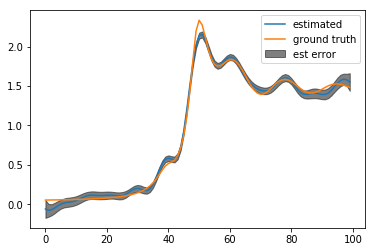

In [28]:
figure()
μ = m.predict_mean().detach().squeeze().numpy()
σ = m.predict_var().detach().sqrt().squeeze().numpy()
plot(μ, label='estimated')
fill_between(np.arange(100),μ+σ,μ-σ,color='k',alpha=0.5,label='est error')
plot(y,label='ground truth')
legend()

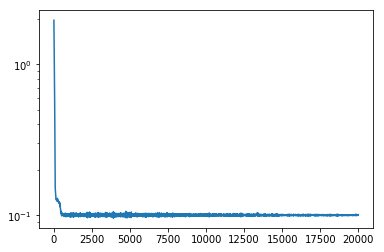

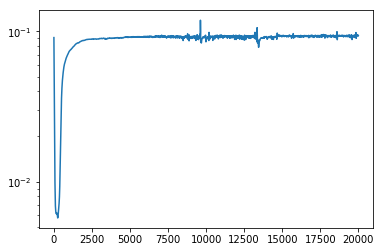

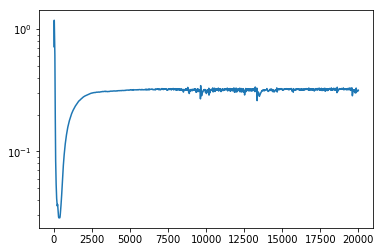

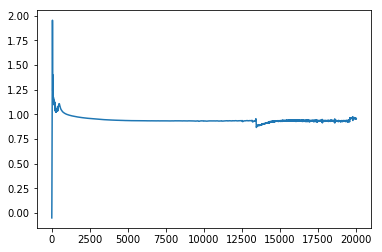

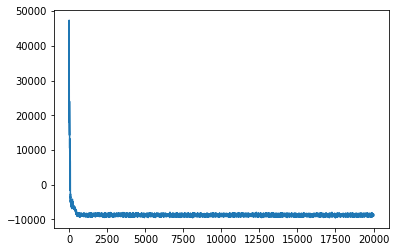

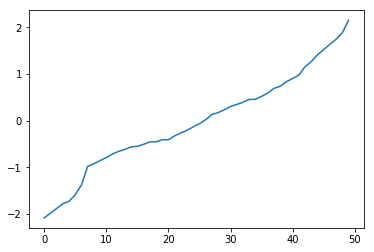

In [30]:
figure()
semilogy(Logger.val_dict['hyper_params.std_lik'])
figure()
semilogy(Logger.val_dict['stored_modules.K0._lengthscale_storage'])
figure()
semilogy(Logger.val_dict['stored_modules.K0._amplitude_storage'])
figure()
plot(Logger.val_dict['stored_modules.mprior.value'])
figure()
plot(Logger.val_dict['loss'])
figure()
plot(np.sort(m.hyper_params['u0'].detach().numpy().squeeze()))